### Included

* Data prep (cleaning, scaling)
* Linear (+ Ridge and Lasso Regression)
* Random Forest (with Grid Search)
* MLP (with Grid Search)
* XGBoost (with Bayesian Optimization)
* Separate XGBoost models for baseline/+TFIDF/+cluster

## Setup

In [139]:
import numpy as np
import sklearn as sk
import pandas as pd

print('Numpy: ', np.__version__) #1.16.2
print('Sklearn: ', sk.__version__) # 0.19.1
print('Pandas: ', pd.__version__) # 0.24.2

Numpy:  1.16.2
Sklearn:  0.19.1
Pandas:  0.24.2


In [140]:
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, LogisticRegression
from sklearn.metrics import classification_report, mean_squared_error, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from matplotlib import pyplot as plt
import xgboost as xgb
import datetime
from hyperopt import hp, tpe, fmin, STATUS_OK


## Helper functions

In [141]:
def get_adjusted_r2(model, X, y):
    r2 = model.score(X, y)
    n = X.shape[0]
    p = X.shape[1]
    
    adj_r2 = r2 - (1 - r2)*(p/(n-p-1))
    return adj_r2

In [142]:
def get_mape(y_true, y_pred):
    abs_errors = [np.abs((y_true-y_pred)/y_true) for y_true,y_pred in zip(y_true,y_pred)]
    mape = (sum(abs_errors)/len(abs_errors)) * 100
    return mape

In [143]:
def get_mdape(y_true, y_pred):
    abs_errors = [np.abs((y_true-y_pred)/y_true) for y_true,y_pred in zip(y_true,y_pred)]
    mdape = np.median(abs_errors) * 100
    return mdape

## Import Data

In [144]:
df = pd.read_csv('merged3.csv')

In [145]:
df.drop(columns=['1'], inplace=True)

In [146]:
df.columns = ['PropertyZip', 'TFIDF', 'AirbnbRev', 'ID', 'PropertyFullStreetAddress', 'PropertyAddressUnitNumber',
       'PropertyCity', 'County', 'PropertyAddressLatitude',
       'PropertyAddressLongitude', 'BuildingAreaSqFt', 'LotSizeSquareFeet',
       'FireplaceNumber', 'YearBuilt', 'NoOfStories', 'TotalBedrooms',
       'NormalizedBathCount', 'LandAssessedValue', 'ImprovementAssessedValue',
       'TotalAssessedValue', 'GarageNoOfCars', 'NormalizedListPrice',
       'ListDate', 'NormalizedSalePrice', 'SoldDate', 'ListYearMonth',
       'SoldYearMonth', 'MonthsToSale', 'NormalizedSalesPremium',
       'built_prct']

In [147]:
cluster_data = pd.read_csv('merged-cluster-full.csv')

In [148]:
merged = df.merge(cluster_data[['Unnamed: 0','neighborhood','cluster','neigh_match_clust']], how='left', left_on='ID', right_on='Unnamed: 0')

In [149]:
# Log Sales Price
merged['LogSalePrice'] = np.log(merged['NormalizedSalePrice'])

In [150]:
merged['TFIDF'] = merged['TFIDF'].apply(lambda x: float(x))

In [151]:
# Uncomment to write to csv
# merged.to_csv("merged-full.csv")

### Filter columns for analysis

In [152]:
df = merged

In [153]:
# Exclude 'NormalizedListPrice' because it may be too correlated with target 'NormalizedSalePrice'
target = ['NormalizedSalePrice']
numeric_cols = ['BuildingAreaSqFt', 'LotSizeSquareFeet', 'NoOfStories', 'TotalBedrooms', 
                'NormalizedBathCount', 'LandAssessedValue', 'ImprovementAssessedValue', 'TotalAssessedValue', 
                'GarageNoOfCars', 'PropertyAddressLatitude', 'PropertyAddressLongitude',
                'built_prct', 'TFIDF'
               ]
categorical_cols = ['PropertyZip', 'YearBuilt', 'ListYearMonth','neigh_match_clust','cluster','neighborhood']

In [154]:
df_noNA = df[target + numeric_cols + categorical_cols  + ['LogSalePrice', 'NormalizedListPrice','ListDate', 'SoldDate']].dropna()

In [155]:
listDate = [datetime.datetime.strptime(str(i), "%Y-%m-%d").date() for i in df_noNA.ListDate]
df_noNA['ListYear'] = [date.year for date in listDate]
df_noNA['ListMonth'] = [date.month for date in listDate]
df_noNA['ListDay'] = [date.day for date in listDate]

categorical_cols += ['ListYear','ListMonth','ListDay']

# Regression

### Create dataset for Regression

In [156]:
# Create numeric and categorical columns
df_num = df_noNA[numeric_cols]
df_cat = df_noNA[categorical_cols]
df_target  = df_noNA['NormalizedSalePrice']

# Create dummy variables for categorical columns
for column in categorical_cols:
    df_cat[column] = df_cat[column].astype("category")
df_cat = pd.get_dummies(df_cat)

df_reg = pd.concat([df_num, df_cat, df_target, df_noNA[['LogSalePrice', 'NormalizedListPrice', 'SoldDate']]], axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [157]:
# Train/test split
# Split by sold date: Train is any property solde before 2018, Test is any sold after 2018

train_reg = df_reg[df_reg['SoldDate'] < '2018-01-01']
test_reg = df_reg[df_reg['SoldDate'] >= '2018-01-01']
#val_reg = train_reg[train_reg['SoldDate'] >= '2017-07-01']
#train_reg = train_reg[train_reg['SoldDate'] < '2017-07-01']


train_reg.drop(columns = ['SoldDate'], inplace=True)
#val_reg.drop(columns = ['SoldDate'], inplace=True)
test_reg.drop(columns = ['SoldDate'], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [158]:
# Scale numeric features
column_means_std = {}
for numeric_column in numeric_cols:
    means = train_reg[numeric_column].mean()
    std = train_reg[numeric_column].std()
    column_means_std[numeric_column] = [means, std]

def get_z_scores(df, columns):
    for column in columns:
        df[column] = (df[column] - column_means_std[column][0])/column_means_std[column][1]
        
get_z_scores(train_reg, numeric_cols)
#get_z_scores(val_reg, numeric_cols)
get_z_scores(test_reg, numeric_cols)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [159]:
# Get separate (non-log) values for comparable unit metrics later on

listPriceReg_train = train_reg.pop('NormalizedListPrice').reset_index().drop(columns = ['index'])
#listPriceReg_val = val_reg.pop('NormalizedListPrice').reset_index().drop(columns = ['index'])
listPriceReg_test = test_reg.pop('NormalizedListPrice').reset_index().drop(columns = ['index'])

salePriceReg_train = train_reg.pop('NormalizedSalePrice').reset_index().drop(columns = ['index'])
#salePriceReg_val = val_reg.pop('NormalizedSalePrice').reset_index().drop(columns = ['index'])
salePriceReg_test = test_reg.pop('NormalizedSalePrice').reset_index().drop(columns = ['index'])

In [160]:
# Generate final train, val, test set

train_reg_X = train_reg.drop(columns = ['LogSalePrice']).reset_index().drop(columns = ['index'])
train_reg_y = train_reg['LogSalePrice'].reset_index().drop(columns = ['index'])
#val_reg_X = val_reg.drop(columns = ['LogSalePrice']).reset_index().drop(columns = ['index'])
#val_reg_y = val_reg['LogSalePrice'].reset_index().drop(columns = ['index'])
test_reg_X = test_reg.drop(columns = ['LogSalePrice']).reset_index().drop(columns = ['index'])
test_reg_y = test_reg['LogSalePrice'].reset_index().drop(columns = ['index'])

### Run Linear Regression on Train and Val set 

In [161]:
LR = LinearRegression()
LR.fit(train_reg_X, train_reg_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [162]:
print('Train R-squared: {:.3}'.format(LR.score(train_reg_X, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(LR, train_reg_X, train_reg_y)))


Train R-squared: 0.905
Train Adjusted R-squared: 0.903


In [163]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in LR.predict(train_reg_X)])))


Train MAE: 106788.93726638037


In [164]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in LR.predict(train_reg_X)])))


Train MAPE: [12.35299314]


In [165]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in LR.predict(train_reg_X)])))


Train MdAPE: 8.680021073187088


In [166]:
LR_coefficients = pd.DataFrame([train_reg_X.columns, LR.coef_[0]]).T

In [167]:
LR_coefficients.sort_values(1, ascending=False).head(10)

,0,1
263,cluster_23.0,2.23602
57,YearBuilt_1882.0,1.24363
13,PropertyZip_78701.0,0.557795
62,YearBuilt_1910.0,0.407075
61,YearBuilt_1909.0,0.327244
15,PropertyZip_78703.0,0.326521
247,cluster_7.0,0.313701
258,cluster_18.0,0.30699
58,YearBuilt_1900.0,0.293548
21,PropertyZip_78722.0,0.290341


### Ridge regression

In [168]:
reg_RidgeCV = RidgeCV(cv=10)
reg_RidgeCV.fit(train_reg_X, train_reg_y)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=10, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [169]:
print('Train R-squared: {:.3}'.format(reg_RidgeCV.score(train_reg_X, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(reg_RidgeCV, train_reg_X, train_reg_y)))

Train R-squared: 0.903
Train Adjusted R-squared: 0.901


In [170]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = [i for i in salePriceReg_train['NormalizedSalePrice']], y_pred = [max(np.exp(i)[0],0) for i in reg_RidgeCV.predict(train_reg_X)])))


Train MAE: 117415.16040580916


In [171]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in reg_RidgeCV.predict(train_reg_X)])))


Train MAPE: [12.49246201]


In [172]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in reg_RidgeCV.predict(train_reg_X)])))


Train MdAPE: 8.70881900696561


In [173]:
Ridge_coefficients = pd.DataFrame([train_reg_X.columns, reg_RidgeCV.coef_[0]]).T

Top 10 positive features

In [174]:
Ridge_coefficients.sort_values(by=1, ascending=False).head(10)

,0,1
15,PropertyZip_78703.0,0.264844
16,PropertyZip_78704.0,0.253497
13,PropertyZip_78701.0,0.240796
21,PropertyZip_78722.0,0.229215
247,cluster_7.0,0.226885
0,BuildingAreaSqFt,0.203777
278,neighborhood_9.0,0.202368
249,cluster_9.0,0.197533
263,cluster_23.0,0.191644
43,PropertyZip_78746.0,0.188895


Top 10 negative features

In [175]:
Ridge_coefficients.sort_values(by=1, ascending=True).head(10)

,0,1
41,PropertyZip_78744.0,-0.353949
19,PropertyZip_78719.0,-0.285173
45,PropertyZip_78748.0,-0.282732
42,PropertyZip_78745.0,-0.194365
46,PropertyZip_78749.0,-0.178691
259,cluster_19.0,-0.175989
33,PropertyZip_78734.0,-0.166607
315,neighborhood_47.0,-0.158803
248,cluster_8.0,-0.157608
267,cluster_27.0,-0.156822


### Lasso Regression

In [176]:
reg_LassoCV = LassoCV(cv=10)
reg_LassoCV.fit(train_reg_X, train_reg_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [177]:
print('Train R-squared: {:.3}'.format(reg_LassoCV.score(train_reg_X, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(reg_LassoCV, train_reg_X, train_reg_y)))


Train R-squared: 0.893
Train Adjusted R-squared: 0.891


In [178]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in reg_LassoCV.predict(train_reg_X)])))


Train MAE: 174459.99870567676


In [179]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in reg_LassoCV.predict(train_reg_X)])))


Train MAPE: 13.475818157437303


In [180]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in reg_LassoCV.predict(train_reg_X)])))


Train MdAPE: 8.987525636183419


Top 10 positive features

In [181]:
Lasso_coefficients = pd.DataFrame([train_reg_X.columns, reg_LassoCV.coef_]).T

In [182]:
Lasso_coefficients.sort_values(by=1, ascending=False).head(10)

,0,1
247,cluster_7.0,0.280372
16,PropertyZip_78704.0,0.248123
249,cluster_9.0,0.232169
15,PropertyZip_78703.0,0.206441
48,PropertyZip_78751.0,0.201576
0,BuildingAreaSqFt,0.200661
21,PropertyZip_78722.0,0.17695
298,neighborhood_30.0,0.159636
14,PropertyZip_78702.0,0.154279
43,PropertyZip_78746.0,0.152129


Top 10 negative features

In [183]:
Lasso_coefficients.sort_values(by=1, ascending=True).head(10)

,0,1
41,PropertyZip_78744.0,-0.279288
45,PropertyZip_78748.0,-0.20297
33,PropertyZip_78734.0,-0.152258
51,PropertyZip_78754.0,-0.13257
248,cluster_8.0,-0.130602
267,cluster_27.0,-0.129147
46,PropertyZip_78749.0,-0.127494
42,PropertyZip_78745.0,-0.124083
241,cluster_1.0,-0.114048
10,PropertyAddressLongitude,-0.111561


## Random Forest

### Run Random Forest Regressor on Train and Val set 

In [184]:
RF = RandomForestRegressor(max_depth=10, n_estimators=200)
RF.fit(train_reg_X, train_reg_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [185]:
print('Train R-squared: {:.3}'.format(RF.score(train_reg_X, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(RF, train_reg_X, train_reg_y)))


Train R-squared: 0.964
Train Adjusted R-squared: 0.964


In [186]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = train_reg_y, y_pred = [max(np.exp(i),0) for i in RF.predict(train_reg_X)])))


Train MAE: 463175.4405136015


In [187]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in RF.predict(train_reg_X)])))


Train MAPE: 7.337948487768053


In [188]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in RF.predict(train_reg_X)])))


Train MdAPE: 5.160506919568549


### With Grid Search

In [189]:
rfr = RandomForestRegressor()

In [190]:
parameters_rfr = {'n_estimators':[300],
                  'min_samples_split':range(2,5),
                  'max_depth':range(12,7,-1)
                 }

In [191]:
search_rfr = GridSearchCV(rfr, parameters_rfr, verbose=5, n_jobs=-1)

In [192]:
### Don't rerun unless data has changed

#search_rfr.fit(train_reg_X, train_reg_y)

In [193]:
# Set rfr_best based on search
rfr_best = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [194]:
#rfr_best = search_rfr.best_estimator_

In [195]:
rfr_best.fit(train_reg_X, train_reg_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [196]:
print('Train R-squared: {:.3}'.format(rfr_best.score(train_reg_X, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(rfr_best, train_reg_X, train_reg_y)))


Train R-squared: 0.964
Train Adjusted R-squared: 0.964


In [197]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = train_reg_y, y_pred = [max(np.exp(i),0) for i in rfr_best.predict(train_reg_X)])))


Train MAE: 463122.97842950735


In [198]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in rfr_best.predict(train_reg_X)])))


Train MAPE: 7.342703972163955


In [199]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in rfr_best.predict(train_reg_X)])))


Train MdAPE: 5.161336258713114


## Multilayer Perceptron

In [200]:
mlp = MLPRegressor()

In [201]:
parameters_mlp = {'alpha':[1e-5,1e-4,1e-3,1e-2,1e-1, 1, 10],
                  'hidden_layer_sizes': [(10,), (20,), (30,), (40,), (50,)]
                 }

In [202]:
search_mlp = GridSearchCV(mlp, parameters_mlp, verbose=5, n_jobs=-1)

In [203]:
# Don't rerun if data hasn't changed
# search_mlp.fit(train_reg_X, train_reg_y)

In [204]:
# Uncomment if re-running parameter search

#search_mlp.best_score_
#search_mlp.best_estimator_
#mlp_best = search_mlp.best_estimator_

In [205]:
# Parameters from grid search

mlp_best = MLPRegressor(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [206]:
mlp_best.fit(train_reg_X, train_reg_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [207]:
print('Train R-squared: {:.3}'.format(mlp_best.score(train_reg_X, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(mlp_best, train_reg_X, train_reg_y)))


Train R-squared: 0.865
Train Adjusted R-squared: 0.863


In [208]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = train_reg_y, y_pred = [max(np.exp(i),0) for i in mlp_best.predict(train_reg_X)])))


Train MAE: 462324.4034746393


In [209]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in mlp_best.predict(train_reg_X)])))


Train MAPE: 12.069735632598906


In [210]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in mlp_best.predict(train_reg_X)])))


Train MdAPE: 8.954960014343186


### XG Boost - Reg - Full

In [211]:
xg_reg = xgb.XGBRegressor(
    colsample_bylevel= 0.699507644027804,
    colsample_bytree= 0.13838874603775986,
    gamma= 0.0015703697304565445,
    learning_rate= 0.03030216954720586,
    max_depth= 7,
    min_child_weight= 2.869004714648029,
    reg_alpha= 0.2680636971171903,
    reg_lambda= 0.6369959888283081,
    subsample= 0.9961524886057896,
    n_estimators = 1000
)

In [212]:
xg_reg.fit(train_reg_X, train_reg_y)

XGBRegressor(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.699507644027804,
       colsample_bytree=0.13838874603775986, gamma=0.0015703697304565445,
       importance_type='gain', learning_rate=0.03030216954720586,
       max_delta_step=0, max_depth=7, min_child_weight=2.869004714648029,
       missing=None, n_estimators=1000, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0,
       reg_alpha=0.2680636971171903, reg_lambda=0.6369959888283081,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9961524886057896)

In [325]:
print('Train R-squared: {:.3}'.format(xg_reg.score(train_reg_X, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg, train_reg_X, train_reg_y)))

print('Test R-squared: {:.3}'.format(xg_reg.score(test_reg_X, test_reg_y)))
print('Test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg, test_reg_X, test_reg_y)))

Train R-squared: 0.973
Train Adjusted R-squared: 0.972
Test R-squared: 0.869
Test Adjusted R-squared: 0.862


In [214]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg.predict(train_reg_X)])))
print('Test MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg.predict(test_reg_X)])))


Train MAE: 31794.48960651843
Test MAE: 76114.18507455065


In [215]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg.predict(train_reg_X)])))
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg.predict(test_reg_X)])))


Train MAPE: 6.498048821335775
Train MAPE: 12.968013990004021


In [216]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg.predict(train_reg_X)])))
print('Test MdAPE: {}'.format(get_mdape(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg.predict(test_reg_X)])))


Train MdAPE: 4.702997252296588
Test MdAPE: 11.103705713530296


In [217]:
y_pred = [max(np.exp(i),0) for i in xg_reg.predict(test_reg_X)]
y_true = salePriceReg_test['NormalizedSalePrice']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Sale Price: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Sale Price: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Sale Price:  0.45
Percent of esimtates within 5% of Sale Price:  0.22


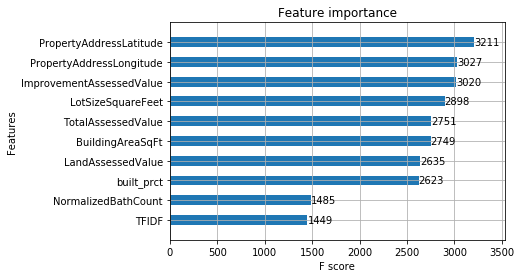

In [218]:
xgb.plot_importance(xg_reg,  height=0.5, max_num_features = 10)
plt.show()

In [219]:
# Export csv of Property ID, Predicted Sale Price, Actual Sale Price
#combined_reg = pd.concat([test_reg_X, pd.Series(y_pred), pd.Series(y_true)], axis=1)
#combined_reg.to_csv("combined_reg_pred.csv")

### XGBoost - Baseline with TFIDF

In [220]:
train_reg_X_tfidf = train_reg_X.drop(columns = cols_to_remove)
test_reg_X_tfidf = test_reg_X.drop(columns = cols_to_remove)

In [221]:
xg_reg_tfidf = xgb.XGBRegressor(
    colsample_bylevel= 0.699507644027804,
    colsample_bytree= 0.13838874603775986,
    gamma= 0.0015703697304565445,
    learning_rate= 0.03030216954720586,
    max_depth= 7,
    min_child_weight= 2.869004714648029,
    reg_alpha= 0.2680636971171903,
    reg_lambda= 0.6369959888283081,
    subsample= 0.9961524886057896,
    n_estimators = 1000
)

In [222]:
xg_reg_tfidf.fit(train_reg_X_tfidf, train_reg_y)

XGBRegressor(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.699507644027804,
       colsample_bytree=0.13838874603775986, gamma=0.0015703697304565445,
       importance_type='gain', learning_rate=0.03030216954720586,
       max_delta_step=0, max_depth=7, min_child_weight=2.869004714648029,
       missing=None, n_estimators=1000, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0,
       reg_alpha=0.2680636971171903, reg_lambda=0.6369959888283081,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9961524886057896)

In [223]:
print('Train R-squared: {:.3}'.format(xg_reg_tfidf.score(train_reg_X_tfidf, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_tfidf, train_reg_X_tfidf, train_reg_y)))

print('Test R-squared: {:.3}'.format(xg_reg_tfidf.score(test_reg_X_tfidf, test_reg_y)))
print('Test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_tfidf, test_reg_X_tfidf, test_reg_y)))


Train R-squared: 0.972
Train Adjusted R-squared: 0.971
Test R-squared: 0.86
Test Adjusted R-squared: 0.854


In [224]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf.predict(train_reg_X_tfidf)])))
print('Test MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf.predict(test_reg_X_tfidf)])))


Train MAE: 32172.788054025717
Test MAE: 78600.69075414454


In [225]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf.predict(train_reg_X_tfidf)])))
print('Test MAPE: {}'.format(get_mape(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf.predict(test_reg_X_tfidf)])))


Train MAPE: 6.585554975036737
Test MAPE: 13.435426928296287


In [226]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf.predict(train_reg_X_tfidf)])))
print('Test MdAPE: {}'.format(get_mdape(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf.predict(test_reg_X_tfidf)])))


Train MdAPE: 4.78955611333622
Test MdAPE: 11.508054731176214


In [227]:
y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf.predict(test_reg_X_tfidf)]
y_true = salePriceReg_test['NormalizedSalePrice']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Sale Price: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Sale Price: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Sale Price:  0.43
Percent of esimtates within 5% of Sale Price:  0.2


### XGBoost - Baseline

In [228]:
cols_to_remove = [c for c in train_reg_X.columns if c.lower()[:5] == 'neigh'] # neighborhood columns
cols_to_remove += [c for c in train_reg_X.columns if c.lower()[:7] == 'cluster'] # cluster columns

train_reg_X_baseline = train_reg_X.drop(columns = cols_to_remove + ['TFIDF'])
test_reg_X_baseline = test_reg_X.drop(columns = cols_to_remove + ['TFIDF'])

In [229]:
xg_reg_baseline = xgb.XGBRegressor(
    colsample_bylevel= 0.699507644027804,
    colsample_bytree= 0.13838874603775986,
    gamma= 0.0015703697304565445,
    learning_rate= 0.03030216954720586,
    max_depth= 7,
    min_child_weight= 2.869004714648029,
    reg_alpha= 0.2680636971171903,
    reg_lambda= 0.6369959888283081,
    subsample= 0.9961524886057896,
    n_estimators = 1000
)

In [230]:
xg_reg_baseline.fit(train_reg_X_baseline, train_reg_y)

XGBRegressor(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.699507644027804,
       colsample_bytree=0.13838874603775986, gamma=0.0015703697304565445,
       importance_type='gain', learning_rate=0.03030216954720586,
       max_delta_step=0, max_depth=7, min_child_weight=2.869004714648029,
       missing=None, n_estimators=1000, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0,
       reg_alpha=0.2680636971171903, reg_lambda=0.6369959888283081,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9961524886057896)

In [231]:
print('Train R-squared: {:.3}'.format(xg_reg_baseline.score(train_reg_X_baseline, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_baseline, train_reg_X_baseline, train_reg_y)))

print('Test R-squared: {:.3}'.format(xg_reg_baseline.score(test_reg_X_baseline, test_reg_y)))
print('Test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_baseline, test_reg_X_baseline, test_reg_y)))


Train R-squared: 0.972
Train Adjusted R-squared: 0.971
Test R-squared: 0.86
Test Adjusted R-squared: 0.854


In [232]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline.predict(train_reg_X_baseline)])))
print('Test MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline.predict(test_reg_X_baseline)])))


Train MAE: 32157.26895002181
Test MAE: 78684.58513327206


In [233]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline.predict(train_reg_X_baseline)])))
print('Test MAPE: {}'.format(get_mape(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline.predict(test_reg_X_baseline)])))


Train MAPE: 6.54545861235984
Test MAPE: 13.497714013745687


In [234]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline.predict(train_reg_X_baseline)])))
print('Test MdAPE: {}'.format(get_mdape(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline.predict(test_reg_X_baseline)])))


Train MdAPE: 4.735805337886036
Test MdAPE: 11.537953319617438


In [235]:
y_pred = [max(np.exp(i),0) for i in xg_reg_baseline.predict(test_reg_X_baseline)]
y_true = salePriceReg_test['NormalizedSalePrice']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Sale Price: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Sale Price: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Sale Price:  0.43
Percent of esimtates within 5% of Sale Price:  0.2


# ----------------------------------------------------------

## More recent Train (1yr) / Test (1yr) split for XGBoost

In [267]:
# Train/test split
# Split by sold date

train_reg_recent = df_reg[df_reg['SoldDate'] < '2018-01-01']
train_reg_recent = train_reg_recent[train_reg_recent['SoldDate'] >= '2017-01-01']
test_reg_recent = df_reg[df_reg['SoldDate'] >= '2018-01-01']

train_reg_recent.drop(columns = ['SoldDate'], inplace=True)
test_reg_recent.drop(columns = ['SoldDate'], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [268]:
# Scale numeric features
column_means_std = {}
for numeric_column in numeric_cols:
    means = train_reg_recent[numeric_column].mean()
    std = train_reg_recent[numeric_column].std()
    column_means_std[numeric_column] = [means, std]

def get_z_scores(df, columns):
    for column in columns:
        df[column] = (df[column] - column_means_std[column][0])/column_means_std[column][1]
        
get_z_scores(train_reg_recent, numeric_cols)
get_z_scores(test_reg_recent, numeric_cols)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [269]:
# Get separate (non-log) values for comparable unit metrics later on

listPriceReg_train_recent = train_reg_recent.pop('NormalizedListPrice').reset_index().drop(columns = ['index'])
listPriceReg_test_recent = test_reg_recent.pop('NormalizedListPrice').reset_index().drop(columns = ['index'])

salePriceReg_train_recent = train_reg_recent.pop('NormalizedSalePrice').reset_index().drop(columns = ['index'])
salePriceReg_test_recent = test_reg_recent.pop('NormalizedSalePrice').reset_index().drop(columns = ['index'])

In [270]:
# Generate final train, val, test set

train_reg_X_recent = train_reg_recent.drop(columns = ['LogSalePrice']).reset_index().drop(columns = ['index'])
train_reg_y_recent = train_reg_recent['LogSalePrice'].reset_index().drop(columns = ['index'])

test_reg_X_recent = test_reg_recent.drop(columns = ['LogSalePrice']).reset_index().drop(columns = ['index'])
test_reg_y_recent = test_reg_recent['LogSalePrice'].reset_index().drop(columns = ['index'])

In [271]:
xg_reg_recent = xgb.XGBRegressor(
    colsample_bylevel= 0.699507644027804,
    colsample_bytree= 0.13838874603775986,
    gamma= 0.0015703697304565445,
    learning_rate= 0.03030216954720586,
    max_depth= 7,
    min_child_weight= 2.869004714648029,
    reg_alpha= 0.2680636971171903,
    reg_lambda= 0.6369959888283081,
    subsample= 0.9961524886057896,
    n_estimators = 1000
)

In [272]:
xg_reg_recent.fit(train_reg_X_recent, train_reg_y_recent)

XGBRegressor(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.699507644027804,
       colsample_bytree=0.13838874603775986, gamma=0.0015703697304565445,
       importance_type='gain', learning_rate=0.03030216954720586,
       max_delta_step=0, max_depth=7, min_child_weight=2.869004714648029,
       missing=None, n_estimators=1000, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0,
       reg_alpha=0.2680636971171903, reg_lambda=0.6369959888283081,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9961524886057896)

In [273]:
print('Train R-squared: {:.3}'.format(xg_reg_recent.score(train_reg_X_recent, train_reg_y_recent)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_recent, train_reg_X_recent, train_reg_y_recent)))

print('Test R-squared: {:.3}'.format(xg_reg_recent.score(test_reg_X_recent, test_reg_y_recent)))
print('Test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_recent, test_reg_X_recent, test_reg_y_recent)))


Train R-squared: 0.975
Train Adjusted R-squared: 0.973
Test R-squared: 0.906
Test Adjusted R-squared: 0.901


In [274]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_train_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_recent.predict(train_reg_X_recent)])))
print('Test MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_test_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_recent.predict(test_reg_X_recent)])))


Train MAE: 33107.774854780255
Test MAE: 66422.1016944104


In [275]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_recent.predict(train_reg_X_recent)])))
print('Test MAPE: {}'.format(get_mape(y_true = salePriceReg_test_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_recent.predict(test_reg_X_recent)])))


Train MAPE: 6.347128753968809
Test MAPE: 10.784402844822768


In [276]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_recent.predict(train_reg_X_recent)])))
print('Test MdAPE: {}'.format(get_mdape(y_true = salePriceReg_test_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_recent.predict(test_reg_X_recent)])))


Train MdAPE: 4.722642804249016
Test MdAPE: 8.221695441341828


In [277]:
y_pred = [max(np.exp(i),0) for i in xg_reg_recent.predict(test_reg_X_recent)]
y_true = salePriceReg_test_recent['NormalizedSalePrice']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Sale Price: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Sale Price: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Sale Price:  0.59
Percent of esimtates within 5% of Sale Price:  0.32


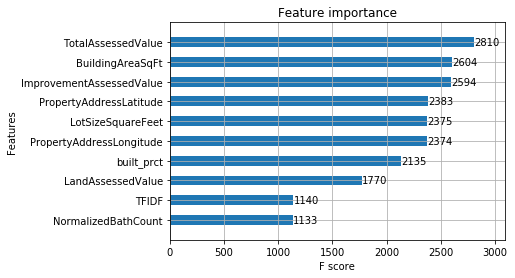

In [278]:
xgb.plot_importance(xg_reg_recent,  height=0.5, max_num_features = 10)
plt.show()

### XGBoost - Baseline with TFIDF

In [279]:
cols_to_remove = [c for c in train_reg_X_recent.columns if c.lower()[:5] == 'neigh'] # neighborhood columns
cols_to_remove += [c for c in train_reg_X_recent.columns if c.lower()[:7] == 'cluster'] # cluster columns

train_reg_X_tfidf_recent = train_reg_X_recent.drop(columns = cols_to_remove)
test_reg_X_tfidf_recent = test_reg_X_recent.drop(columns = cols_to_remove)

In [280]:
xg_reg_tfidf_recent  = xgb.XGBRegressor(
    colsample_bylevel= 0.5860298068889884,
    colsample_bytree= 0.6596435003062208,
    gamma= 0.01953014316539764,
    learning_rate = 0.06848636764184834,
    max_depth = 12,
    min_child_weight = 1.4734939196819945,
    reg_alpha = 0.5300870599544891,
    reg_lambda = 0.7183260659880154,
    subsample = 0.804405903459805,
    n_estimators = 230
)

In [281]:
xg_reg_tfidf_recent.fit(train_reg_X_tfidf_recent, train_reg_y_recent)

XGBRegressor(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5860298068889884,
       colsample_bytree=0.6596435003062208, gamma=0.01953014316539764,
       importance_type='gain', learning_rate=0.06848636764184834,
       max_delta_step=0, max_depth=12, min_child_weight=1.4734939196819945,
       missing=None, n_estimators=230, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0,
       reg_alpha=0.5300870599544891, reg_lambda=0.7183260659880154,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.804405903459805)

In [282]:
print('Train R-squared: {:.3}'.format(xg_reg_tfidf_recent.score(train_reg_X_tfidf_recent, train_reg_y_recent)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_tfidf_recent, train_reg_X_tfidf_recent, train_reg_y_recent)))

print('test R-squared: {:.3}'.format(xg_reg_tfidf_recent.score(test_reg_X_tfidf_recent, test_reg_y_recent)))
print('test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_tfidf_recent, test_reg_X_tfidf_recent, test_reg_y_recent)))


Train R-squared: 0.98
Train Adjusted R-squared: 0.98
test R-squared: 0.904
test Adjusted R-squared: 0.9


In [283]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_train_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf_recent.predict(train_reg_X_tfidf_recent)])))
print('test MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_test_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf_recent.predict(test_reg_X_tfidf_recent)])))


Train MAE: 30398.049819236334
test MAE: 66917.24634906046


In [284]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf_recent.predict(train_reg_X_tfidf_recent)])))
print('test MAPE: {}'.format(get_mape(y_true = salePriceReg_test_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf_recent.predict(test_reg_X_tfidf_recent)])))


Train MAPE: 5.6088772076573274
test MAPE: 10.895325573541722


In [285]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf_recent.predict(train_reg_X_tfidf_recent)])))
print('Test MdAPE: {}'.format(get_mdape(y_true = salePriceReg_test_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf_recent.predict(test_reg_X_tfidf_recent)])))


Train MdAPE: 4.289353992124176
Test MdAPE: 8.332877751294726


In [286]:
y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf_recent.predict(test_reg_X_tfidf_recent)]
y_true = salePriceReg_test_recent['NormalizedSalePrice']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Sale Price: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Sale Price: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Sale Price:  0.58
Percent of esimtates within 5% of Sale Price:  0.31


### XGBoost - baseline_recent

In [287]:
train_reg_X_baseline_recent = train_reg_X_recent.drop(columns = cols_to_remove + ['TFIDF'])
test_reg_X_baseline_recent = test_reg_X_recent.drop(columns = cols_to_remove + ['TFIDF'])

In [288]:
xg_reg_baseline_recent = xgb.XGBRegressor(
    colsample_bylevel= 0.5860298068889884,
    colsample_bytree= 0.6596435003062208,
    gamma= 0.01953014316539764,
    learning_rate = 0.06848636764184834,
    max_depth = 12,
    min_child_weight = 1.4734939196819945,
    reg_alpha = 0.5300870599544891,
    reg_lambda = 0.7183260659880154,
    subsample = 0.804405903459805,
    n_estimators = 230
)

In [289]:
xg_reg_baseline_recent.fit(train_reg_X_baseline_recent, train_reg_y_recent)

XGBRegressor(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5860298068889884,
       colsample_bytree=0.6596435003062208, gamma=0.01953014316539764,
       importance_type='gain', learning_rate=0.06848636764184834,
       max_delta_step=0, max_depth=12, min_child_weight=1.4734939196819945,
       missing=None, n_estimators=230, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0,
       reg_alpha=0.5300870599544891, reg_lambda=0.7183260659880154,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.804405903459805)

In [290]:
print('Train R-squared: {:.3}'.format(xg_reg_baseline_recent.score(train_reg_X_baseline_recent, train_reg_y_recent)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_baseline_recent, train_reg_X_baseline_recent, train_reg_y_recent)))

print('test R-squared: {:.3}'.format(xg_reg_baseline_recent.score(test_reg_X_baseline_recent, test_reg_y_recent)))
print('test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_baseline_recent, test_reg_X_baseline_recent, test_reg_y_recent)))


Train R-squared: 0.98
Train Adjusted R-squared: 0.979
test R-squared: 0.905
test Adjusted R-squared: 0.901


In [291]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_train_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline_recent.predict(train_reg_X_baseline_recent)])))
print('test MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_test_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline_recent.predict(test_reg_X_baseline_recent)])))


Train MAE: 30850.96754759483
test MAE: 66714.02610974945


In [292]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline_recent.predict(train_reg_X_baseline_recent)])))
print('test MAPE: {}'.format(get_mape(y_true = salePriceReg_test_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline_recent.predict(test_reg_X_baseline_recent)])))


Train MAPE: 5.6883236230836625
test MAPE: 10.854789543453364


In [293]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline_recent.predict(train_reg_X_baseline_recent)])))
print('test MdAPE: {}'.format(get_mdape(y_true = salePriceReg_test_recent['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline_recent.predict(test_reg_X_baseline_recent)])))


Train MdAPE: 4.3267516966786115
test MdAPE: 8.304847425972707


In [294]:
y_pred = [max(np.exp(i),0) for i in xg_reg_baseline_recent.predict(test_reg_X_baseline_recent)]
y_true = salePriceReg_test_recent['NormalizedSalePrice']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Sale Price: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Sale Price: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Sale Price:  0.58
Percent of esimtates within 5% of Sale Price:  0.32


## Random Train/Test split for XGBoost

In [295]:
# Train/test split
# Split randomly [For discussion  - NOT considered a valid method of splitting time series]

train_reg_rand, test_reg_rand = train_test_split(df_reg)
train_reg_rand.drop(columns = ['SoldDate'], inplace=True)
test_reg_rand.drop(columns = ['SoldDate'], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [296]:
# Scale numeric features
column_means_std = {}
for numeric_column in numeric_cols:
    means = train_reg_rand[numeric_column].mean()
    std = train_reg_rand[numeric_column].std()
    column_means_std[numeric_column] = [means, std]

def get_z_scores(df, columns):
    for column in columns:
        df[column] = (df[column] - column_means_std[column][0])/column_means_std[column][1]
        
get_z_scores(train_reg_rand, numeric_cols)
get_z_scores(test_reg_rand, numeric_cols)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [297]:
# Get separate (non-log) values for comparable unit metrics later on

listPriceReg_train_rand = train_reg_rand.pop('NormalizedListPrice').reset_index().drop(columns = ['index'])
listPriceReg_test_rand = test_reg_rand.pop('NormalizedListPrice').reset_index().drop(columns = ['index'])

salePriceReg_train_rand = train_reg_rand.pop('NormalizedSalePrice').reset_index().drop(columns = ['index'])
salePriceReg_test_rand = test_reg_rand.pop('NormalizedSalePrice').reset_index().drop(columns = ['index'])

In [298]:
# Generate final train, val, test set

train_reg_X_rand = train_reg_rand.drop(columns = ['LogSalePrice']).reset_index().drop(columns = ['index'])
train_reg_y_rand = train_reg_rand['LogSalePrice'].reset_index().drop(columns = ['index'])
test_reg_X_rand = test_reg_rand.drop(columns = ['LogSalePrice']).reset_index().drop(columns = ['index'])
test_reg_y_rand = test_reg_rand['LogSalePrice'].reset_index().drop(columns = ['index'])

In [299]:
xg_reg_rand = xgb.XGBRegressor(
    colsample_bylevel= 0.699507644027804,
    colsample_bytree= 0.13838874603775986,
    gamma= 0.0015703697304565445,
    learning_rate= 0.03030216954720586,
    max_depth= 7,
    min_child_weight= 2.869004714648029,
    reg_alpha= 0.2680636971171903,
    reg_lambda= 0.6369959888283081,
    subsample= 0.9961524886057896,
    n_estimators = 1000
)

In [300]:
xg_reg_rand.fit(train_reg_X_rand, train_reg_y_rand)

XGBRegressor(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.699507644027804,
       colsample_bytree=0.13838874603775986, gamma=0.0015703697304565445,
       importance_type='gain', learning_rate=0.03030216954720586,
       max_delta_step=0, max_depth=7, min_child_weight=2.869004714648029,
       missing=None, n_estimators=1000, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0,
       reg_alpha=0.2680636971171903, reg_lambda=0.6369959888283081,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9961524886057896)

In [301]:
print('Train R-squared: {:.3}'.format(xg_reg_rand.score(train_reg_X_rand, train_reg_y_rand)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_rand, train_reg_X_rand, train_reg_y_rand)))

print('Test R-squared: {:.3}'.format(xg_reg_rand.score(test_reg_X_rand, test_reg_y_rand)))
print('Test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_rand, test_reg_X_rand, test_reg_y_rand)))


Train R-squared: 0.969
Train Adjusted R-squared: 0.969
Test R-squared: 0.946
Test Adjusted R-squared: 0.943


In [302]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_train_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_rand.predict(train_reg_X_rand)])))
print('Test MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_test_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_rand.predict(test_reg_X_rand)])))


Train MAE: 34773.93026623925
Test MAE: 47152.94460323249


In [303]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_rand.predict(train_reg_X_rand)])))
print('Test MAPE: {}'.format(get_mape(y_true = salePriceReg_test_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_rand.predict(test_reg_X_rand)])))


Train MAPE: 6.837601188505252
Test MAPE: 8.624212807637097


In [304]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_rand.predict(train_reg_X_rand)])))
print('Test MdAPE: {}'.format(get_mdape(y_true = salePriceReg_test_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_rand.predict(test_reg_X_rand)])))


Train MdAPE: 4.98445070708144
Test MdAPE: 5.938281018576803


In [305]:
y_pred = [max(np.exp(i),0) for i in xg_reg_rand.predict(test_reg_X_rand)]
y_true = salePriceReg_test_rand['NormalizedSalePrice']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Sale Price: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Sale Price: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Sale Price:  0.71
Percent of esimtates within 5% of Sale Price:  0.44


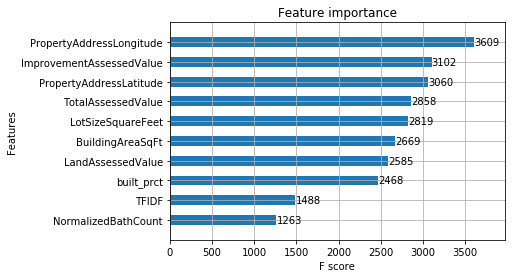

In [306]:
xgb.plot_importance(xg_reg_rand,  height=0.5, max_num_features = 10)
plt.show()

## XGBoost - Baseline with TFIDF

In [307]:
cols_to_remove = [c for c in train_reg_X.columns if c.lower()[:5] == 'neigh'] # neighborhood columns
cols_to_remove += [c for c in train_reg_X.columns if c.lower()[:7] == 'cluster'] # cluster columns

train_reg_X_tfidf_rand = train_reg_X_rand.drop(columns = cols_to_remove)
test_reg_X_tfidf_rand = test_reg_X_rand.drop(columns = cols_to_remove)

### XGB Model

In [308]:
xg_reg_tfidf_rand = xgb.XGBRegressor(
    colsample_bylevel= 0.699507644027804,
    colsample_bytree= 0.13838874603775986,
    gamma= 0.0015703697304565445,
    learning_rate= 0.03030216954720586,
    max_depth= 7,
    min_child_weight= 2.869004714648029,
    reg_alpha= 0.2680636971171903,
    reg_lambda= 0.6369959888283081,
    subsample= 0.9961524886057896,
    n_estimators = 1000
)

In [309]:
xg_reg_tfidf_rand.fit(train_reg_X_tfidf_rand, train_reg_y_rand)

XGBRegressor(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.699507644027804,
       colsample_bytree=0.13838874603775986, gamma=0.0015703697304565445,
       importance_type='gain', learning_rate=0.03030216954720586,
       max_delta_step=0, max_depth=7, min_child_weight=2.869004714648029,
       missing=None, n_estimators=1000, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0,
       reg_alpha=0.2680636971171903, reg_lambda=0.6369959888283081,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9961524886057896)

In [311]:
print('Train R-squared: {:.3}'.format(xg_reg_tfidf_rand.score(train_reg_X_tfidf_rand, train_reg_y_rand)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_tfidf_rand, train_reg_X_tfidf_rand, train_reg_y_rand)))

print('Test R-squared: {:.3}'.format(xg_reg_tfidf_rand.score(test_reg_X_tfidf_rand, test_reg_y_rand)))
print('Test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_tfidf_rand, test_reg_X_tfidf_rand, test_reg_y_rand)))


Train R-squared: 0.968
Train Adjusted R-squared: 0.968
Test R-squared: 0.945
Test Adjusted R-squared: 0.943


In [312]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_train_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf_rand.predict(train_reg_X_tfidf_rand)])))
print('Test MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_test_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf_rand.predict(test_reg_X_tfidf_rand)])))


Train MAE: 44401.13473363278
Test MAE: 45122.85850065264


In [313]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf_rand.predict(train_reg_X_tfidf_rand)])))
print('Test MAPE: {}'.format(get_mape(y_true = salePriceReg_test_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf_rand.predict(test_reg_X_tfidf_rand)])))


Train MAPE: 6.920798905854343
Test MAPE: 8.659771665280122


In [314]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf_rand.predict(train_reg_X_tfidf_rand)])))
print('Test MdAPE: {}'.format(get_mdape(y_true = salePriceReg_test_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf_rand.predict(test_reg_X_tfidf_rand)])))


Train MdAPE: 4.992132208404931
Test MdAPE: 5.887589386261262


In [315]:
y_pred = [max(np.exp(i),0) for i in xg_reg_tfidf_rand.predict(test_reg_X_tfidf_rand)]
y_true = salePriceReg_test_rand['NormalizedSalePrice']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Sale Price: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Sale Price: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Sale Price:  0.71
Percent of esimtates within 5% of Sale Price:  0.44


## XGBoost - Baseline

In [316]:
train_reg_X_baseline_rand = train_reg_X_rand.drop(columns = cols_to_remove + ['TFIDF'])
test_reg_X_baseline_rand = test_reg_X_rand.drop(columns = cols_to_remove + ['TFIDF'])

### XGB Model

In [317]:
xg_reg_baseline_rand = xgb.XGBRegressor(
    colsample_bylevel= 0.699507644027804,
    colsample_bytree= 0.13838874603775986,
    gamma= 0.0015703697304565445,
    learning_rate= 0.03030216954720586,
    max_depth= 7,
    min_child_weight= 2.869004714648029,
    reg_alpha= 0.2680636971171903,
    reg_lambda= 0.6369959888283081,
    subsample= 0.9961524886057896,
    n_estimators = 1000
)

In [319]:
xg_reg_baseline_rand.fit(train_reg_X_baseline_rand, train_reg_y_rand)

XGBRegressor(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.699507644027804,
       colsample_bytree=0.13838874603775986, gamma=0.0015703697304565445,
       importance_type='gain', learning_rate=0.03030216954720586,
       max_delta_step=0, max_depth=7, min_child_weight=2.869004714648029,
       missing=None, n_estimators=1000, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0,
       reg_alpha=0.2680636971171903, reg_lambda=0.6369959888283081,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9961524886057896)

In [320]:
print('Train R-squared: {:.3}'.format(xg_reg_baseline_rand.score(train_reg_X_baseline_rand, train_reg_y_rand)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_baseline_rand, train_reg_X_baseline_rand, train_reg_y_rand)))

print('test R-squared: {:.3}'.format(xg_reg_baseline_rand.score(test_reg_X_baseline_rand, test_reg_y_rand)))
print('test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg_baseline_rand, test_reg_X_baseline_rand, test_reg_y_rand)))


Train R-squared: 0.967
Train Adjusted R-squared: 0.967
test R-squared: 0.944
test Adjusted R-squared: 0.942


In [321]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_train_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline_rand.predict(train_reg_X_baseline_rand)])))
print('test MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_test_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline_rand.predict(test_reg_X_baseline_rand)])))


Train MAE: 35574.870584753786
test MAE: 47823.22179821867


In [322]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline_rand.predict(train_reg_X_baseline_rand)])))
print('test MAPE: {}'.format(get_mape(y_true = salePriceReg_test_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline_rand.predict(test_reg_X_baseline_rand)])))


Train MAPE: 7.037570584187463
test MAPE: 8.783460575712168


In [323]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline_rand.predict(train_reg_X_baseline_rand)])))
print('Test MdAPE: {}'.format(get_mdape(y_true = salePriceReg_test_rand['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg_baseline_rand.predict(test_reg_X_baseline_rand)])))


Train MdAPE: 5.126482625106467
Test MdAPE: 6.065738555602007


In [324]:
y_pred = [max(np.exp(i),0) for i in xg_reg_baseline.predict(test_reg_X_baseline_rand)]
y_true = salePriceReg_test_rand['NormalizedSalePrice']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Sale Price: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Sale Price: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Sale Price:  0.7
Percent of esimtates within 5% of Sale Price:  0.43


# ----------------------------------------------------------

# Time to Sale

In [129]:
df_time = df.copy()

In [130]:
# Exclude 'NormalizedListPrice' because it may be too correlated with target 'NormalizedSalePrice'
target = ['LogDaysToSale']
numeric_cols = ['BuildingAreaSqFt', 'LotSizeSquareFeet', 'NoOfStories', 'TotalBedrooms', 
                'NormalizedBathCount', 'LandAssessedValue', 'ImprovementAssessedValue', 'TotalAssessedValue', 
                'GarageNoOfCars', 'PropertyAddressLatitude', 'PropertyAddressLongitude',
               'NormalizedListPrice', 'built_prct','TFIDF']
categorical_cols = ['PropertyZip', 'YearBuilt', 'ListYearMonth','neighborhood','cluster','neigh_match_clust']

In [131]:
df_noNA = df_time[numeric_cols + categorical_cols + ['ListDate', 'SoldDate']].dropna()

In [132]:
# Create DaysToSale feature
import datetime
    
listDate = [datetime.datetime.strptime(str(i), "%Y-%m-%d").date() for i in df_noNA.ListDate]
soldDate = [datetime.datetime.strptime(str(i), "%Y-%m-%d").date() for i in df_noNA.SoldDate]
timeToSale = []

for i in range(len(listDate)):
    timeToSale.append(max(1,(soldDate[i]-listDate[i]).days))

df_noNA['DaysToSale'] = timeToSale
df_noNA['LogDaysToSale'] = np.log(timeToSale)
df_noNA['ListYear'] = [date.year for date in listDate]
df_noNA['ListMonth'] = [date.month for date in listDate]
df_noNA['ListDay'] = [date.day for date in listDate]

categorical_cols += ['ListYear','ListMonth','ListDay']

In [133]:
# Create numeric and categorical columns
df_num = df_noNA[numeric_cols]
df_cat = df_noNA[categorical_cols]
df_target  = df_noNA['LogDaysToSale']

# Create dummy variables for categorical columns
for column in categorical_cols:
    df_cat[column] = df_cat[column].astype("category")
df_cat = pd.get_dummies(df_cat)

df_time = pd.concat([df_num, df_cat, df_target, df_noNA[['DaysToSale','SoldDate']]], axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [134]:
# Train/test split
# Split based on sold date

train_time = df_time[df_time['SoldDate'] < '2018-01-01']
test_time = df_time[df_time['SoldDate'] >= '2018-01-01']
val_time = train_time[train_time['SoldDate'] >= '2017-07-01']
train_time = train_time[train_time['SoldDate'] < '2017-07-01']


train_time.drop(columns = ['SoldDate'], inplace=True)
val_time.drop(columns = ['SoldDate'], inplace=True)
test_time.drop(columns = ['SoldDate'], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [135]:
column_means_std = {}
for numeric_column in numeric_cols:
    means = train_time[numeric_column].mean()
    std = train_time[numeric_column].std()
    column_means_std[numeric_column] = [means, std]


In [136]:
def get_z_scores(df, columns):
    for column in columns:
        df[column] = (df[column] - column_means_std[column][0])/column_means_std[column][1]

In [137]:
get_z_scores(train_time, numeric_cols)
get_z_scores(val_time, numeric_cols)
get_z_scores(test_time, numeric_cols)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [138]:
daysToSale_train = train_time.pop('DaysToSale').reset_index().drop(columns = ['index'])
daysToSale_val = val_time.pop('DaysToSale').reset_index().drop(columns = ['index'])
daysToSale_test = test_time.pop('DaysToSale').reset_index().drop(columns = ['index'])

In [139]:
train_time_X = train_time.drop(columns = ['LogDaysToSale']).reset_index().drop(columns = ['index'])
train_time_y = train_time['LogDaysToSale'].reset_index().drop(columns = ['index'])
val_time_X = val_time.drop(columns = ['LogDaysToSale']).reset_index().drop(columns = ['index'])
val_time_y = val_time['LogDaysToSale'].reset_index().drop(columns = ['index'])
test_time_X = test_time.drop(columns = ['LogDaysToSale']).reset_index().drop(columns = ['index'])
test_time_y = test_time['LogDaysToSale'].reset_index().drop(columns = ['index'])

# Create Linear Models

### Run Linear Regression on Train and Val set 

In [140]:
LR_time = LinearRegression()
LR_time.fit(train_time_X, train_time_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [142]:
print('Train R-squared: {:.3}'.format(LR_time.score(train_time_X, train_time_y)))
print('Val R-squared: {:.3}'.format(LR_time.score(val_time_X, val_time_y)))

Train R-squared: 0.299
Val R-squared: -1.1


In [143]:
print('Train RMSE: {}'.format(np.sqrt(mean_squared_error(y_true = train_time_y, y_pred = [max(i,0) for i in LR_time.predict(train_time_X)]))))
print('Val RMSE: {}'.format(np.sqrt(mean_squared_error(y_true = val_time_y, y_pred = [max(i,0) for i in LR_time.predict(val_time_X)]))))


Train RMSE: 0.6489245019772948
Val RMSE: 1.013087211390935


In [144]:
time_RidgeCV = RidgeCV(cv=10)
time_RidgeCV.fit(train_time_X, train_time_y)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=10, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [145]:
print('Train R-squared: {:.3}'.format(time_RidgeCV.score(train_time_X, train_time_y)))
print('Val R-squared: {:.3}'.format(time_RidgeCV.score(val_time_X, val_time_y)))

Train R-squared: 0.297
Val R-squared: -0.869


In [146]:
print('Train RMSE: {}'.format(np.sqrt(mean_squared_error(y_true = train_time_y, y_pred = [max(i,0) for i in time_RidgeCV.predict(train_time_X)]))))
print('Val RMSE: {}'.format(np.sqrt(mean_squared_error(y_true = val_time_y, y_pred = [max(i,0) for i in time_RidgeCV.predict(val_time_X)]))))


Train RMSE: 0.6500440350766827
Val RMSE: 0.9564572225377651


In [147]:
time_LassoCV = LassoCV(cv=10)
time_LassoCV.fit(train_time_X, train_time_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [148]:
print('Train R-squared: {:.3}'.format(time_LassoCV.score(train_time_X, train_time_y)))
print('Val R-squared: {:.3}'.format(time_LassoCV.score(val_time_X, val_time_y)))

Train R-squared: 0.29
Val R-squared: -0.865


In [149]:
print('Train RMSE: {}'.format(np.sqrt(mean_squared_error(y_true = train_time_y, y_pred = [max(i,0) for i in time_LassoCV.predict(train_time_X)]))))
print('Test RMSE: {}'.format(np.sqrt(mean_squared_error(y_true = val_time_y, y_pred = [max(i,0) for i in time_LassoCV.predict(val_time_X)]))))


Train RMSE: 0.653386184818394
Test RMSE: 0.9556064879871298


## Random Forest

In [172]:
# Run only if data changes

'''
rfr_time = RandomForestRegressor()
parameters_rfr_time = {'n_estimators':[300],
             'min_samples_split':range(2,10),
              'max_depth':range(15,5,-1)
             }
search_rfr_time = GridSearchCV(rfr_time, parameters_rfr_time, verbose=5, n_jobs=-1)
search_rfr_time.fit(train_time_X, train_time_y)
rfr_time_best = search_rfr_time.best_estimator_
rfr_time_best.fit(train_time_X, train_time_y)

'''

In [150]:
# Result of Grid Search
rfr_time_best = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [151]:
rfr_time_best.fit(train_time_X, train_time_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [152]:
print('Train R-squared: {:.3}'.format(rfr_time_best.score(train_time_X, train_time_y)))
print('Val R-squared: {:.3}'.format(rfr_time_best.score(val_time_X, val_time_y)))


Train R-squared: 0.533
Val R-squared: -1.17


In [153]:
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(rfr_time_best, train_time_X, train_time_y)))
print('Val Adjusted R-squared: {:.3}'.format(get_adjusted_r2(rfr_time_best, val_time_X, val_time_y)))


Train Adjusted R-squared: 0.524
Val Adjusted R-squared: -1.4


In [154]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = daysToSale_train, y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(train_time_X)])))
print('Val MAE: {}'.format(mean_absolute_error(y_true = daysToSale_val, y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(val_time_X)])))


Train MAE: 27.243491953780932
Val MAE: 46.01919506991736


In [155]:
print('Train MAPE: {}'.format(get_mape(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(train_time_X)])))
print('Val MAPE: {}'.format(get_mape(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(val_time_X)])))


Train MAPE: 50.44925444352677
Val MAPE: 64.77372407228678


In [156]:
print('Train MdAPE: {}'.format(get_mdape(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(train_time_X)])))
print('Val MdAPE: {}'.format(get_mdape(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(val_time_X)])))


Train MdAPE: 28.335454225147995
Val MdAPE: 49.78179782787585


In [295]:
y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(test_time_X)]
y_true = daysToSale_test['DaysToSale']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Days to Sale: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Days to Sale: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Days to Sale:  0.11
Percent of esimtates within 5% of Days to Sale:  0.06


## XGBoost Time

In [182]:
xg_time  = xgb.XGBRegressor(
    colsample_bylevel= 0.9449826434429931,
    colsample_bytree= 0.48311309838898053,
    gamma= 1.9957712045246443,
    learning_rate= 0.02558190361314168,
    max_depth= 11,
    min_child_weight= 8.420171749696925,
    reg_alpha= 0.6287636467629159,
    reg_lambda= 0.7760585678413763,
    subsample= 0.9933873755806668,
    n_estimators = 229
)

In [183]:
xg_time.fit(train_time_X, train_time_y)

XGBRegressor(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9449826434429931,
       colsample_bytree=0.48311309838898053, gamma=1.9957712045246443,
       importance_type='gain', learning_rate=0.02558190361314168,
       max_delta_step=0, max_depth=11, min_child_weight=8.420171749696925,
       missing=None, n_estimators=229, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0,
       reg_alpha=0.6287636467629159, reg_lambda=0.7760585678413763,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9933873755806668)

In [184]:
print('Train R-squared: {:.3}'.format(xg_time.score(train_time_X, train_time_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_time, train_time_X, train_time_y)))

print('Val R-squared: {:.3}'.format(xg_time.score(val_time_X, val_time_y)))
print('Val Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_time, val_time_X, val_time_y)))


Train R-squared: 0.446
Train Adjusted R-squared: 0.436
Val R-squared: -0.926
Val Adjusted R-squared: -1.12


In [185]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time.predict(train_time_X)])))
print('Val MAE: {}'.format(mean_absolute_error(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time.predict(val_time_X)])))


Train MAE: 30.51532980544969
Val MAE: 45.68154133225137


In [186]:
print('Train MAPE: {}'.format(get_mape(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time.predict(train_time_X)])))
print('Val MAPE: {}'.format(get_mape(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time.predict(val_time_X)])))


Train MAPE: 60.66691821069086
Val MAPE: 66.50611935121842


In [239]:
print('Train MdAPE: {}'.format(get_mdape(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time.predict(train_time_X)])))
print('Val MdAPE: {}'.format(get_mdape(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time.predict(val_time_X)])))
print('Test MdAPE: {}'.format(get_mdape(y_true = daysToSale_test['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time.predict(test_time_X)])))


Train MdAPE: 30.321045787815837
Val MdAPE: 50.68557748936276
Test MdAPE: 46.233419639829854


In [238]:
y_pred = [max(np.exp(i),0) for i in xg_time.predict(test_time_X)]
y_true = daysToSale_test['DaysToSale']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Sale Price: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Sale Price: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Sale Price:  0.11
Percent of esimtates within 5% of Sale Price:  0.05


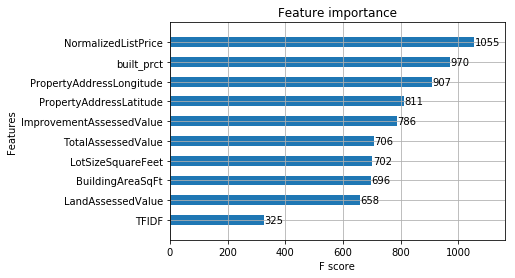

In [325]:
xgb.plot_importance(xg_time,  height=0.5, max_num_features = 10)
plt.show()

In [240]:
# Export csv of Property ID, Predicted Days to Sale, Actual Days to Sale
combined_time = pd.concat([test_time_X, pd.Series(y_pred), pd.Series(y_true)], axis=1)
combined_time.to_csv("combined_time_pred.csv")

## XGBoost Time - Baseline

In [159]:
train_time_X_baseline = train_time_X.drop(columns = cols_to_remove + ['TFIDF'])
val_time_X_baseline = val_time_X.drop(columns = cols_to_remove + ['TFIDF'])
test_time_X_baseline = test_time_X.drop(columns = cols_to_remove + ['TFIDF'])


In [160]:
xg_time_baseline  = xgb.XGBRegressor(
    colsample_bylevel= 0.9449826434429931,
    colsample_bytree= 0.48311309838898053,
    gamma= 1.9957712045246443,
    learning_rate= 0.02558190361314168,
    max_depth= 11,
    min_child_weight= 8.420171749696925,
    reg_alpha= 0.6287636467629159,
    reg_lambda= 0.7760585678413763,
    subsample= 0.9933873755806668,
    n_estimators = 229
)

In [161]:
xg_time_baseline.fit(train_time_X_baseline, train_time_y)

XGBRegressor(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9449826434429931,
       colsample_bytree=0.48311309838898053, gamma=1.9957712045246443,
       importance_type='gain', learning_rate=0.02558190361314168,
       max_delta_step=0, max_depth=11, min_child_weight=8.420171749696925,
       missing=None, n_estimators=229, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0,
       reg_alpha=0.6287636467629159, reg_lambda=0.7760585678413763,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9933873755806668)

In [162]:
print('Train R-squared: {:.3}'.format(xg_time_baseline.score(train_time_X_baseline, train_time_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_time_baseline, train_time_X_baseline, train_time_y)))

print('Val R-squared: {:.3}'.format(xg_time_baseline.score(val_time_X_baseline, val_time_y)))
print('Val Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_time_baseline, val_time_X_baseline, val_time_y)))


Train R-squared: 0.447
Train Adjusted R-squared: 0.44
Val R-squared: -0.853
Val Adjusted R-squared: -0.993


In [163]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time_baseline.predict(train_time_X_baseline)])))
print('Val MAE: {}'.format(mean_absolute_error(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time_baseline.predict(val_time_X_baseline)])))


Train MAE: 30.46154764833969
Val MAE: 45.379145637575355


In [164]:
print('Train MAPE: {}'.format(get_mape(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time_baseline.predict(train_time_X_baseline)])))
print('Val MAPE: {}'.format(get_mape(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time_baseline.predict(val_time_X_baseline)])))


Train MAPE: 60.57718940965885
Val MAPE: 65.97889699668315


In [291]:
print('Train MdAPE: {}'.format(get_mdape(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time_baseline.predict(train_time_X_baseline)])))
print('Val MdAPE: {}'.format(get_mdape(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time_baseline.predict(val_time_X_baseline)])))
print('Test MdAPE: {}'.format(get_mdape(y_true = daysToSale_test['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time_baseline.predict(test_time_X_baseline)])))


Train MdAPE: 30.152521563675137
Val MdAPE: 49.93476752775261
Test MdAPE: 46.411805403859994


In [294]:
y_pred = [max(np.exp(i),0) for i in xg_time_baseline.predict(test_time_X_baseline)]
y_true = daysToSale_test['DaysToSale']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Sale Price: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Sale Price: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Sale Price:  0.11
Percent of esimtates within 5% of Sale Price:  0.05


## XGBoost Time - TFIDF

In [168]:
train_time_X_tfidf = train_time_X.drop(columns = cols_to_remove + ['TFIDF'])
val_time_X_tfidf = val_time_X.drop(columns = cols_to_remove + ['TFIDF'])
test_time_X_tfidf = test_time_X.drop(columns = cols_to_remove + ['TFIDF'])


In [169]:
xg_time_tfidf  = xgb.XGBRegressor(
    colsample_bylevel= 0.9449826434429931,
    colsample_bytree= 0.48311309838898053,
    gamma= 1.9957712045246443,
    learning_rate= 0.02558190361314168,
    max_depth= 11,
    min_child_weight= 8.420171749696925,
    reg_alpha= 0.6287636467629159,
    reg_lambda= 0.7760585678413763,
    subsample= 0.9933873755806668,
    n_estimators = 229
)



In [171]:
xg_time_tfidf.fit(train_time_X_tfidf, train_time_y)

XGBRegressor(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9449826434429931,
       colsample_bytree=0.48311309838898053, gamma=1.9957712045246443,
       importance_type='gain', learning_rate=0.02558190361314168,
       max_delta_step=0, max_depth=11, min_child_weight=8.420171749696925,
       missing=None, n_estimators=229, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0,
       reg_alpha=0.6287636467629159, reg_lambda=0.7760585678413763,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9933873755806668)

In [174]:
print('Train R-squared: {:.3}'.format(xg_time_tfidf.score(train_time_X_tfidf, train_time_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_time_tfidf, train_time_X_tfidf, train_time_y)))

print('Val R-squared: {:.3}'.format(xg_time_tfidf.score(val_time_X_tfidf, val_time_y)))
print('Val Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_time_tfidf, val_time_X_tfidf, val_time_y)))


Train R-squared: 0.447
Train Adjusted R-squared: 0.44
Val R-squared: -0.853
Val Adjusted R-squared: -0.993


In [176]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time_tfidf.predict(train_time_X_tfidf)])))
print('Val MAE: {}'.format(mean_absolute_error(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time_tfidf.predict(val_time_X_tfidf)])))


Train MAE: 30.46154764833969
Val MAE: 45.379145637575355


In [177]:
print('Train MAPE: {}'.format(get_mape(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time_tfidf.predict(train_time_X_tfidf)])))
print('Val MAPE: {}'.format(get_mape(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time_tfidf.predict(val_time_X_tfidf)])))


Train MAPE: 60.57718940965885
Val MAPE: 65.97889699668315


In [292]:
print('Train MdAPE: {}'.format(get_mdape(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time_tfidf.predict(train_time_X_tfidf)])))
print('Val MdAPE: {}'.format(get_mdape(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time_tfidf.predict(val_time_X_tfidf)])))
print('Test MdAPE: {}'.format(get_mdape(y_true = daysToSale_test['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time_tfidf.predict(test_time_X_tfidf)])))


Train MdAPE: 30.152521563675137
Val MdAPE: 49.93476752775261
Test MdAPE: 46.411805403859994


In [293]:
y_pred = [max(np.exp(i),0) for i in xg_time_tfidf.predict(test_time_X_tfidf)]
y_true = daysToSale_test['DaysToSale']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Sale Price: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Sale Price: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Sale Price:  0.11
Percent of esimtates within 5% of Sale Price:  0.05


# ----------------------------------------------------------

# Classification Models

Reframe prediction to classifying whether a property is a "good" investment.

"Good" is defined as a property who's sale price is more than its list price, and will be represented by a binary 1 or 0 feature.

In [190]:
df_class = df.copy()

In [191]:
df_class['GoodInvestment'] = (df_class['NormalizedSalePrice']-df_class['NormalizedListPrice'])/df_class['NormalizedListPrice']
df_class['GoodInvestment'] = pd.Series([1 if x > 0 else 0 for x in df_class['GoodInvestment']]).astype("category")


In [192]:
target = ['GoodInvestment']
numeric_cols = ['BuildingAreaSqFt', 'LotSizeSquareFeet', 'NoOfStories', 'TotalBedrooms', 
                'NormalizedBathCount', 'LandAssessedValue', 'ImprovementAssessedValue', 'TotalAssessedValue', 
                'GarageNoOfCars', 'PropertyAddressLatitude', 'PropertyAddressLongitude']
categorical_cols = ['PropertyZip', 'YearBuilt', 'ListYearMonth']

In [193]:
df_noNA = df_class[target + numeric_cols + categorical_cols].dropna()

In [194]:
# Create numeric and categorical columns
df_num = df_noNA[numeric_cols]
df_cat = df_noNA[categorical_cols]
df_target  = df_noNA['GoodInvestment']

# Create dummy variables for categorical columns
for column in categorical_cols:
    df_cat[column] = df_cat[column].astype("category")
df_cat = pd.get_dummies(df_cat)

df_class = pd.concat([df_num, df_cat, df_target], axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [195]:
# Train/test split
train_class, test_class = train_test_split(df_class, random_state=2)
train_class, val_class = train_test_split(train_class, random_state=2)

In [196]:
column_means_std = {}
for numeric_column in numeric_cols:
    means = train_class[numeric_column].mean()
    std = train_class[numeric_column].std()
    column_means_std[numeric_column] = [means, std]


In [197]:
def get_z_scores(df, columns):
    for column in columns:
        df[column] = (df[column] - column_means_std[column][0])/column_means_std[column][1]

In [198]:
get_z_scores(train_class, numeric_cols)
get_z_scores(val_class, numeric_cols)
get_z_scores(test_class, numeric_cols)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [199]:
train_class_X = train_class.drop(columns = ['GoodInvestment']).reset_index().drop(columns = ['index'])
train_class_y = train_class['GoodInvestment'].reset_index().drop(columns = ['index'])
val_class_X = val_class.drop(columns = ['GoodInvestment']).reset_index().drop(columns = ['index'])
val_class_y = val_class['GoodInvestment'].reset_index().drop(columns = ['index'])
test_class_X = test_class.drop(columns = ['GoodInvestment']).reset_index().drop(columns = ['index'])
test_class_y = test_class['GoodInvestment'].reset_index().drop(columns = ['index'])

### Logistic Regression

In [200]:
LogR = LogisticRegression(class_weight="balanced")

In [201]:
parameters_logr = {'C':[0.001,0.01,0.1,1.0,10]}

In [202]:
search_logr = GridSearchCV(LogR, parameters_logr, verbose=5)

In [203]:
search_logr.fit(train_class_X, train_class_y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.5544635544635544, total=   0.1s
[CV] C=0.001 .........................................................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[CV] ................ C=0.001, score=0.5742833742833743, total=   0.1s
[CV] C=0.001 .........................................................
[CV] ................. C=0.001, score=0.561015561015561, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=0.01, score=0.5947583947583948, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.5983619983619983, total=   0.1s
[CV] C=0.01 ..........................................................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=0.01, score=0.6003276003276004, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ................... C=0.1, score=0.612940212940213, total=   0.1s
[CV] C=0.1 ...........................................................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=0.1, score=0.6198198198198198, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.6144144144144145, total=   0.1s
[CV] C=1.0 ...........................................................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=1.0, score=0.6134316134316135, total=   0.2s
[CV] C=1.0 ...........................................................
[CV] .................. C=1.0, score=0.6248976248976249, total=   0.2s
[CV] C=1.0 ...........................................................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=1.0, score=0.6168714168714169, total=   0.2s
[CV] C=10 ............................................................
[CV] ................... C=10, score=0.6122850122850123, total=   0.2s
[CV] C=10 ............................................................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=10, score=0.6237510237510238, total=   0.2s
[CV] C=10 ............................................................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.4s finished


[CV] .................... C=10, score=0.619000819000819, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [204]:
search_logr.best_score_

0.6184002184002184

In [205]:
search_logr.best_estimator_

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [206]:
logr_best = search_logr.best_estimator_

In [207]:
logr_best.fit(train_class_X, train_class_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [208]:
print(classification_report(y_true = train_class_y, y_pred = logr_best.predict(train_class_X)))

             precision    recall  f1-score   support

          0       0.86      0.61      0.71     13887
          1       0.36      0.69      0.48      4428

avg / total       0.74      0.63      0.66     18315



In [209]:
print(classification_report(y_true = val_class_y, y_pred = logr_best.predict(val_class_X)))

             precision    recall  f1-score   support

          0       0.85      0.60      0.71      4610
          1       0.36      0.68      0.47      1496

avg / total       0.73      0.62      0.65      6106



### Random Forest

In [210]:
rfc = RandomForestClassifier(class_weight='balanced')

In [211]:
parameters_rfc = {'n_estimators':range(200,400,50),
             'min_samples_split':range(2,10),
              'max_depth':range(15,2,-1)
             }

In [212]:
search_rfc = GridSearchCV(rfc, parameters_rfc, verbose=5, n_jobs=-1)

In [213]:
search_rfc.fit(train_class_X, train_class_y)

Fitting 3 folds for each of 416 candidates, totalling 1248 fits
[CV] max_depth=15, min_samples_split=2, n_estimators=200 .............
[CV] max_depth=15, min_samples_split=2, n_estimators=200 .............
[CV] max_depth=15, min_samples_split=2, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=15, min_samples_split=2, n_estimators=250 .............
[CV] max_depth=15, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=15, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=15, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=15, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=2, n_estimators=200, score=0.6430794430794431, total=  10.0s
[CV] max_depth=15, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=2, n_estimators=200, score=0.6311220311220311, total=  10.1s
[CV] max_depth=15, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.3s


[CV]  max_depth=15, min_samples_split=2, n_estimators=200, score=0.6468468468468469, total=  10.2s
[CV] max_depth=15, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=2, n_estimators=250, score=0.646027846027846, total=  12.1s
[CV]  max_depth=15, min_samples_split=2, n_estimators=250, score=0.6303030303030303, total=  12.2s
[CV] max_depth=15, min_samples_split=2, n_estimators=350 .............
[CV] max_depth=15, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=2, n_estimators=250, score=0.6458640458640459, total=  12.2s
[CV] max_depth=15, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=2, n_estimators=300, score=0.6473382473382473, total=  14.2s
[CV] max_depth=15, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=2, n_estimators=300, score=0.628992628992629, total=  14.4s
[CV] max_depth=15, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=3, n_estimators=200, score=0.6237510237510238, total=  10.4s
[CV] max_depth=15, min_samples_split=3, n_estimators=250 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=200, score=0.6430794430794431, total=  10.3s
[CV] max_depth=15, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=2, n_estimators=300, score=0.6478296478296478, total=  14.8s
[CV] max_depth=15, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=3, n_estimators=200, score=0.6437346437346437, total=  10.4s
[CV] max_depth=15, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=2, n_estimators=350, score=0.625061425061425, total=  16.9s
[CV] max_depth=15, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=2, n_estimators=350, score=0.6478296478296478, total=  16.7s
[CV] max_depth=15, min_samples_split=3, n_estimators=350 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=250, score=0.6276822276822277, total=  12.5s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=15, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=2, n_estimators=350, score=0.647010647010647, total=  17.6s
[CV] max_depth=15, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=3, n_estimators=250, score=0.6440622440622441, total=  11.0s
[CV] max_depth=15, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=250, score=0.6475020475020475, total=  11.0s
[CV] max_depth=15, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=3, n_estimators=300, score=0.6301392301392301, total=  13.6s
[CV] max_depth=15, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=300, score=0.6458640458640459, total=  13.5s
[CV] max_depth=15, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=3, n_estimators=300, score=0.646027846027846, total=  13.1s
[CV] max_depth=15, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=3, n_estimators=350, score=0.6312858312858313, total=  15.3s
[CV]  max_depth=15, min_samples_split=4, n_estimators=200, score=0.6252252252252253, total=   8.8s
[CV] max_depth=15, min_samples_split=4, n_estimators=250 .............
[CV] max_depth=15, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=3, n_estimators=350, score=0.6448812448812449, total=  15.3s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=4, n_estimators=200, score=0.6424242424242425, total=   8.9s
[CV] max_depth=15, min_samples_split=4, n_estimators=300 .............
[CV] max_depth=15, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=3, n_estimators=350, score=0.6443898443898444, total=  15.3s
[CV] max_depth=15, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=4, n_estimators=200, score=0.6391482391482392, total=   9.2s
[CV] max_depth=15, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=4, n_estimators=250, score=0.6240786240786241, total=  11.8s
[CV] max_depth=15, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=4, n_estimators=250, score=0.6422604422604422, total=  12.6s
[CV] max_depth=15, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=4, n_estimators=250, score=0.6398034398034398, total=  13.6s
[CV] max_depth=15, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=4, n_estimators=300, score=0.6448812448812449, total=  15.9s
[CV] max_depth=15, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=15, min_samples_split=4, n_estimators=300, score=0.6227682227682227, total=  16.1s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=15, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=4, n_estimators=300, score=0.6398034398034398, total=  16.1s
[CV] max_depth=15, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=5, n_estimators=200, score=0.6230958230958231, total=   9.8s
[CV] max_depth=15, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=4, n_estimators=350, score=0.625061425061425, total=  18.3s
[CV] max_depth=15, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=5, n_estimators=200, score=0.6420966420966421, total=   9.5s
[CV] max_depth=15, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=4, n_estimators=350, score=0.6452088452088452, total=  18.1s
[CV] max_depth=15, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=5, n_estimators=200, score=0.6416052416052416, total=   9.5s
[CV] max_depth=15, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=4, n_estimators=350, score=0.645045045045045, total=  17.4s
[CV] max_depth=15, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=5, n_estimators=250, score=0.6224406224406225, total=  11.9s
[CV] max_depth=15, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=5, n_estimators=250, score=0.642915642915643, total=  11.8s
[CV] max_depth=15, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=5, n_estimators=250, score=0.6399672399672399, total=  12.5s
[CV] max_depth=15, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=5, n_estimators=300, score=0.6229320229320229, total=  15.1s
[CV] max_depth=15, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=6, n_estimators=200, score=0.6239148239148239, total=  10.1s
[CV]  max_depth=15, min_samples_split=5, n_estimators=300, score=0.6414414414414414, total=  15.2s
[CV] max_depth=15, min_samples_split=6, n_estimators=250 .............
[CV] max_depth=15, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=5, n_estimators=300, score=0.6409500409500409, total=  15.2s
[CV] max_depth=15, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=5, n_estimators=350, score=0.6247338247338248, total=  17.5s
[CV] max_depth=15, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=6, n_estimators=200, score=0.6453726453726454, total=  10.0s
[CV] max_depth=15, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=5, n_estimators=350, score=0.642915642915643, total=  17.8s
[CV] max_depth=15, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=5, n_estimators=350, score=0.6434070434070434, total=  17.7s
[CV] max_depth=15, min_samples_split=6, n_estimators=350 .............
[CV]  max_depth=15, min_samples_split=6, n_estimators=200, score=0.6399672399672399, total=   9.7s
[CV] max_depth=15, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=6, n_estimators=250, score=0.6245700245700245, total=  12.0s
[CV] max_depth=15, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=6, n_estimators=250, score=0.6417690417690418, total=  12.1s
[CV] max_depth=15, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=6, n_estimators=250, score=0.6425880425880426, total=  12.1s
[CV] max_depth=15, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=6, n_estimators=300, score=0.6257166257166257, total=  15.4s
[CV] max_depth=15, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=6, n_estimators=300, score=0.6432432432432432, total=  15.4s
[CV] max_depth=15, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.9min


[CV]  max_depth=15, min_samples_split=6, n_estimators=300, score=0.6407862407862408, total=  15.5s
[CV] max_depth=15, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=7, n_estimators=200, score=0.6212940212940213, total=  10.6s
[CV] max_depth=15, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=7, n_estimators=200, score=0.638984438984439, total=  10.6s
[CV] max_depth=15, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=6, n_estimators=350, score=0.626044226044226, total=  17.4s
[CV] max_depth=15, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=6, n_estimators=350, score=0.6427518427518427, total=  17.5s
[CV] max_depth=15, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=7, n_estimators=200, score=0.6386568386568386, total=   9.1s
[CV] max_depth=15, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=6, n_estimators=350, score=0.6391482391482392, total=  17.6s
[CV] max_depth=15, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=7, n_estimators=250, score=0.6237510237510238, total=  11.2s
[CV] max_depth=15, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=7, n_estimators=250, score=0.6414414414414414, total=  11.2s
[CV] max_depth=15, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=7, n_estimators=250, score=0.6383292383292384, total=  11.7s
[CV] max_depth=15, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=7, n_estimators=300, score=0.6235872235872236, total=  13.9s
[CV] max_depth=15, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=7, n_estimators=300, score=0.6466830466830467, total=  14.0s
[CV] max_depth=15, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=7, n_estimators=300, score=0.6378378378378379, total=  14.0s
[CV] max_depth=15, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=8, n_estimators=200, score=0.619000819000819, total=   8.6s
[CV] max_depth=15, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=8, n_estimators=200, score=0.6420966420966421, total=   8.7s
[CV] max_depth=15, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=7, n_estimators=350, score=0.6227682227682227, total=  15.2s
[CV] max_depth=15, min_samples_split=8, n_estimators=300 .............
[CV]  max_depth=15, min_samples_split=7, n_estimators=350, score=0.6424242424242425, total=  15.2s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=15, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=8, n_estimators=200, score=0.6352170352170352, total=   8.5s
[CV] max_depth=15, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=7, n_estimators=350, score=0.6347256347256347, total=  15.0s
[CV] max_depth=15, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=8, n_estimators=250, score=0.621949221949222, total=  10.3s
[CV] max_depth=15, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=8, n_estimators=250, score=0.638001638001638, total=  10.4s
[CV] max_depth=15, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=8, n_estimators=250, score=0.6347256347256347, total=  10.7s
[CV] max_depth=15, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=8, n_estimators=300, score=0.6239148239148239, total=  12.5s
[CV] max_depth=15, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=8, n_estimators=300, score=0.6375102375102375, total=  12.1s
[CV] max_depth=15, min_samples_split=9, n_estimators=250 .............
[CV]  max_depth=15, min_samples_split=8, n_estimators=300, score=0.6345618345618346, total=  12.1s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=15, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=9, n_estimators=200, score=0.6214578214578215, total=   7.6s
[CV] max_depth=15, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=8, n_estimators=350, score=0.6224406224406225, total=  13.3s
[CV]  max_depth=15, min_samples_split=9, n_estimators=200, score=0.6360360360360361, total=   6.8s
[CV] max_depth=15, min_samples_split=9, n_estimators=300 .............
[CV] max_depth=15, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=8, n_estimators=350, score=0.6396396396396397, total=  12.8s
[CV] max_depth=15, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=8, n_estimators=350, score=0.637018837018837, total=  12.4s
[CV] max_depth=15, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=9, n_estimators=200, score=0.6384930384930385, total=   6.3s
[CV] max_depth=15, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=9, n_estimators=250, score=0.6193284193284193, total=   8.2s
[CV] max_depth=15, min_samples_split=9, n_estimators=350 .............
[CV]  max_depth=15, min_samples_split=9, n_estimators=250, score=0.6396396396396397, total=   8.2s
[CV] max_depth=14, min_samples_split=2, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=9, n_estimators=250, score=0.6409500409500409, total=   8.4s
[CV] max_depth=14, min_samples_split=2, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=9, n_estimators=300, score=0.619000819000819, total=   9.9s
[CV]  max_depth=15, min_samples_split=9, n_estimators=300, score=0.6406224406224407, total=   9.9s
[CV] max_depth=14, min_samples_split=2, n_estimators=200 .............
[CV] max_depth=14, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=9, n_estimators=300, score=0.638001638001638, total=   9.9s
[CV] max_depth=14, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=2, n_estimators=200, score=0.6194922194922194, total=   5.9s
[CV] max_depth=14, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=2, n_estimators=200, score=0.6378378378378379, total=   5.9s
[CV] max_depth=14, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=9, n_estimators=350, score=0.621949221949222, total=  11.2s
[CV] max_depth=14, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=9, n_estimators=350, score=0.6417690417690418, total=  11.1s
[CV] max_depth=14, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=2, n_estimators=200, score=0.638984438984439, total=  53.8s
[CV] max_depth=14, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, min_samples_split=9, n_estimators=350, score=0.637018837018837, total=  59.4s
[CV] max_depth=14, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=2, n_estimators=250, score=0.61998361998362, total=  57.1s
[CV] max_depth=14, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=2, n_estimators=250, score=0.6402948402948403, total= 1.0min
[CV] max_depth=14, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=2, n_estimators=250, score=0.6381654381654381, total= 2.8min
[CV] max_depth=14, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=2, n_estimators=300, score=0.6191646191646192, total= 2.9min
[CV] max_depth=14, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=2, n_estimators=300, score=0.6365274365274365, total= 2.7min
[CV] max_depth=14, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=2, n_estimators=300, score=0.6388206388206388, total= 2.7min
[CV] max_depth=14, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=3, n_estimators=200, score=0.6217854217854217, total=  47.5s
[CV] max_depth=14, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=3, n_estimators=200, score=0.6355446355446356, total=  48.2s
[CV] max_depth=14, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=2, n_estimators=350, score=0.61998361998362, total= 2.8min
[CV] max_depth=14, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=2, n_estimators=350, score=0.6386568386568386, total= 2.7min
[CV] max_depth=14, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=3, n_estimators=200, score=0.6296478296478296, total=  43.1s
[CV] max_depth=14, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=2, n_estimators=350, score=0.6378378378378379, total= 2.7min
[CV] max_depth=14, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=3, n_estimators=250, score=0.61998361998362, total=  12.3s
[CV] max_depth=14, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=3, n_estimators=250, score=0.6342342342342342, total=  12.0s
[CV] max_depth=14, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=3, n_estimators=250, score=0.6347256347256347, total=  11.2s
[CV] max_depth=14, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=3, n_estimators=300, score=0.6191646191646192, total=  14.4s
[CV] max_depth=14, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=3, n_estimators=300, score=0.6384930384930385, total=  15.2s
[CV] max_depth=14, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=3, n_estimators=300, score=0.638001638001638, total=  15.8s
[CV] max_depth=14, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=4, n_estimators=200, score=0.6186732186732187, total=  11.5s
[CV] max_depth=14, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=4, n_estimators=200, score=0.6355446355446356, total=  11.2s
[CV] max_depth=14, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=3, n_estimators=350, score=0.620966420966421, total=  18.2s
[CV] max_depth=14, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=3, n_estimators=350, score=0.6368550368550369, total=  18.2s
[CV] max_depth=14, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=4, n_estimators=200, score=0.6316134316134316, total=  10.8s
[CV] max_depth=14, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=3, n_estimators=350, score=0.6361998361998362, total=  19.6s
[CV] max_depth=14, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=4, n_estimators=250, score=0.6201474201474202, total=  12.9s
[CV] max_depth=14, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=4, n_estimators=250, score=0.637018837018837, total=  12.5s
[CV] max_depth=14, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=4, n_estimators=250, score=0.6325962325962325, total=  12.5s
[CV] max_depth=14, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=4, n_estimators=300, score=0.6188370188370188, total=  13.8s
[CV] max_depth=14, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=4, n_estimators=300, score=0.6360360360360361, total=  13.8s
[CV] max_depth=14, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=4, n_estimators=300, score=0.6291564291564291, total=  13.9s
[CV] max_depth=14, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=5, n_estimators=200, score=0.6178542178542179, total=   9.4s
[CV] max_depth=14, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=5, n_estimators=200, score=0.6361998361998362, total=   9.9s
[CV] max_depth=14, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=4, n_estimators=350, score=0.6181818181818182, total=  16.4s
[CV] max_depth=14, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=4, n_estimators=350, score=0.6360360360360361, total=  16.7s
[CV] max_depth=14, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=5, n_estimators=200, score=0.6329238329238329, total=  10.4s
[CV] max_depth=14, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=4, n_estimators=350, score=0.6322686322686323, total=  16.8s
[CV] max_depth=14, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=5, n_estimators=250, score=0.619000819000819, total=  12.6s
[CV] max_depth=14, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=5, n_estimators=250, score=0.6352170352170352, total=  13.0s
[CV] max_depth=14, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=5, n_estimators=250, score=0.6324324324324324, total=  13.5s
[CV] max_depth=14, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=5, n_estimators=300, score=0.61998361998362, total=  15.4s
[CV] max_depth=14, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=5, n_estimators=300, score=0.638001638001638, total=  15.1s
[CV] max_depth=14, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=5, n_estimators=300, score=0.6334152334152334, total=  14.9s
[CV] max_depth=14, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=6, n_estimators=200, score=0.61998361998362, total=   9.7s
[CV] max_depth=14, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=5, n_estimators=350, score=0.6188370188370188, total=  16.5s
[CV] max_depth=14, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=14, min_samples_split=6, n_estimators=200, score=0.6347256347256347, total=   7.7s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=14, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=5, n_estimators=350, score=0.6363636363636364, total=  16.1s
[CV] max_depth=14, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=5, n_estimators=350, score=0.6334152334152334, total=  15.4s
[CV] max_depth=14, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.6min


[CV]  max_depth=14, min_samples_split=6, n_estimators=200, score=0.6301392301392301, total=   7.7s
[CV] max_depth=14, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=6, n_estimators=250, score=0.6157248157248157, total=   9.5s
[CV] max_depth=14, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=6, n_estimators=250, score=0.6361998361998362, total=   9.5s
[CV] max_depth=14, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=6, n_estimators=250, score=0.6281736281736282, total=   9.5s
[CV] max_depth=14, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=6, n_estimators=300, score=0.6185094185094185, total=  11.6s
[CV] max_depth=14, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=6, n_estimators=300, score=0.6358722358722358, total=  11.6s
[CV] max_depth=14, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=6, n_estimators=300, score=0.6332514332514333, total=  11.5s
[CV] max_depth=14, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=7, n_estimators=200, score=0.6175266175266175, total=   7.9s
[CV] max_depth=14, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=7, n_estimators=200, score=0.6345618345618346, total=   7.9s
[CV] max_depth=14, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=6, n_estimators=350, score=0.6175266175266175, total=  13.6s
[CV] max_depth=14, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=6, n_estimators=350, score=0.6340704340704341, total=  13.5s
[CV] max_depth=14, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=6, n_estimators=350, score=0.6365274365274365, total=  14.5s
[CV] max_depth=14, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=7, n_estimators=200, score=0.6342342342342342, total=   8.9s
[CV] max_depth=14, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=7, n_estimators=250, score=0.6173628173628174, total=  10.8s
[CV] max_depth=14, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=7, n_estimators=250, score=0.6334152334152334, total=  10.6s
[CV] max_depth=14, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=7, n_estimators=250, score=0.6306306306306306, total=  10.7s
[CV] max_depth=14, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=7, n_estimators=300, score=0.6196560196560197, total=  13.1s
[CV] max_depth=14, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=7, n_estimators=300, score=0.6357084357084357, total=  14.6s
[CV] max_depth=14, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=7, n_estimators=300, score=0.6343980343980344, total=  14.5s
[CV] max_depth=14, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=8, n_estimators=200, score=0.6185094185094185, total=  11.2s
[CV] max_depth=14, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=8, n_estimators=200, score=0.6404586404586404, total=  11.4s
[CV] max_depth=14, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=7, n_estimators=350, score=0.6175266175266175, total=  17.9s
[CV] max_depth=14, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=7, n_estimators=350, score=0.6383292383292384, total=  18.2s
[CV] max_depth=14, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=8, n_estimators=200, score=0.6335790335790336, total=  11.4s
[CV] max_depth=14, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=7, n_estimators=350, score=0.6355446355446356, total=  19.2s
[CV] max_depth=14, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=8, n_estimators=250, score=0.6168714168714169, total=  12.6s
[CV] max_depth=14, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=8, n_estimators=250, score=0.6375102375102375, total=  12.4s
[CV] max_depth=14, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=8, n_estimators=250, score=0.630958230958231, total=  12.3s
[CV] max_depth=14, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=8, n_estimators=300, score=0.6178542178542179, total=  14.3s
[CV] max_depth=14, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=8, n_estimators=300, score=0.6365274365274365, total=  13.6s
[CV] max_depth=14, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=8, n_estimators=300, score=0.6339066339066339, total=  13.7s
[CV] max_depth=14, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=9, n_estimators=200, score=0.616052416052416, total=   9.1s
[CV] max_depth=14, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=8, n_estimators=350, score=0.6175266175266175, total=  15.7s
[CV] max_depth=14, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=9, n_estimators=200, score=0.6291564291564291, total=   8.7s
[CV] max_depth=14, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=8, n_estimators=350, score=0.6345618345618346, total=  15.5s
[CV] max_depth=14, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=8, n_estimators=350, score=0.6319410319410319, total=  15.6s
[CV] max_depth=14, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=9, n_estimators=200, score=0.6316134316134316, total=   8.5s
[CV] max_depth=14, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=9, n_estimators=250, score=0.6163800163800164, total=  10.5s
[CV] max_depth=14, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=9, n_estimators=250, score=0.6321048321048321, total=  10.4s
[CV] max_depth=13, min_samples_split=2, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=9, n_estimators=250, score=0.6322686322686323, total=  10.6s
[CV] max_depth=13, min_samples_split=2, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=9, n_estimators=300, score=0.617035217035217, total=  12.9s
[CV] max_depth=13, min_samples_split=2, n_estimators=200 .............
[CV]  max_depth=14, min_samples_split=9, n_estimators=300, score=0.6343980343980344, total=  12.9s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=13, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=9, n_estimators=300, score=0.6322686322686323, total=  13.0s
[CV] max_depth=13, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=2, n_estimators=200, score=0.6175266175266175, total=   8.0s
[CV] max_depth=13, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=2, n_estimators=200, score=0.6312858312858313, total=   8.7s
[CV] max_depth=13, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=9, n_estimators=350, score=0.6167076167076168, total=  16.2s
[CV] max_depth=13, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=9, n_estimators=350, score=0.6357084357084357, total=  16.2s
[CV] max_depth=13, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=2, n_estimators=200, score=0.6329238329238329, total=  10.8s
[CV] max_depth=13, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=14, min_samples_split=9, n_estimators=350, score=0.633087633087633, total=  17.8s
[CV] max_depth=13, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=2, n_estimators=250, score=0.616052416052416, total=  13.0s
[CV] max_depth=13, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=2, n_estimators=250, score=0.62997542997543, total=  13.7s
[CV] max_depth=13, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=2, n_estimators=250, score=0.6373464373464374, total=  13.4s
[CV] max_depth=13, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=2, n_estimators=300, score=0.6150696150696151, total=  14.9s
[CV] max_depth=13, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=2, n_estimators=300, score=0.6334152334152334, total=  14.3s
[CV] max_depth=13, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=2, n_estimators=300, score=0.6353808353808353, total=  14.4s
[CV] max_depth=13, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=3, n_estimators=200, score=0.6135954135954136, total=   8.5s
[CV] max_depth=13, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=3, n_estimators=200, score=0.6316134316134316, total=   8.4s
[CV] max_depth=13, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=2, n_estimators=350, score=0.6152334152334152, total=  15.5s
[CV] max_depth=13, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=2, n_estimators=350, score=0.6307944307944308, total=  15.5s
[CV] max_depth=13, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=3, n_estimators=200, score=0.6303030303030303, total=   8.4s
[CV] max_depth=13, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=2, n_estimators=350, score=0.6312858312858313, total=  14.9s
[CV] max_depth=13, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=3, n_estimators=250, score=0.6157248157248157, total=  10.5s
[CV] max_depth=13, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=3, n_estimators=250, score=0.6329238329238329, total=  10.3s
[CV] max_depth=13, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=3, n_estimators=250, score=0.628992628992629, total=  10.0s
[CV] max_depth=13, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=3, n_estimators=300, score=0.6144144144144145, total=  12.4s
[CV] max_depth=13, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=3, n_estimators=300, score=0.6307944307944308, total=  12.5s
[CV] max_depth=13, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=3, n_estimators=300, score=0.630958230958231, total=  12.5s
[CV] max_depth=13, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=4, n_estimators=200, score=0.6140868140868141, total=   8.5s
[CV] max_depth=13, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=4, n_estimators=200, score=0.6278460278460278, total=   8.5s
[CV] max_depth=13, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=3, n_estimators=350, score=0.6152334152334152, total=  14.5s
[CV] max_depth=13, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=3, n_estimators=350, score=0.6314496314496314, total=  14.5s
[CV] max_depth=13, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=4, n_estimators=200, score=0.6268632268632268, total=   9.0s
[CV] max_depth=13, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=3, n_estimators=350, score=0.6296478296478296, total=  15.2s
[CV] max_depth=13, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=4, n_estimators=250, score=0.6150696150696151, total=  11.1s
[CV] max_depth=13, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=4, n_estimators=250, score=0.6303030303030303, total=  10.9s
[CV] max_depth=13, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=4, n_estimators=250, score=0.6298116298116299, total=  10.9s
[CV] max_depth=13, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=4, n_estimators=300, score=0.616052416052416, total=  12.7s
[CV] max_depth=13, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=4, n_estimators=300, score=0.628992628992629, total=  12.8s
[CV] max_depth=13, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=4, n_estimators=300, score=0.6285012285012285, total=  12.7s
[CV] max_depth=13, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=5, n_estimators=200, score=0.6108108108108108, total=   7.4s
[CV] max_depth=13, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=5, n_estimators=200, score=0.6270270270270271, total=   7.3s
[CV] max_depth=13, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=4, n_estimators=350, score=0.6144144144144145, total=  13.1s
[CV] max_depth=13, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=4, n_estimators=350, score=0.626044226044226, total=  13.1s
[CV] max_depth=13, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=5, n_estimators=200, score=0.6314496314496314, total=   7.2s
[CV] max_depth=13, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=4, n_estimators=350, score=0.6283374283374283, total=  12.9s
[CV] max_depth=13, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=5, n_estimators=250, score=0.6281736281736282, total=   9.1s
[CV]  max_depth=13, min_samples_split=5, n_estimators=250, score=0.6145782145782146, total=   9.1s
[CV] max_depth=13, min_samples_split=5, n_estimators=350 .............
[CV] max_depth=13, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=5, n_estimators=250, score=0.6303030303030303, total=   9.3s
[CV] max_depth=13, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=5, n_estimators=300, score=0.6152334152334152, total=  11.4s
[CV] max_depth=13, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=5, n_estimators=300, score=0.6273546273546273, total=  11.4s
[CV] max_depth=13, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=5, n_estimators=300, score=0.6306306306306306, total=  11.5s
[CV] max_depth=13, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=6, n_estimators=200, score=0.6113022113022113, total=   7.7s
[CV] max_depth=13, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=6, n_estimators=200, score=0.6273546273546273, total=   7.5s
[CV] max_depth=13, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=5, n_estimators=350, score=0.613923013923014, total=  13.2s
[CV] max_depth=13, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=5, n_estimators=350, score=0.6276822276822277, total=  13.1s
[CV] max_depth=13, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=5, n_estimators=350, score=0.6278460278460278, total=  13.2s
[CV] max_depth=13, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=6, n_estimators=200, score=0.6258804258804259, total=   7.3s
[CV] max_depth=13, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=6, n_estimators=250, score=0.6109746109746109, total=   9.0s
[CV] max_depth=13, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=6, n_estimators=250, score=0.6255528255528255, total=   9.1s
[CV] max_depth=13, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=6, n_estimators=250, score=0.6270270270270271, total=   9.1s
[CV] max_depth=13, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=6, n_estimators=300, score=0.6113022113022113, total=  11.0s
[CV] max_depth=13, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=6, n_estimators=300, score=0.628009828009828, total=  10.9s
[CV] max_depth=13, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=6, n_estimators=300, score=0.6283374283374283, total=  11.2s
[CV] max_depth=13, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=7, n_estimators=200, score=0.6150696150696151, total=   7.2s
[CV] max_depth=13, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=7, n_estimators=200, score=0.6312858312858313, total=   7.2s
[CV] max_depth=13, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=6, n_estimators=350, score=0.6294840294840295, total=  12.3s
[CV]  max_depth=13, min_samples_split=6, n_estimators=350, score=0.6127764127764128, total=  12.5s
[CV] max_depth=13, min_samples_split=7, n_estimators=300 .............
[CV] max_depth=13, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=7, n_estimators=200, score=0.6230958230958231, total=   7.0s
[CV]  max_depth=13, min_samples_split=6, n_estimators=350, score=0.6266994266994267, total=  12.5s
[CV] max_depth=13, min_samples_split=7, n_estimators=350 .............
[CV] max_depth=13, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=7, n_estimators=250, score=0.6108108108108108, total=   8.7s
[CV] max_depth=13, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=7, n_estimators=250, score=0.6265356265356266, total=   8.9s
[CV] max_depth=13, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=7, n_estimators=250, score=0.6252252252252253, total=   9.1s
[CV] max_depth=13, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=7, n_estimators=300, score=0.6126126126126126, total=  11.0s
[CV] max_depth=13, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=7, n_estimators=300, score=0.6242424242424243, total=  11.2s
[CV] max_depth=13, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=7, n_estimators=300, score=0.6247338247338248, total=  11.5s
[CV] max_depth=13, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=8, n_estimators=200, score=0.6114660114660114, total=   7.6s
[CV] max_depth=13, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=8, n_estimators=200, score=0.6278460278460278, total=   7.5s
[CV] max_depth=13, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=7, n_estimators=350, score=0.6116298116298117, total=  13.1s
[CV] max_depth=13, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=7, n_estimators=350, score=0.6276822276822277, total=  13.2s
[CV] max_depth=13, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=8, n_estimators=200, score=0.6273546273546273, total=   7.6s
[CV] max_depth=13, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=7, n_estimators=350, score=0.626044226044226, total=  13.2s
[CV] max_depth=13, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=8, n_estimators=250, score=0.6116298116298117, total=   9.2s
[CV] max_depth=13, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=8, n_estimators=250, score=0.6303030303030303, total=   9.3s
[CV] max_depth=13, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=8, n_estimators=250, score=0.6285012285012285, total=   9.2s
[CV] max_depth=13, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=8, n_estimators=300, score=0.6144144144144145, total=  11.1s
[CV] max_depth=13, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=8, n_estimators=300, score=0.6291564291564291, total=  11.2s
[CV] max_depth=13, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 11.0min


[CV]  max_depth=13, min_samples_split=8, n_estimators=300, score=0.6275184275184276, total=  11.2s
[CV] max_depth=13, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=9, n_estimators=200, score=0.6144144144144145, total=   7.5s
[CV] max_depth=13, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=8, n_estimators=350, score=0.6124488124488124, total=  13.1s
[CV] max_depth=13, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=9, n_estimators=200, score=0.625061425061425, total=   7.5s
[CV] max_depth=13, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=8, n_estimators=350, score=0.6317772317772318, total=  13.0s
[CV] max_depth=13, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=9, n_estimators=200, score=0.6266994266994267, total=   7.6s
[CV] max_depth=13, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=8, n_estimators=350, score=0.6271908271908272, total=  13.4s
[CV] max_depth=13, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=9, n_estimators=250, score=0.6116298116298117, total=   9.5s
[CV] max_depth=13, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=9, n_estimators=250, score=0.6296478296478296, total=   9.6s
[CV] max_depth=12, min_samples_split=2, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=9, n_estimators=250, score=0.6252252252252253, total=  10.2s
[CV] max_depth=12, min_samples_split=2, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=9, n_estimators=300, score=0.6122850122850123, total=  12.2s
[CV] max_depth=12, min_samples_split=2, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=9, n_estimators=300, score=0.630958230958231, total=  12.2s
[CV] max_depth=12, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=9, n_estimators=300, score=0.6257166257166257, total=  12.2s
[CV] max_depth=12, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=2, n_estimators=200, score=0.609009009009009, total=   7.4s
[CV] max_depth=12, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=2, n_estimators=200, score=0.6273546273546273, total=   7.3s
[CV] max_depth=12, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=9, n_estimators=350, score=0.60999180999181, total=  14.0s
[CV] max_depth=12, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=9, n_estimators=350, score=0.6263718263718264, total=  13.8s
[CV] max_depth=12, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=2, n_estimators=200, score=0.6208026208026208, total=   7.0s
[CV] max_depth=12, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=13, min_samples_split=9, n_estimators=350, score=0.6271908271908272, total=  13.5s
[CV] max_depth=12, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=2, n_estimators=250, score=0.6117936117936118, total=   8.8s
[CV] max_depth=12, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=2, n_estimators=250, score=0.6262080262080262, total=   8.6s
[CV] max_depth=12, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=2, n_estimators=250, score=0.6222768222768222, total=   8.7s
[CV] max_depth=12, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=2, n_estimators=300, score=0.6104832104832105, total=  10.4s
[CV] max_depth=12, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=2, n_estimators=300, score=0.6278460278460278, total=  10.4s
[CV] max_depth=12, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=2, n_estimators=300, score=0.6255528255528255, total=  10.6s
[CV] max_depth=12, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=3, n_estimators=200, score=0.6083538083538084, total=   6.9s
[CV] max_depth=12, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=3, n_estimators=200, score=0.6214578214578215, total=   6.7s
[CV] max_depth=12, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=2, n_estimators=350, score=0.6103194103194103, total=  11.7s
[CV] max_depth=12, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=2, n_estimators=350, score=0.6257166257166257, total=  11.7s
[CV] max_depth=12, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=3, n_estimators=200, score=0.6226044226044226, total=   6.6s
[CV] max_depth=12, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=2, n_estimators=350, score=0.6248976248976249, total=  11.9s
[CV] max_depth=12, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=3, n_estimators=250, score=0.609009009009009, total=   8.3s
[CV] max_depth=12, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=3, n_estimators=250, score=0.628009828009828, total=   8.4s
[CV] max_depth=12, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=3, n_estimators=250, score=0.6239148239148239, total=   8.6s
[CV] max_depth=12, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=3, n_estimators=300, score=0.6114660114660114, total=  10.5s
[CV] max_depth=12, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=3, n_estimators=300, score=0.62997542997543, total=  10.5s
[CV] max_depth=12, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=3, n_estimators=300, score=0.6214578214578215, total=  10.7s
[CV] max_depth=12, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=4, n_estimators=200, score=0.6109746109746109, total=   7.2s
[CV] max_depth=12, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=4, n_estimators=200, score=0.6253890253890254, total=   7.0s
[CV] max_depth=12, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=3, n_estimators=350, score=0.6101556101556102, total=  12.3s
[CV] max_depth=12, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=3, n_estimators=350, score=0.6293202293202294, total=  12.2s
[CV] max_depth=12, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=4, n_estimators=200, score=0.6212940212940213, total=   7.3s
[CV] max_depth=12, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=3, n_estimators=350, score=0.6235872235872236, total=  12.6s
[CV] max_depth=12, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=4, n_estimators=250, score=0.6126126126126126, total=   8.9s
[CV] max_depth=12, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=4, n_estimators=250, score=0.6257166257166257, total=   8.9s
[CV] max_depth=12, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=4, n_estimators=250, score=0.6237510237510238, total=   8.9s
[CV] max_depth=12, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=4, n_estimators=300, score=0.608026208026208, total=  10.7s
[CV] max_depth=12, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=4, n_estimators=300, score=0.6263718263718264, total=  10.3s
[CV] max_depth=12, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=4, n_estimators=300, score=0.6240786240786241, total=  10.3s
[CV] max_depth=12, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=5, n_estimators=200, score=0.608026208026208, total=   6.8s
[CV] max_depth=12, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=5, n_estimators=200, score=0.6217854217854217, total=   6.9s
[CV] max_depth=12, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=4, n_estimators=350, score=0.6083538083538084, total=  11.8s
[CV] max_depth=12, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=4, n_estimators=350, score=0.6232596232596233, total=  12.0s
[CV] max_depth=12, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=5, n_estimators=200, score=0.6224406224406225, total=   6.7s
[CV] max_depth=12, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=4, n_estimators=350, score=0.6230958230958231, total=  11.9s
[CV] max_depth=12, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=5, n_estimators=250, score=0.6103194103194103, total=   8.3s
[CV] max_depth=12, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=5, n_estimators=250, score=0.6229320229320229, total=   8.4s
[CV] max_depth=12, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=5, n_estimators=250, score=0.6221130221130221, total=   8.2s
[CV] max_depth=12, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=5, n_estimators=300, score=0.609009009009009, total=   9.9s
[CV] max_depth=12, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=5, n_estimators=300, score=0.6237510237510238, total=   9.9s
[CV] max_depth=12, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=5, n_estimators=300, score=0.6234234234234234, total=   9.8s
[CV] max_depth=12, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=6, n_estimators=200, score=0.6081900081900082, total=   6.4s
[CV] max_depth=12, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=6, n_estimators=200, score=0.6230958230958231, total=   6.6s
[CV] max_depth=12, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=5, n_estimators=350, score=0.6096642096642096, total=  11.4s
[CV] max_depth=12, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=5, n_estimators=350, score=0.6239148239148239, total=  11.6s
[CV] max_depth=12, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=5, n_estimators=350, score=0.6206388206388206, total=  11.7s
[CV] max_depth=12, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=6, n_estimators=200, score=0.6245700245700245, total=   6.9s
[CV] max_depth=12, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=6, n_estimators=250, score=0.6070434070434071, total=   9.0s
[CV] max_depth=12, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=6, n_estimators=250, score=0.6237510237510238, total=   9.0s
[CV] max_depth=12, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=6, n_estimators=250, score=0.6216216216216216, total=   9.2s
[CV] max_depth=12, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=6, n_estimators=300, score=0.608026208026208, total=  12.8s
[CV] max_depth=12, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=6, n_estimators=300, score=0.6240786240786241, total=  13.1s
[CV] max_depth=12, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=6, n_estimators=300, score=0.6227682227682227, total=  13.3s
[CV] max_depth=12, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=7, n_estimators=200, score=0.6083538083538084, total=  10.3s
[CV] max_depth=12, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=7, n_estimators=200, score=0.6188370188370188, total=  10.3s
[CV] max_depth=12, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=6, n_estimators=350, score=0.6063882063882063, total=  16.5s
[CV] max_depth=12, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=6, n_estimators=350, score=0.6240786240786241, total=  16.8s
[CV] max_depth=12, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=6, n_estimators=350, score=0.6204750204750205, total=  17.1s
[CV] max_depth=12, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=7, n_estimators=200, score=0.6245700245700245, total=   9.6s
[CV] max_depth=12, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=7, n_estimators=250, score=0.6075348075348075, total=  11.4s
[CV] max_depth=12, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=7, n_estimators=250, score=0.6196560196560197, total=  11.5s
[CV] max_depth=12, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=7, n_estimators=250, score=0.6208026208026208, total=  10.3s
[CV] max_depth=12, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=7, n_estimators=300, score=0.6073710073710074, total=  12.2s
[CV] max_depth=12, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=7, n_estimators=300, score=0.6226044226044226, total=  12.5s
[CV] max_depth=12, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=7, n_estimators=300, score=0.6203112203112203, total=  12.7s
[CV] max_depth=12, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=8, n_estimators=200, score=0.608026208026208, total=   9.2s
[CV] max_depth=12, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=8, n_estimators=200, score=0.6212940212940213, total=   9.9s
[CV] max_depth=12, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=7, n_estimators=350, score=0.609009009009009, total=  15.5s
[CV] max_depth=12, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=7, n_estimators=350, score=0.6265356265356266, total=  15.6s
[CV] max_depth=12, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=8, n_estimators=200, score=0.6196560196560197, total=   9.8s
[CV] max_depth=12, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=7, n_estimators=350, score=0.620966420966421, total=  16.1s
[CV] max_depth=12, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=8, n_estimators=250, score=0.6070434070434071, total=  11.8s
[CV] max_depth=12, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=8, n_estimators=250, score=0.6217854217854217, total=  11.8s
[CV] max_depth=12, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=8, n_estimators=250, score=0.6196560196560197, total=  11.3s
[CV] max_depth=12, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=8, n_estimators=300, score=0.6083538083538084, total=  13.1s
[CV] max_depth=12, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=8, n_estimators=300, score=0.6235872235872236, total=  12.8s
[CV] max_depth=12, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=8, n_estimators=300, score=0.6226044226044226, total=  12.7s
[CV] max_depth=12, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=9, n_estimators=200, score=0.6086814086814086, total=   7.9s
[CV] max_depth=12, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=9, n_estimators=200, score=0.6183456183456183, total=   7.8s
[CV] max_depth=12, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=8, n_estimators=350, score=0.6119574119574119, total=  14.4s
[CV] max_depth=12, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=8, n_estimators=350, score=0.6226044226044226, total=  13.6s
[CV] max_depth=12, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=9, n_estimators=200, score=0.6186732186732187, total=   7.2s
[CV] max_depth=12, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=8, n_estimators=350, score=0.6206388206388206, total=  13.4s
[CV] max_depth=12, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=9, n_estimators=250, score=0.608026208026208, total=   9.2s
[CV] max_depth=12, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=9, n_estimators=250, score=0.6224406224406225, total=   9.1s
[CV] max_depth=11, min_samples_split=2, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=9, n_estimators=250, score=0.6188370188370188, total=   8.9s
[CV] max_depth=11, min_samples_split=2, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=9, n_estimators=300, score=0.605896805896806, total=  10.8s
[CV] max_depth=11, min_samples_split=2, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=9, n_estimators=300, score=0.6247338247338248, total=  11.0s
[CV] max_depth=11, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=9, n_estimators=300, score=0.6198198198198198, total=  11.1s
[CV] max_depth=11, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=2, n_estimators=200, score=0.6042588042588043, total=   7.0s
[CV] max_depth=11, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=2, n_estimators=200, score=0.6185094185094185, total=   7.0s
[CV] max_depth=11, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=9, n_estimators=350, score=0.6054054054054054, total=  12.8s
[CV] max_depth=11, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=9, n_estimators=350, score=0.6226044226044226, total=  12.9s
[CV] max_depth=11, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=2, n_estimators=200, score=0.6185094185094185, total=   7.3s
[CV] max_depth=11, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=9, n_estimators=350, score=0.6198198198198198, total=  13.4s
[CV] max_depth=11, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=2, n_estimators=250, score=0.6037674037674038, total=   8.9s
[CV] max_depth=11, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=2, n_estimators=250, score=0.6167076167076168, total=   8.6s
[CV] max_depth=11, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=2, n_estimators=250, score=0.6175266175266175, total=   8.6s
[CV] max_depth=11, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=2, n_estimators=300, score=0.6055692055692056, total=  10.2s
[CV] max_depth=11, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=2, n_estimators=300, score=0.618018018018018, total=   9.8s
[CV] max_depth=11, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=2, n_estimators=300, score=0.61998361998362, total=   9.9s
[CV] max_depth=11, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=3, n_estimators=200, score=0.6029484029484029, total=   6.5s
[CV] max_depth=11, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=3, n_estimators=200, score=0.6140868140868141, total=   6.4s
[CV] max_depth=11, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=2, n_estimators=350, score=0.6037674037674038, total=  11.2s
[CV] max_depth=11, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=2, n_estimators=350, score=0.6191646191646192, total=  11.1s
[CV] max_depth=11, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=3, n_estimators=200, score=0.6181818181818182, total=   6.4s
[CV]  max_depth=11, min_samples_split=2, n_estimators=350, score=0.6196560196560197, total=  11.2s
[CV] max_depth=11, min_samples_split=3, n_estimators=350 .............
[CV] max_depth=11, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=3, n_estimators=250, score=0.6011466011466011, total=   8.0s
[CV] max_depth=11, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=3, n_estimators=250, score=0.6198198198198198, total=   8.0s
[CV] max_depth=11, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=3, n_estimators=250, score=0.6198198198198198, total=   8.0s
[CV] max_depth=11, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=3, n_estimators=300, score=0.6022932022932023, total=   9.6s
[CV] max_depth=11, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=3, n_estimators=300, score=0.6201474201474202, total=   9.6s
[CV] max_depth=11, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=3, n_estimators=300, score=0.620966420966421, total=   9.8s
[CV] max_depth=11, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=4, n_estimators=200, score=0.6001638001638001, total=   6.5s
[CV] max_depth=11, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=4, n_estimators=200, score=0.6173628173628174, total=   6.3s
[CV] max_depth=11, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=3, n_estimators=350, score=0.6032760032760033, total=  11.3s
[CV]  max_depth=11, min_samples_split=3, n_estimators=350, score=0.6211302211302211, total=  11.2s
[CV] max_depth=11, min_samples_split=4, n_estimators=300 .............
[CV] max_depth=11, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=4, n_estimators=200, score=0.618018018018018, total=   6.4s
[CV] max_depth=11, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=3, n_estimators=350, score=0.6175266175266175, total=  11.3s
[CV] max_depth=11, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=4, n_estimators=250, score=0.604095004095004, total=   7.9s
[CV] max_depth=11, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=4, n_estimators=250, score=0.6162162162162163, total=   8.0s
[CV] max_depth=11, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=4, n_estimators=250, score=0.6178542178542179, total=   8.0s
[CV] max_depth=11, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=4, n_estimators=300, score=0.6068796068796068, total=   9.6s
[CV] max_depth=11, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=4, n_estimators=300, score=0.6149058149058149, total=   9.6s
[CV] max_depth=11, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=4, n_estimators=300, score=0.6188370188370188, total=   9.8s
[CV] max_depth=11, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=5, n_estimators=200, score=0.6067158067158067, total=   6.6s
[CV] max_depth=11, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=5, n_estimators=200, score=0.6132678132678133, total=   6.6s
[CV]  max_depth=11, min_samples_split=4, n_estimators=350, score=0.6060606060606061, total=  11.4s
[CV] max_depth=11, min_samples_split=5, n_estimators=300 .............
[CV] max_depth=11, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=4, n_estimators=350, score=0.6144144144144145, total=  11.4s
[CV] max_depth=11, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=5, n_estimators=200, score=0.6196560196560197, total=   6.6s
[CV] max_depth=11, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=4, n_estimators=350, score=0.6204750204750205, total=  11.3s
[CV] max_depth=11, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=5, n_estimators=250, score=0.6044226044226044, total=   8.0s
[CV] max_depth=11, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=5, n_estimators=250, score=0.6131040131040131, total=   7.9s
[CV] max_depth=11, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=5, n_estimators=250, score=0.6183456183456183, total=   8.0s
[CV] max_depth=11, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=5, n_estimators=300, score=0.6045864045864046, total=   9.7s
[CV] max_depth=11, min_samples_split=6, n_estimators=200 .............
[CV]  max_depth=11, min_samples_split=5, n_estimators=300, score=0.6157248157248157, total=   9.7s
[CV] max_depth=11, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=5, n_estimators=300, score=0.616052416052416, total=   9.8s
[CV] max_depth=11, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=6, n_estimators=200, score=0.6050778050778051, total=   6.6s
[CV] max_depth=11, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=5, n_estimators=350, score=0.6055692055692056, total=  11.6s
[CV] max_depth=11, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=11, min_samples_split=6, n_estimators=200, score=0.6203112203112203, total=   6.7s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=11, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=5, n_estimators=350, score=0.6149058149058149, total=  11.5s
[CV] max_depth=11, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=5, n_estimators=350, score=0.6145782145782146, total=  11.5s
[CV] max_depth=11, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 14.7min


[CV]  max_depth=11, min_samples_split=6, n_estimators=200, score=0.6116298116298117, total=   6.9s
[CV] max_depth=11, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=6, n_estimators=250, score=0.600982800982801, total=   9.3s
[CV] max_depth=11, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=6, n_estimators=250, score=0.6147420147420147, total=   9.7s
[CV] max_depth=11, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=6, n_estimators=250, score=0.6158886158886159, total=   9.4s
[CV] max_depth=11, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=6, n_estimators=300, score=0.613923013923014, total=  12.1s
[CV] max_depth=11, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=6, n_estimators=300, score=0.6037674037674038, total=  12.3s
[CV] max_depth=11, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=6, n_estimators=300, score=0.6198198198198198, total=  12.5s
[CV] max_depth=11, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=7, n_estimators=200, score=0.6055692055692056, total=   8.2s
[CV] max_depth=11, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=7, n_estimators=200, score=0.6181818181818182, total=   7.9s
[CV] max_depth=11, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=6, n_estimators=350, score=0.6037674037674038, total=  14.4s
[CV] max_depth=11, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=6, n_estimators=350, score=0.6153972153972154, total=  14.3s
[CV] max_depth=11, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=6, n_estimators=350, score=0.6158886158886159, total=  14.2s
[CV] max_depth=11, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=7, n_estimators=200, score=0.6162162162162163, total=   8.4s
[CV] max_depth=11, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=7, n_estimators=250, score=0.6042588042588043, total=  10.7s
[CV] max_depth=11, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=7, n_estimators=250, score=0.6152334152334152, total=  10.7s
[CV] max_depth=11, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=7, n_estimators=250, score=0.6155610155610156, total=  10.9s
[CV] max_depth=11, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=7, n_estimators=300, score=0.6036036036036037, total=  12.5s
[CV] max_depth=11, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=7, n_estimators=300, score=0.6175266175266175, total=  12.1s
[CV] max_depth=11, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=7, n_estimators=300, score=0.6165438165438165, total=  11.8s
[CV] max_depth=11, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=8, n_estimators=200, score=0.6014742014742015, total=   6.7s
[CV] max_depth=11, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=8, n_estimators=200, score=0.613923013923014, total=   6.3s
[CV] max_depth=11, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=7, n_estimators=350, score=0.604095004095004, total=  12.6s
[CV] max_depth=11, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=7, n_estimators=350, score=0.6168714168714169, total=  12.2s
[CV] max_depth=11, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=8, n_estimators=200, score=0.6124488124488124, total=   6.4s
[CV] max_depth=11, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=7, n_estimators=350, score=0.616052416052416, total=  11.4s
[CV] max_depth=11, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=8, n_estimators=250, score=0.6001638001638001, total=   7.8s
[CV] max_depth=11, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=8, n_estimators=250, score=0.612940212940213, total=   7.8s
[CV] max_depth=11, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=8, n_estimators=250, score=0.6108108108108108, total=   7.7s
[CV] max_depth=11, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=8, n_estimators=300, score=0.6001638001638001, total=   9.2s
[CV] max_depth=11, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=8, n_estimators=300, score=0.6162162162162163, total=   9.0s
[CV] max_depth=11, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=8, n_estimators=300, score=0.6119574119574119, total=   9.1s
[CV] max_depth=11, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=9, n_estimators=200, score=0.6021294021294021, total=   6.1s
[CV] max_depth=11, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=9, n_estimators=200, score=0.6173628173628174, total=   6.1s
[CV] max_depth=11, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=8, n_estimators=350, score=0.6, total=  10.7s
[CV] max_depth=11, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=8, n_estimators=350, score=0.6152334152334152, total=  10.7s
[CV] max_depth=11, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=9, n_estimators=200, score=0.6173628173628174, total=   6.3s
[CV] max_depth=11, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=8, n_estimators=350, score=0.612940212940213, total=  10.8s
[CV] max_depth=11, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=9, n_estimators=250, score=0.6026208026208026, total=   7.8s
[CV] max_depth=11, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=9, n_estimators=250, score=0.6134316134316135, total=   7.6s
[CV] max_depth=10, min_samples_split=2, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=9, n_estimators=250, score=0.6155610155610156, total=   7.7s
[CV] max_depth=10, min_samples_split=2, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=9, n_estimators=300, score=0.6042588042588043, total=   9.2s
[CV] max_depth=10, min_samples_split=2, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=9, n_estimators=300, score=0.6117936117936118, total=   9.1s
[CV] max_depth=10, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=9, n_estimators=300, score=0.6147420147420147, total=   9.1s
[CV] max_depth=10, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=2, n_estimators=200, score=0.6032760032760033, total=   5.8s
[CV] max_depth=10, min_samples_split=2, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=2, n_estimators=200, score=0.6101556101556102, total=   5.8s
[CV] max_depth=10, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=9, n_estimators=350, score=0.6037674037674038, total=  10.7s
[CV] max_depth=10, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=9, n_estimators=350, score=0.6165438165438165, total=  10.7s
[CV] max_depth=10, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=2, n_estimators=200, score=0.6142506142506142, total=   6.0s
[CV] max_depth=10, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=9, n_estimators=350, score=0.616052416052416, total=  10.7s
[CV] max_depth=10, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=2, n_estimators=250, score=0.5985257985257986, total=   7.2s
[CV] max_depth=10, min_samples_split=2, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=2, n_estimators=250, score=0.6122850122850123, total=   7.1s
[CV] max_depth=10, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=2, n_estimators=250, score=0.6134316134316135, total=   7.2s
[CV] max_depth=10, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=2, n_estimators=300, score=0.5988533988533988, total=   8.4s
[CV] max_depth=10, min_samples_split=3, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=2, n_estimators=300, score=0.6126126126126126, total=   8.5s
[CV] max_depth=10, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=2, n_estimators=300, score=0.6167076167076168, total=   8.5s
[CV] max_depth=10, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=3, n_estimators=200, score=0.5985257985257986, total=   5.6s
[CV] max_depth=10, min_samples_split=3, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=3, n_estimators=200, score=0.6144144144144145, total=   5.6s
[CV] max_depth=10, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=2, n_estimators=350, score=0.597051597051597, total=  10.0s
[CV] max_depth=10, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=2, n_estimators=350, score=0.6117936117936118, total=   9.7s
[CV] max_depth=10, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=3, n_estimators=200, score=0.612940212940213, total=   5.8s
[CV] max_depth=10, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=2, n_estimators=350, score=0.6135954135954136, total=  10.1s
[CV] max_depth=10, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=3, n_estimators=250, score=0.5975429975429976, total=   7.1s
[CV] max_depth=10, min_samples_split=3, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=3, n_estimators=250, score=0.6147420147420147, total=   7.1s
[CV] max_depth=10, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=3, n_estimators=250, score=0.6111384111384112, total=   7.1s
[CV] max_depth=10, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=3, n_estimators=300, score=0.599017199017199, total=   8.2s
[CV] max_depth=10, min_samples_split=4, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=3, n_estimators=300, score=0.6157248157248157, total=   8.2s
[CV] max_depth=10, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=3, n_estimators=300, score=0.6131040131040131, total=   8.2s
[CV] max_depth=10, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=4, n_estimators=200, score=0.5978705978705978, total=   5.4s
[CV] max_depth=10, min_samples_split=4, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=4, n_estimators=200, score=0.6124488124488124, total=   5.4s
[CV] max_depth=10, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=3, n_estimators=350, score=0.5998361998361998, total=   9.4s
[CV] max_depth=10, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=3, n_estimators=350, score=0.6134316134316135, total=   9.6s
[CV] max_depth=10, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=4, n_estimators=200, score=0.6147420147420147, total=   5.9s
[CV] max_depth=10, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=3, n_estimators=350, score=0.6132678132678133, total=   9.9s
[CV] max_depth=10, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=4, n_estimators=250, score=0.6022932022932023, total=   7.3s
[CV] max_depth=10, min_samples_split=4, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=4, n_estimators=250, score=0.6083538083538084, total=   7.1s
[CV] max_depth=10, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=4, n_estimators=250, score=0.6121212121212121, total=   7.2s
[CV] max_depth=10, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=4, n_estimators=300, score=0.6008190008190009, total=   8.3s
[CV] max_depth=10, min_samples_split=5, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=4, n_estimators=300, score=0.6111384111384112, total=   8.3s
[CV] max_depth=10, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=4, n_estimators=300, score=0.612940212940213, total=   8.2s
[CV] max_depth=10, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=5, n_estimators=200, score=0.5980343980343981, total=   5.3s
[CV] max_depth=10, min_samples_split=5, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=5, n_estimators=200, score=0.6119574119574119, total=   5.4s
[CV] max_depth=10, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=4, n_estimators=350, score=0.5985257985257986, total=   9.4s
[CV] max_depth=10, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=4, n_estimators=350, score=0.6144144144144145, total=   9.2s
[CV] max_depth=10, min_samples_split=5, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=5, n_estimators=200, score=0.6119574119574119, total=   5.4s
[CV] max_depth=10, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=4, n_estimators=350, score=0.6116298116298117, total=   9.3s
[CV] max_depth=10, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=5, n_estimators=250, score=0.5967239967239967, total=   6.5s
[CV] max_depth=10, min_samples_split=5, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=5, n_estimators=250, score=0.6121212121212121, total=   6.4s
[CV] max_depth=10, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=5, n_estimators=250, score=0.6109746109746109, total=   6.4s
[CV] max_depth=10, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=5, n_estimators=300, score=0.6126126126126126, total=   7.7s
[CV] max_depth=10, min_samples_split=6, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=5, n_estimators=300, score=0.5980343980343981, total=   7.9s
[CV] max_depth=10, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=5, n_estimators=300, score=0.6109746109746109, total=   7.9s
[CV] max_depth=10, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=6, n_estimators=200, score=0.5993447993447993, total=   5.4s
[CV] max_depth=10, min_samples_split=6, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=6, n_estimators=200, score=0.613923013923014, total=   5.6s
[CV] max_depth=10, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=5, n_estimators=350, score=0.5963963963963964, total=   9.4s
[CV] max_depth=10, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=5, n_estimators=350, score=0.6131040131040131, total=   9.3s
[CV] max_depth=10, min_samples_split=6, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=5, n_estimators=350, score=0.6121212121212121, total=   9.7s
[CV] max_depth=10, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=6, n_estimators=200, score=0.6081900081900082, total=   5.8s
[CV] max_depth=10, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=6, n_estimators=250, score=0.5950859950859951, total=   7.1s
[CV] max_depth=10, min_samples_split=6, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=6, n_estimators=250, score=0.6150696150696151, total=   7.1s
[CV] max_depth=10, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=6, n_estimators=250, score=0.6086814086814086, total=   7.0s
[CV] max_depth=10, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=6, n_estimators=300, score=0.5968877968877969, total=   8.4s
[CV] max_depth=10, min_samples_split=7, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=6, n_estimators=300, score=0.6121212121212121, total=   8.4s
[CV] max_depth=10, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=6, n_estimators=300, score=0.6088452088452089, total=   8.4s
[CV] max_depth=10, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=7, n_estimators=200, score=0.5986895986895987, total=   5.7s
[CV] max_depth=10, min_samples_split=7, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=7, n_estimators=200, score=0.6121212121212121, total=   5.6s
[CV] max_depth=10, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=6, n_estimators=350, score=0.5977067977067977, total=  10.0s
[CV] max_depth=10, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=6, n_estimators=350, score=0.6140868140868141, total=   9.8s
[CV] max_depth=10, min_samples_split=7, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=7, n_estimators=200, score=0.608026208026208, total=   5.8s
[CV]  max_depth=10, min_samples_split=6, n_estimators=350, score=0.6106470106470107, total=   9.9s
[CV] max_depth=10, min_samples_split=7, n_estimators=350 .............
[CV] max_depth=10, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=7, n_estimators=250, score=0.5996723996723997, total=   7.0s
[CV] max_depth=10, min_samples_split=7, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=7, n_estimators=250, score=0.6122850122850123, total=   7.0s
[CV] max_depth=10, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=7, n_estimators=250, score=0.6076986076986077, total=   7.0s
[CV] max_depth=10, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=7, n_estimators=300, score=0.5975429975429976, total=   8.3s
[CV] max_depth=10, min_samples_split=8, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=7, n_estimators=300, score=0.6124488124488124, total=   8.2s
[CV] max_depth=10, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=7, n_estimators=300, score=0.6088452088452089, total=   8.1s
[CV] max_depth=10, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=8, n_estimators=200, score=0.5981981981981982, total=   5.3s
[CV] max_depth=10, min_samples_split=8, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=8, n_estimators=200, score=0.6116298116298117, total=   5.5s
[CV] max_depth=10, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=7, n_estimators=350, score=0.6127764127764128, total=   9.4s
[CV] max_depth=10, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=7, n_estimators=350, score=0.597051597051597, total=   9.5s
[CV] max_depth=10, min_samples_split=8, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=8, n_estimators=200, score=0.6075348075348075, total=   5.6s
[CV] max_depth=10, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=7, n_estimators=350, score=0.6083538083538084, total=   9.8s
[CV] max_depth=10, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=8, n_estimators=250, score=0.5983619983619983, total=   7.0s
[CV] max_depth=10, min_samples_split=8, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=8, n_estimators=250, score=0.6144144144144145, total=   6.9s
[CV] max_depth=10, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=8, n_estimators=250, score=0.6101556101556102, total=   7.0s
[CV] max_depth=10, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=8, n_estimators=300, score=0.5972153972153972, total=   8.4s
[CV] max_depth=10, min_samples_split=9, n_estimators=200 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=8, n_estimators=300, score=0.6124488124488124, total=   8.3s
[CV] max_depth=10, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=8, n_estimators=300, score=0.6103194103194103, total=   8.4s
[CV] max_depth=10, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=9, n_estimators=200, score=0.5954135954135954, total=   5.6s
[CV] max_depth=10, min_samples_split=9, n_estimators=250 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=9, n_estimators=200, score=0.6076986076986077, total=   5.6s
[CV] max_depth=10, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=8, n_estimators=350, score=0.5954135954135954, total=   9.7s
[CV] max_depth=10, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=8, n_estimators=350, score=0.60999180999181, total=   9.8s
[CV] max_depth=10, min_samples_split=9, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=8, n_estimators=350, score=0.6119574119574119, total=  10.0s
[CV] max_depth=10, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=9, n_estimators=200, score=0.609009009009009, total=   5.8s
[CV] max_depth=10, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=9, n_estimators=250, score=0.6, total=   7.1s
[CV] max_depth=10, min_samples_split=9, n_estimators=350 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=9, n_estimators=250, score=0.608026208026208, total=   7.1s
[CV] max_depth=9, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=9, n_estimators=250, score=0.609009009009009, total=   7.1s
[CV] max_depth=9, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=9, n_estimators=300, score=0.6, total=   8.5s
[CV] max_depth=9, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=9, n_estimators=300, score=0.6078624078624079, total=   8.4s
[CV] max_depth=9, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=9, n_estimators=300, score=0.609009009009009, total=   8.4s
[CV] max_depth=9, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=2, n_estimators=200, score=0.5936117936117936, total=   5.1s
[CV] max_depth=9, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=2, n_estimators=200, score=0.6050778050778051, total=   5.2s
[CV] max_depth=9, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=9, n_estimators=350, score=0.5963963963963964, total=   9.9s
[CV] max_depth=9, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=9, n_estimators=350, score=0.6075348075348075, total=   9.8s
[CV] max_depth=9, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=2, n_estimators=200, score=0.6104832104832105, total=   5.3s
[CV] max_depth=9, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=9, n_estimators=350, score=0.60999180999181, total=   9.8s
[CV] max_depth=9, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=2, n_estimators=250, score=0.592956592956593, total=   6.5s
[CV] max_depth=9, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=2, n_estimators=250, score=0.6072072072072072, total=   6.6s
[CV] max_depth=9, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=2, n_estimators=250, score=0.6106470106470107, total=   6.6s
[CV] max_depth=9, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=2, n_estimators=300, score=0.5950859950859951, total=   7.8s
[CV] max_depth=9, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=2, n_estimators=300, score=0.6063882063882063, total=   7.9s
[CV] max_depth=9, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=2, n_estimators=300, score=0.6127764127764128, total=   7.7s
[CV] max_depth=9, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=3, n_estimators=200, score=0.597051597051597, total=   5.0s
[CV] max_depth=9, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=3, n_estimators=200, score=0.6063882063882063, total=   5.1s
[CV] max_depth=9, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=2, n_estimators=350, score=0.5962325962325963, total=   8.9s
[CV] max_depth=9, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=2, n_estimators=350, score=0.6050778050778051, total=   9.0s
[CV] max_depth=9, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=2, n_estimators=350, score=0.6108108108108108, total=   9.0s
[CV] max_depth=9, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=3, n_estimators=200, score=0.6037674037674038, total=   5.4s
[CV] max_depth=9, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=3, n_estimators=250, score=0.6042588042588043, total=   6.3s
[CV] max_depth=9, min_samples_split=3, n_estimators=350 ..............
[CV]  max_depth=9, min_samples_split=3, n_estimators=250, score=0.591973791973792, total=   6.4s
[CV] max_depth=9, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=3, n_estimators=250, score=0.6055692055692056, total=   6.3s
[CV] max_depth=9, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=3, n_estimators=300, score=0.5921375921375921, total=   7.6s
[CV] max_depth=9, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=3, n_estimators=300, score=0.6036036036036037, total=   7.5s
[CV] max_depth=9, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=3, n_estimators=300, score=0.6091728091728091, total=   7.6s
[CV] max_depth=9, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=4, n_estimators=200, score=0.5901719901719902, total=   5.1s
[CV] max_depth=9, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=4, n_estimators=200, score=0.6045864045864046, total=   5.0s
[CV] max_depth=9, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=3, n_estimators=350, score=0.5926289926289926, total=   8.7s
[CV] max_depth=9, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=3, n_estimators=350, score=0.6022932022932023, total=   8.8s
[CV] max_depth=9, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=4, n_estimators=200, score=0.6036036036036037, total=   5.3s
[CV] max_depth=9, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=3, n_estimators=350, score=0.6078624078624079, total=   9.1s
[CV] max_depth=9, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=4, n_estimators=250, score=0.592956592956593, total=   6.4s
[CV] max_depth=9, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=4, n_estimators=250, score=0.6055692055692056, total=   6.5s
[CV] max_depth=9, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=4, n_estimators=250, score=0.6047502047502048, total=   6.5s
[CV] max_depth=9, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=4, n_estimators=300, score=0.5914823914823915, total=   7.7s
[CV] max_depth=9, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=4, n_estimators=300, score=0.6067158067158067, total=   7.5s
[CV] max_depth=9, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=4, n_estimators=300, score=0.6067158067158067, total=   7.6s
[CV] max_depth=9, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=5, n_estimators=200, score=0.5908271908271908, total=   5.0s
[CV] max_depth=9, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=4, n_estimators=350, score=0.5918099918099918, total=   8.8s
[CV] max_depth=9, min_samples_split=5, n_estimators=300 ..............
[CV]  max_depth=9, min_samples_split=5, n_estimators=200, score=0.6076986076986077, total=   5.1s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=9, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=4, n_estimators=350, score=0.6062244062244062, total=   8.9s
[CV] max_depth=9, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=5, n_estimators=200, score=0.6042588042588043, total=   5.1s
[CV] max_depth=9, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=4, n_estimators=350, score=0.6065520065520066, total=   8.8s
[CV] max_depth=9, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=5, n_estimators=250, score=0.5923013923013923, total=   6.3s
[CV] max_depth=9, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=5, n_estimators=250, score=0.608026208026208, total=   6.4s
[CV] max_depth=9, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=5, n_estimators=250, score=0.6045864045864046, total=   6.5s
[CV] max_depth=9, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=5, n_estimators=300, score=0.5908271908271908, total=   7.8s
[CV] max_depth=9, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=5, n_estimators=300, score=0.6057330057330057, total=   7.8s
[CV] max_depth=9, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=5, n_estimators=300, score=0.6039312039312039, total=   7.9s
[CV] max_depth=9, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=6, n_estimators=200, score=0.5936117936117936, total=   5.2s
[CV] max_depth=9, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=6, n_estimators=200, score=0.6047502047502048, total=   5.2s
[CV] max_depth=9, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=5, n_estimators=350, score=0.5924651924651925, total=   9.1s
[CV] max_depth=9, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=5, n_estimators=350, score=0.6054054054054054, total=   9.1s
[CV] max_depth=9, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=5, n_estimators=350, score=0.605896805896806, total=   9.2s
[CV] max_depth=9, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=6, n_estimators=200, score=0.601965601965602, total=   5.1s
[CV] max_depth=9, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=6, n_estimators=250, score=0.5936117936117936, total=   6.5s
[CV] max_depth=9, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=6, n_estimators=250, score=0.6049140049140049, total=   6.4s
[CV] max_depth=9, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=6, n_estimators=250, score=0.6037674037674038, total=   6.3s
[CV] max_depth=9, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=6, n_estimators=300, score=0.5954135954135954, total=   7.6s
[CV] max_depth=9, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=6, n_estimators=300, score=0.6062244062244062, total=   7.5s
[CV] max_depth=9, min_samples_split=7, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 18.3min


[CV]  max_depth=9, min_samples_split=6, n_estimators=300, score=0.6047502047502048, total=   7.5s
[CV] max_depth=9, min_samples_split=7, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=7, n_estimators=200, score=0.5921375921375921, total=   5.1s
[CV] max_depth=9, min_samples_split=7, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=7, n_estimators=200, score=0.6083538083538084, total=   5.0s
[CV] max_depth=9, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=6, n_estimators=350, score=0.5954135954135954, total=   8.7s
[CV] max_depth=9, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=6, n_estimators=350, score=0.6067158067158067, total=   8.5s
[CV] max_depth=9, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=6, n_estimators=350, score=0.6073710073710074, total=   8.9s
[CV] max_depth=9, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=7, n_estimators=200, score=0.6049140049140049, total=   5.2s
[CV] max_depth=9, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=7, n_estimators=250, score=0.5945945945945946, total=   6.4s
[CV] max_depth=9, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=7, n_estimators=250, score=0.6042588042588043, total=   6.4s
[CV] max_depth=9, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=7, n_estimators=250, score=0.6086814086814086, total=   6.4s
[CV] max_depth=9, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=7, n_estimators=300, score=0.5932841932841932, total=   7.5s
[CV] max_depth=9, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=7, n_estimators=300, score=0.6044226044226044, total=   7.5s
[CV] max_depth=9, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=7, n_estimators=300, score=0.6065520065520066, total=   7.6s
[CV] max_depth=9, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=8, n_estimators=200, score=0.5934479934479935, total=   5.1s
[CV] max_depth=9, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=8, n_estimators=200, score=0.6055692055692056, total=   5.3s
[CV] max_depth=9, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=7, n_estimators=350, score=0.5932841932841932, total=   9.1s
[CV] max_depth=9, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=7, n_estimators=350, score=0.6076986076986077, total=   9.0s
[CV] max_depth=9, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=8, n_estimators=200, score=0.6037674037674038, total=   7.1s
[CV] max_depth=9, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=7, n_estimators=350, score=0.6055692055692056, total=  10.6s
[CV] max_depth=9, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=8, n_estimators=250, score=0.5950859950859951, total=   9.2s
[CV] max_depth=9, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=8, n_estimators=250, score=0.6037674037674038, total=   9.3s
[CV] max_depth=9, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=8, n_estimators=250, score=0.6042588042588043, total=   9.4s
[CV] max_depth=9, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=8, n_estimators=300, score=0.5911547911547912, total=  10.5s
[CV] max_depth=9, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=8, n_estimators=300, score=0.6052416052416052, total=  10.5s
[CV] max_depth=9, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=8, n_estimators=300, score=0.605896805896806, total=  10.2s
[CV] max_depth=9, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=9, n_estimators=200, score=0.5896805896805897, total=   6.1s
[CV] max_depth=9, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=9, n_estimators=200, score=0.6042588042588043, total=   6.2s
[CV] max_depth=9, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=8, n_estimators=350, score=0.5903357903357903, total=  11.2s
[CV] max_depth=9, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=8, n_estimators=350, score=0.6031122031122031, total=  10.8s
[CV] max_depth=9, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=8, n_estimators=350, score=0.6050778050778051, total=  11.1s
[CV] max_depth=9, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=9, n_estimators=200, score=0.6075348075348075, total=   6.7s
[CV] max_depth=9, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=9, n_estimators=250, score=0.592956592956593, total=   8.2s
[CV] max_depth=9, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=9, n_estimators=250, score=0.5991809991809992, total=   8.2s
[CV] max_depth=8, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=9, n_estimators=250, score=0.6076986076986077, total=   8.2s
[CV] max_depth=8, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=9, n_estimators=300, score=0.5927927927927928, total=   9.0s
[CV] max_depth=8, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=9, n_estimators=300, score=0.6026208026208026, total=   8.7s
[CV] max_depth=8, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=9, n_estimators=300, score=0.6091728091728091, total=   8.7s
[CV] max_depth=8, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=2, n_estimators=200, score=0.587059787059787, total=   5.2s
[CV] max_depth=8, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=2, n_estimators=200, score=0.6008190008190009, total=   5.3s
[CV] max_depth=8, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=9, n_estimators=350, score=0.5947583947583948, total=  10.2s
[CV] max_depth=8, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=9, n_estimators=350, score=0.6027846027846028, total=  10.2s
[CV] max_depth=8, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=2, n_estimators=200, score=0.6013104013104014, total=   6.0s
[CV] max_depth=8, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=9, n_estimators=350, score=0.6086814086814086, total=  10.9s
[CV] max_depth=8, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=2, n_estimators=250, score=0.5886977886977887, total=   7.5s
[CV] max_depth=8, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=2, n_estimators=250, score=0.5975429975429976, total=   7.4s
[CV] max_depth=8, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=2, n_estimators=250, score=0.5965601965601965, total=   7.4s
[CV] max_depth=8, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=2, n_estimators=300, score=0.5885339885339885, total=   8.9s
[CV] max_depth=8, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=2, n_estimators=300, score=0.5991809991809992, total=   8.8s
[CV] max_depth=8, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=2, n_estimators=300, score=0.5978705978705978, total=   8.9s
[CV] max_depth=8, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=3, n_estimators=200, score=0.592956592956593, total=   5.9s
[CV] max_depth=8, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=3, n_estimators=200, score=0.6031122031122031, total=   5.9s
[CV] max_depth=8, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=2, n_estimators=350, score=0.5891891891891892, total=   9.6s
[CV] max_depth=8, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=2, n_estimators=350, score=0.6014742014742015, total=   9.6s
[CV] max_depth=8, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=3, n_estimators=200, score=0.5986895986895987, total=   5.8s
[CV] max_depth=8, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=2, n_estimators=350, score=0.6014742014742015, total=  10.1s
[CV] max_depth=8, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=3, n_estimators=250, score=0.5896805896805897, total=   6.6s
[CV] max_depth=8, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=3, n_estimators=250, score=0.6018018018018018, total=   6.7s
[CV] max_depth=8, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=3, n_estimators=250, score=0.600982800982801, total=   6.8s
[CV] max_depth=8, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=3, n_estimators=300, score=0.5924651924651925, total=   7.9s
[CV] max_depth=8, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=3, n_estimators=300, score=0.6018018018018018, total=   8.0s
[CV] max_depth=8, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=3, n_estimators=300, score=0.5996723996723997, total=   7.4s
[CV] max_depth=8, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=4, n_estimators=200, score=0.5941031941031941, total=   4.9s
[CV] max_depth=8, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=4, n_estimators=200, score=0.5973791973791974, total=   4.9s
[CV] max_depth=8, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=3, n_estimators=350, score=0.5936117936117936, total=   8.7s
[CV] max_depth=8, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=3, n_estimators=350, score=0.6024570024570025, total=   8.6s
[CV] max_depth=8, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=4, n_estimators=200, score=0.6018018018018018, total=   4.9s
[CV] max_depth=8, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=3, n_estimators=350, score=0.5995085995085995, total=   9.0s
[CV] max_depth=8, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=4, n_estimators=250, score=0.5934479934479935, total=   6.8s
[CV] max_depth=8, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=4, n_estimators=250, score=0.5973791973791974, total=   7.2s
[CV] max_depth=8, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=4, n_estimators=250, score=0.6003276003276004, total=   7.2s
[CV] max_depth=8, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=4, n_estimators=300, score=0.5891891891891892, total=   8.4s
[CV] max_depth=8, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=4, n_estimators=300, score=0.5993447993447993, total=   8.3s
[CV] max_depth=8, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=4, n_estimators=300, score=0.6003276003276004, total=   8.5s
[CV] max_depth=8, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=5, n_estimators=200, score=0.590990990990991, total=   5.3s
[CV] max_depth=8, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=4, n_estimators=350, score=0.5895167895167895, total=   9.5s
[CV] max_depth=8, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=5, n_estimators=200, score=0.5983619983619983, total=   5.2s
[CV] max_depth=8, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=4, n_estimators=350, score=0.6, total=   9.3s
[CV] max_depth=8, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=5, n_estimators=200, score=0.5975429975429976, total=   5.3s
[CV] max_depth=8, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=4, n_estimators=350, score=0.5981981981981982, total=   9.1s
[CV] max_depth=8, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=5, n_estimators=250, score=0.5875511875511875, total=   6.2s
[CV] max_depth=8, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=5, n_estimators=250, score=0.6014742014742015, total=   6.0s
[CV] max_depth=8, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=5, n_estimators=250, score=0.5993447993447993, total=   6.1s
[CV] max_depth=8, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=5, n_estimators=300, score=0.5888615888615889, total=   7.7s
[CV] max_depth=8, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=5, n_estimators=300, score=0.6026208026208026, total=   7.6s
[CV] max_depth=8, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=5, n_estimators=300, score=0.599017199017199, total=   7.6s
[CV] max_depth=8, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=6, n_estimators=200, score=0.5868959868959869, total=   5.3s
[CV] max_depth=8, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=6, n_estimators=200, score=0.6014742014742015, total=   5.8s
[CV] max_depth=8, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=5, n_estimators=350, score=0.5893529893529893, total=   9.5s
[CV] max_depth=8, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=5, n_estimators=350, score=0.6004914004914005, total=   9.5s
[CV] max_depth=8, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=6, n_estimators=200, score=0.6021294021294021, total=   5.7s
[CV] max_depth=8, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=5, n_estimators=350, score=0.6034398034398034, total=   9.9s
[CV] max_depth=8, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=6, n_estimators=250, score=0.5855855855855856, total=   6.7s
[CV] max_depth=8, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=6, n_estimators=250, score=0.5998361998361998, total=   6.8s
[CV] max_depth=8, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=6, n_estimators=250, score=0.6018018018018018, total=   6.6s
[CV] max_depth=8, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=6, n_estimators=300, score=0.5888615888615889, total=   7.4s
[CV] max_depth=8, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=6, n_estimators=300, score=0.601965601965602, total=   7.3s
[CV] max_depth=8, min_samples_split=7, n_estimators=250 ..............
[CV]  max_depth=8, min_samples_split=6, n_estimators=300, score=0.5988533988533988, total=   7.2s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=8, min_samples_split=7, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=7, n_estimators=200, score=0.5911547911547912, total=   4.9s
[CV] max_depth=8, min_samples_split=7, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=7, n_estimators=200, score=0.6022932022932023, total=   4.9s
[CV] max_depth=8, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=6, n_estimators=350, score=0.5908271908271908, total=   8.2s
[CV] max_depth=8, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=6, n_estimators=350, score=0.6018018018018018, total=   8.2s
[CV] max_depth=8, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=6, n_estimators=350, score=0.5975429975429976, total=   8.9s
[CV] max_depth=8, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=7, n_estimators=200, score=0.5977067977067977, total=   5.2s
[CV] max_depth=8, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=7, n_estimators=250, score=0.5854217854217855, total=   6.4s
[CV] max_depth=8, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=7, n_estimators=250, score=0.6018018018018018, total=   6.6s
[CV] max_depth=8, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=7, n_estimators=250, score=0.6027846027846028, total=   6.8s
[CV] max_depth=8, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=7, n_estimators=300, score=0.5896805896805897, total=   8.5s
[CV] max_depth=8, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=7, n_estimators=300, score=0.6001638001638001, total=   8.4s
[CV] max_depth=8, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=7, n_estimators=300, score=0.6018018018018018, total=   8.5s
[CV] max_depth=8, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=8, n_estimators=200, score=0.592956592956593, total=   5.9s
[CV] max_depth=8, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=8, n_estimators=200, score=0.5975429975429976, total=   6.2s
[CV] max_depth=8, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=7, n_estimators=350, score=0.5901719901719902, total=  10.3s
[CV] max_depth=8, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=7, n_estimators=350, score=0.6008190008190009, total=  10.4s
[CV] max_depth=8, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=8, n_estimators=200, score=0.6026208026208026, total=   6.6s
[CV] max_depth=8, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=7, n_estimators=350, score=0.6021294021294021, total=  10.9s
[CV] max_depth=8, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=8, n_estimators=250, score=0.5862407862407862, total=   8.2s
[CV] max_depth=8, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=8, n_estimators=250, score=0.6011466011466011, total=   8.4s
[CV] max_depth=8, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=8, n_estimators=250, score=0.6026208026208026, total=   8.4s
[CV] max_depth=8, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=8, n_estimators=300, score=0.5842751842751843, total=  10.1s
[CV] max_depth=8, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=8, n_estimators=300, score=0.5991809991809992, total=  10.2s
[CV] max_depth=8, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=8, n_estimators=300, score=0.6049140049140049, total=  10.1s
[CV] max_depth=8, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=9, n_estimators=200, score=0.5842751842751843, total=   6.9s
[CV] max_depth=8, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=9, n_estimators=200, score=0.6006552006552006, total=   6.6s
[CV] max_depth=8, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=8, n_estimators=350, score=0.5864045864045864, total=  11.6s
[CV] max_depth=8, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=8, n_estimators=350, score=0.5981981981981982, total=  11.7s
[CV] max_depth=8, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=8, n_estimators=350, score=0.599017199017199, total=  11.3s
[CV] max_depth=8, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=9, n_estimators=200, score=0.597051597051597, total=   6.1s
[CV] max_depth=8, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=9, n_estimators=250, score=0.5860769860769861, total=   7.2s
[CV] max_depth=8, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=9, n_estimators=250, score=0.6006552006552006, total=   7.4s
[CV] max_depth=7, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=9, n_estimators=250, score=0.5983619983619983, total=   7.4s
[CV] max_depth=7, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=9, n_estimators=300, score=0.589025389025389, total=   9.1s
[CV] max_depth=7, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=9, n_estimators=300, score=0.5995085995085995, total=   9.1s
[CV] max_depth=7, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=9, n_estimators=300, score=0.5995085995085995, total=   9.2s
[CV] max_depth=7, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=2, n_estimators=200, score=0.5832923832923833, total=   5.9s
[CV] max_depth=7, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=2, n_estimators=200, score=0.5918099918099918, total=   6.0s
[CV] max_depth=7, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=9, n_estimators=350, score=0.5875511875511875, total=  11.6s
[CV] max_depth=7, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=9, n_estimators=350, score=0.5980343980343981, total=  12.0s
[CV] max_depth=7, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=2, n_estimators=200, score=0.5934479934479935, total=   6.1s
[CV] max_depth=7, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=9, n_estimators=350, score=0.5995085995085995, total=  11.4s
[CV] max_depth=7, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=2, n_estimators=250, score=0.5875511875511875, total=   6.9s
[CV] max_depth=7, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=2, n_estimators=250, score=0.597051597051597, total=   6.6s
[CV] max_depth=7, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=2, n_estimators=250, score=0.5944307944307944, total=   6.6s
[CV] max_depth=7, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=2, n_estimators=300, score=0.5885339885339885, total=   7.7s
[CV] max_depth=7, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=2, n_estimators=300, score=0.5963963963963964, total=   7.4s
[CV] max_depth=7, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=2, n_estimators=300, score=0.5959049959049959, total=   7.4s
[CV] max_depth=7, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=3, n_estimators=200, score=0.5828009828009828, total=   4.9s
[CV] max_depth=7, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=3, n_estimators=200, score=0.5957411957411958, total=   4.7s
[CV] max_depth=7, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=2, n_estimators=350, score=0.5852579852579852, total=   8.3s
[CV] max_depth=7, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=2, n_estimators=350, score=0.5967239967239967, total=   8.8s
[CV] max_depth=7, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=3, n_estimators=200, score=0.592956592956593, total=   4.5s
[CV] max_depth=7, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=2, n_estimators=350, score=0.5944307944307944, total=   8.7s
[CV] max_depth=7, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=3, n_estimators=250, score=0.5859131859131859, total=   5.1s
[CV] max_depth=7, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=3, n_estimators=250, score=0.5914823914823915, total=   5.2s
[CV] max_depth=7, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=3, n_estimators=250, score=0.5936117936117936, total=   5.2s
[CV] max_depth=7, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=3, n_estimators=300, score=0.5862407862407862, total=   5.6s
[CV] max_depth=7, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=3, n_estimators=300, score=0.5934479934479935, total=   5.5s
[CV] max_depth=7, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=3, n_estimators=300, score=0.5911547911547912, total=   5.7s
[CV] max_depth=7, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=4, n_estimators=200, score=0.5795249795249795, total=   3.8s
[CV] max_depth=7, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=4, n_estimators=200, score=0.5937755937755937, total=   3.7s
[CV]  max_depth=7, min_samples_split=3, n_estimators=350, score=0.5832923832923833, total=   6.4s
[CV] max_depth=7, min_samples_split=4, n_estimators=300 ..............
[CV] max_depth=7, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=3, n_estimators=350, score=0.593939393939394, total=   6.3s
[CV] max_depth=7, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=4, n_estimators=200, score=0.593939393939394, total=   4.0s
[CV] max_depth=7, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=3, n_estimators=350, score=0.593939393939394, total=   6.7s
[CV] max_depth=7, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=4, n_estimators=250, score=0.5795249795249795, total=   4.9s
[CV] max_depth=7, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=4, n_estimators=250, score=0.5932841932841932, total=   5.0s
[CV] max_depth=7, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=4, n_estimators=250, score=0.5941031941031941, total=   5.4s
[CV] max_depth=7, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=4, n_estimators=300, score=0.5834561834561834, total=   6.6s
[CV] max_depth=7, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=4, n_estimators=300, score=0.5962325962325963, total=   6.7s
[CV] max_depth=7, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=4, n_estimators=300, score=0.5927927927927928, total=   6.6s
[CV] max_depth=7, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=5, n_estimators=200, score=0.5846027846027846, total=   4.1s
[CV] max_depth=7, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=4, n_estimators=350, score=0.5842751842751843, total=   7.2s
[CV] max_depth=7, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=5, n_estimators=200, score=0.5967239967239967, total=   3.8s
[CV] max_depth=7, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=4, n_estimators=350, score=0.5986895986895987, total=   7.2s
[CV] max_depth=7, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=4, n_estimators=350, score=0.5945945945945946, total=   7.4s
[CV] max_depth=7, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=5, n_estimators=200, score=0.5950859950859951, total=   4.0s
[CV] max_depth=7, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=5, n_estimators=250, score=0.5877149877149878, total=   5.4s
[CV] max_depth=7, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=5, n_estimators=250, score=0.5931203931203931, total=   5.7s
[CV] max_depth=7, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=5, n_estimators=250, score=0.5945945945945946, total=   5.9s
[CV] max_depth=7, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=5, n_estimators=300, score=0.5832923832923833, total=   6.7s
[CV] max_depth=7, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=5, n_estimators=300, score=0.5923013923013923, total=   6.7s
[CV] max_depth=7, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=5, n_estimators=300, score=0.596068796068796, total=   6.6s
[CV] max_depth=7, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=6, n_estimators=200, score=0.5850941850941851, total=   3.8s
[CV] max_depth=7, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=5, n_estimators=350, score=0.5842751842751843, total=   7.4s
[CV] max_depth=7, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=6, n_estimators=200, score=0.5924651924651925, total=   3.8s
[CV] max_depth=7, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=7, min_samples_split=5, n_estimators=350, score=0.5931203931203931, total=   7.2s
[CV] max_depth=7, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=5, n_estimators=350, score=0.5962325962325963, total=   6.8s
[CV] max_depth=7, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=6, n_estimators=200, score=0.5978705978705978, total=   3.7s
[CV] max_depth=7, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=6, n_estimators=250, score=0.5867321867321867, total=   4.6s
[CV] max_depth=7, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=6, n_estimators=250, score=0.5945945945945946, total=   4.6s
[CV] max_depth=7, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=6, n_estimators=250, score=0.5986895986895987, total=   4.6s
[CV] max_depth=7, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=6, n_estimators=300, score=0.5850941850941851, total=   5.5s
[CV] max_depth=7, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=6, n_estimators=300, score=0.5959049959049959, total=   5.5s
[CV] max_depth=7, min_samples_split=7, n_estimators=250 ..............
[CV]  max_depth=7, min_samples_split=6, n_estimators=300, score=0.5965601965601965, total=   5.5s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=7, min_samples_split=7, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=7, n_estimators=200, score=0.5806715806715806, total=   3.7s
[CV] max_depth=7, min_samples_split=7, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=7, n_estimators=200, score=0.5924651924651925, total=   3.8s
[CV] max_depth=7, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=6, n_estimators=350, score=0.5842751842751843, total=   6.5s
[CV] max_depth=7, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=6, n_estimators=350, score=0.5932841932841932, total=   6.7s
[CV] max_depth=7, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=7, n_estimators=200, score=0.5904995904995906, total=   4.6s
[CV] max_depth=7, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=6, n_estimators=350, score=0.5949221949221949, total=   7.4s
[CV] max_depth=7, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=7, n_estimators=250, score=0.5842751842751843, total=   5.8s
[CV] max_depth=7, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=7, n_estimators=250, score=0.5898443898443898, total=   6.1s
[CV] max_depth=7, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=7, n_estimators=250, score=0.5967239967239967, total=   6.4s
[CV] max_depth=7, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=7, n_estimators=300, score=0.5885339885339885, total=   7.3s
[CV] max_depth=7, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=7, n_estimators=300, score=0.5906633906633907, total=   7.2s
[CV] max_depth=7, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=7, n_estimators=300, score=0.5967239967239967, total=   6.9s
[CV] max_depth=7, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=8, n_estimators=200, score=0.5850941850941851, total=   4.4s
[CV] max_depth=7, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=8, n_estimators=200, score=0.5947583947583948, total=   4.6s
[CV] max_depth=7, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=7, n_estimators=350, score=0.584930384930385, total=   8.1s
[CV] max_depth=7, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=7, n_estimators=350, score=0.5921375921375921, total=   8.0s
[CV] max_depth=7, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=8, n_estimators=200, score=0.596068796068796, total=   5.0s
[CV] max_depth=7, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=7, n_estimators=350, score=0.5973791973791974, total=   8.2s
[CV] max_depth=7, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=8, n_estimators=250, score=0.5847665847665847, total=   6.7s
[CV] max_depth=7, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=8, n_estimators=250, score=0.5950859950859951, total=   6.7s
[CV] max_depth=7, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=8, n_estimators=250, score=0.5947583947583948, total=   6.9s
[CV] max_depth=7, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=8, n_estimators=300, score=0.5847665847665847, total=   8.5s
[CV] max_depth=7, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=8, n_estimators=300, score=0.5967239967239967, total=   8.7s
[CV] max_depth=7, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=8, n_estimators=300, score=0.5937755937755937, total=   8.9s
[CV] max_depth=7, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=9, n_estimators=200, score=0.5828009828009828, total=   5.8s
[CV] max_depth=7, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=9, n_estimators=200, score=0.5913185913185913, total=   5.9s
[CV] max_depth=7, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=8, n_estimators=350, score=0.581981981981982, total=  10.2s
[CV] max_depth=7, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=8, n_estimators=350, score=0.5944307944307944, total=  10.1s
[CV] max_depth=7, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=9, n_estimators=200, score=0.5923013923013923, total=   5.7s
[CV] max_depth=7, min_samples_split=9, n_estimators=350 ..............
[CV]  max_depth=7, min_samples_split=8, n_estimators=350, score=0.5923013923013923, total=  10.1s
[CV] max_depth=7, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=9, n_estimators=250, score=0.5826371826371827, total=   7.3s
[CV] max_depth=7, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=9, n_estimators=250, score=0.5954135954135954, total=   7.2s
[CV] max_depth=6, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=9, n_estimators=250, score=0.5906633906633907, total=   7.0s
[CV] max_depth=6, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=9, n_estimators=300, score=0.5829647829647829, total=   8.3s
[CV] max_depth=6, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=9, n_estimators=300, score=0.5949221949221949, total=   8.2s
[CV] max_depth=6, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=9, n_estimators=300, score=0.592956592956593, total=   8.1s
[CV] max_depth=6, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=2, n_estimators=200, score=0.5742833742833743, total=   4.0s
[CV] max_depth=6, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=2, n_estimators=200, score=0.5918099918099918, total=   3.6s
[CV] max_depth=6, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=7, min_samples_split=9, n_estimators=350, score=0.5811629811629812, total=   8.1s
[CV]  max_depth=7, min_samples_split=9, n_estimators=350, score=0.592956592956593, total=   8.1s
[CV] max_depth=6, min_samples_split=2, n_estimators=300 ..............
[CV] max_depth=6, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=2, n_estimators=200, score=0.5898443898443898, total=   3.1s
[CV] max_depth=6, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 22.2min


[CV]  max_depth=7, min_samples_split=9, n_estimators=350, score=0.5950859950859951, total=   7.1s
[CV] max_depth=6, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=2, n_estimators=250, score=0.5796887796887797, total=   3.9s
[CV] max_depth=6, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=2, n_estimators=250, score=0.5860769860769861, total=   3.9s
[CV] max_depth=6, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=2, n_estimators=250, score=0.593939393939394, total=   4.1s
[CV] max_depth=6, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=2, n_estimators=300, score=0.58001638001638, total=   4.8s
[CV] max_depth=6, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=2, n_estimators=300, score=0.59000819000819, total=   4.7s
[CV] max_depth=6, min_samples_split=3, n_estimators=250 ..............
[CV]  max_depth=6, min_samples_split=2, n_estimators=300, score=0.5901719901719902, total=   4.8s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=6, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=3, n_estimators=200, score=0.5767403767403767, total=   3.0s
[CV] max_depth=6, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=3, n_estimators=200, score=0.5888615888615889, total=   3.0s
[CV] max_depth=6, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=2, n_estimators=350, score=0.5805077805077805, total=   5.6s
[CV] max_depth=6, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=2, n_estimators=350, score=0.5906633906633907, total=   5.5s
[CV] max_depth=6, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=3, n_estimators=200, score=0.5859131859131859, total=   3.2s
[CV]  max_depth=6, min_samples_split=2, n_estimators=350, score=0.587059787059787, total=   5.5s
[CV] max_depth=6, min_samples_split=3, n_estimators=350 ..............
[CV] max_depth=6, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=3, n_estimators=250, score=0.5795249795249795, total=   3.9s
[CV] max_depth=6, min_samples_split=3, n_estimators=350 ..............
[CV]  max_depth=6, min_samples_split=3, n_estimators=250, score=0.5924651924651925, total=   3.9s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=6, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=3, n_estimators=250, score=0.5846027846027846, total=   4.0s
[CV] max_depth=6, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=3, n_estimators=300, score=0.5791973791973792, total=   4.7s
[CV] max_depth=6, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=3, n_estimators=300, score=0.5908271908271908, total=   4.7s
[CV] max_depth=6, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=3, n_estimators=300, score=0.5877149877149878, total=   4.9s
[CV] max_depth=6, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=4, n_estimators=200, score=0.5772317772317772, total=   3.2s
[CV] max_depth=6, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=4, n_estimators=200, score=0.5904995904995906, total=   3.3s
[CV] max_depth=6, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=3, n_estimators=350, score=0.5778869778869778, total=   5.5s
[CV] max_depth=6, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=3, n_estimators=350, score=0.5895167895167895, total=   5.6s
[CV] max_depth=6, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=4, n_estimators=200, score=0.5898443898443898, total=   3.2s
[CV] max_depth=6, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=3, n_estimators=350, score=0.5888615888615889, total=   5.5s
[CV] max_depth=6, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=4, n_estimators=250, score=0.5805077805077805, total=   3.8s
[CV] max_depth=6, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=4, n_estimators=250, score=0.5873873873873874, total=   3.7s
[CV] max_depth=6, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=4, n_estimators=250, score=0.5891891891891892, total=   3.7s
[CV] max_depth=6, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=4, n_estimators=300, score=0.5793611793611794, total=   4.4s
[CV] max_depth=6, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=4, n_estimators=300, score=0.59000819000819, total=   4.4s
[CV] max_depth=6, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=4, n_estimators=300, score=0.5846027846027846, total=   4.5s
[CV] max_depth=6, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=5, n_estimators=200, score=0.572972972972973, total=   3.0s
[CV] max_depth=6, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=5, n_estimators=200, score=0.5862407862407862, total=   3.0s
[CV] max_depth=6, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=4, n_estimators=350, score=0.5760851760851761, total=   5.3s
[CV] max_depth=6, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=4, n_estimators=350, score=0.5859131859131859, total=   5.1s
[CV] max_depth=6, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=5, n_estimators=200, score=0.5846027846027846, total=   3.0s
[CV] max_depth=6, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=4, n_estimators=350, score=0.5862407862407862, total=   5.1s
[CV] max_depth=6, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=5, n_estimators=250, score=0.5773955773955773, total=   3.6s
[CV] max_depth=6, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=5, n_estimators=250, score=0.5852579852579852, total=   3.6s
[CV] max_depth=6, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=5, n_estimators=250, score=0.588042588042588, total=   3.7s
[CV] max_depth=6, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=5, n_estimators=300, score=0.5773955773955773, total=   4.5s
[CV] max_depth=6, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=5, n_estimators=300, score=0.588042588042588, total=   4.4s
[CV] max_depth=6, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=5, n_estimators=300, score=0.5891891891891892, total=   4.6s
[CV] max_depth=6, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=6, n_estimators=200, score=0.5791973791973792, total=   3.1s
[CV] max_depth=6, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=5, n_estimators=350, score=0.579033579033579, total=   5.4s
[CV] max_depth=6, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=5, n_estimators=350, score=0.587059787059787, total=   5.4s
[CV]  max_depth=6, min_samples_split=6, n_estimators=200, score=0.5868959868959869, total=   3.2s
[CV] max_depth=6, min_samples_split=6, n_estimators=300 ..............
[CV] max_depth=6, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=5, n_estimators=350, score=0.5895167895167895, total=   5.6s
[CV] max_depth=6, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=6, n_estimators=200, score=0.5901719901719902, total=   3.2s
[CV] max_depth=6, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=6, n_estimators=250, score=0.5816543816543817, total=   3.9s
[CV] max_depth=6, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=6, n_estimators=250, score=0.5829647829647829, total=   3.9s
[CV] max_depth=6, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=6, n_estimators=250, score=0.5862407862407862, total=   3.8s
[CV] max_depth=6, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=6, n_estimators=300, score=0.5782145782145782, total=   4.4s
[CV] max_depth=6, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=6, n_estimators=300, score=0.5860769860769861, total=   4.4s
[CV]  max_depth=6, min_samples_split=6, n_estimators=300, score=0.5873873873873874, total=   4.4s
[CV] max_depth=6, min_samples_split=7, n_estimators=250 ..............
[CV] max_depth=6, min_samples_split=7, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=7, n_estimators=200, score=0.5757575757575758, total=   3.0s
[CV] max_depth=6, min_samples_split=7, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=7, n_estimators=200, score=0.5896805896805897, total=   2.9s
[CV] max_depth=6, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=6, n_estimators=350, score=0.5752661752661753, total=   5.2s
[CV]  max_depth=6, min_samples_split=6, n_estimators=350, score=0.5878787878787879, total=   5.0s
[CV] max_depth=6, min_samples_split=7, n_estimators=300 ..............
[CV] max_depth=6, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=6, n_estimators=350, score=0.5859131859131859, total=   5.1s
[CV] max_depth=6, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=7, n_estimators=200, score=0.5864045864045864, total=   3.0s
[CV] max_depth=6, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=7, n_estimators=250, score=0.5873873873873874, total=   3.6s
[CV]  max_depth=6, min_samples_split=7, n_estimators=250, score=0.5772317772317772, total=   3.7s
[CV] max_depth=6, min_samples_split=7, n_estimators=350 ..............
[CV] max_depth=6, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=7, n_estimators=250, score=0.5918099918099918, total=   3.8s
[CV] max_depth=6, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=7, n_estimators=300, score=0.5785421785421785, total=   4.4s
[CV] max_depth=6, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=7, n_estimators=300, score=0.5864045864045864, total=   4.4s
[CV] max_depth=6, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=7, n_estimators=300, score=0.589025389025389, total=   4.5s
[CV] max_depth=6, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=8, n_estimators=200, score=0.5775593775593776, total=   2.9s
[CV] max_depth=6, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=7, n_estimators=350, score=0.58001638001638, total=   5.2s
[CV]  max_depth=6, min_samples_split=8, n_estimators=200, score=0.5811629811629812, total=   2.9s
[CV] max_depth=6, min_samples_split=8, n_estimators=300 ..............
[CV] max_depth=6, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=7, n_estimators=350, score=0.589025389025389, total=   5.1s
[CV] max_depth=6, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=8, n_estimators=200, score=0.5878787878787879, total=   3.0s
[CV] max_depth=6, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=7, n_estimators=350, score=0.5883701883701884, total=   5.1s
[CV] max_depth=6, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=8, n_estimators=250, score=0.5791973791973792, total=   3.7s
[CV]  max_depth=6, min_samples_split=8, n_estimators=250, score=0.5850941850941851, total=   3.6s
[CV] max_depth=6, min_samples_split=8, n_estimators=350 ..............
[CV] max_depth=6, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=8, n_estimators=250, score=0.5904995904995906, total=   3.7s
[CV] max_depth=6, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=8, n_estimators=300, score=0.5927927927927928, total=   4.4s
[CV] max_depth=6, min_samples_split=9, n_estimators=200 ..............
[CV]  max_depth=6, min_samples_split=8, n_estimators=300, score=0.5796887796887797, total=   4.4s
[CV] max_depth=6, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=8, n_estimators=300, score=0.5908271908271908, total=   4.4s
[CV] max_depth=6, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=9, n_estimators=200, score=0.5823095823095823, total=   3.0s
[CV] max_depth=6, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=9, n_estimators=200, score=0.5936117936117936, total=   3.0s
[CV] max_depth=6, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=8, n_estimators=350, score=0.5818181818181818, total=   5.1s
[CV] max_depth=6, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=8, n_estimators=350, score=0.5932841932841932, total=   5.2s
[CV] max_depth=6, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=8, n_estimators=350, score=0.5895167895167895, total=   5.1s
[CV] max_depth=6, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=9, n_estimators=200, score=0.5855855855855856, total=   2.9s
[CV] max_depth=6, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=9, n_estimators=250, score=0.5778869778869778, total=   3.6s
[CV] max_depth=6, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=9, n_estimators=250, score=0.5872235872235873, total=   3.6s
[CV] max_depth=5, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=9, n_estimators=250, score=0.5867321867321867, total=   3.7s
[CV] max_depth=5, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=9, n_estimators=300, score=0.5777231777231777, total=   4.4s
[CV] max_depth=5, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=9, n_estimators=300, score=0.5865683865683866, total=   4.4s
[CV] max_depth=5, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=9, n_estimators=300, score=0.5883701883701884, total=   4.4s
[CV] max_depth=5, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=2, n_estimators=200, score=0.5726453726453726, total=   2.5s
[CV] max_depth=5, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=2, n_estimators=200, score=0.5826371826371827, total=   2.6s
[CV] max_depth=5, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=9, n_estimators=350, score=0.580999180999181, total=   5.1s
[CV] max_depth=5, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=9, n_estimators=350, score=0.5854217854217855, total=   5.1s
[CV] max_depth=5, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=2, n_estimators=200, score=0.5826371826371827, total=   2.6s
[CV] max_depth=5, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=6, min_samples_split=9, n_estimators=350, score=0.588042588042588, total=   5.2s
[CV] max_depth=5, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=2, n_estimators=250, score=0.576904176904177, total=   3.2s
[CV] max_depth=5, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=2, n_estimators=250, score=0.5826371826371827, total=   3.2s
[CV] max_depth=5, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=2, n_estimators=250, score=0.5826371826371827, total=   3.2s
[CV] max_depth=5, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=2, n_estimators=300, score=0.5765765765765766, total=   3.8s
[CV] max_depth=5, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=2, n_estimators=300, score=0.5798525798525799, total=   3.8s
[CV] max_depth=5, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=2, n_estimators=300, score=0.5821457821457822, total=   3.7s
[CV] max_depth=5, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=3, n_estimators=200, score=0.5723177723177724, total=   2.6s
[CV] max_depth=5, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=3, n_estimators=200, score=0.5787059787059787, total=   2.5s
[CV] max_depth=5, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=2, n_estimators=350, score=0.575102375102375, total=   4.5s
[CV] max_depth=5, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=2, n_estimators=350, score=0.58001638001638, total=   4.5s
[CV] max_depth=5, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=3, n_estimators=200, score=0.5777231777231777, total=   2.6s
[CV] max_depth=5, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=2, n_estimators=350, score=0.580999180999181, total=   4.4s
[CV] max_depth=5, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=3, n_estimators=250, score=0.5690417690417691, total=   3.0s
[CV] max_depth=5, min_samples_split=3, n_estimators=350 ..............
[CV]  max_depth=5, min_samples_split=3, n_estimators=250, score=0.5772317772317772, total=   3.0s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=5, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=3, n_estimators=250, score=0.5798525798525799, total=   3.1s
[CV] max_depth=5, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=3, n_estimators=300, score=0.5677313677313678, total=   3.6s
[CV] max_depth=5, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=3, n_estimators=300, score=0.5746109746109747, total=   3.7s
[CV] max_depth=5, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=3, n_estimators=300, score=0.5821457821457822, total=   3.7s
[CV] max_depth=5, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=4, n_estimators=200, score=0.572972972972973, total=   2.5s
[CV] max_depth=5, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=3, n_estimators=350, score=0.5692055692055692, total=   4.3s
[CV]  max_depth=5, min_samples_split=4, n_estimators=200, score=0.5791973791973792, total=   2.4s
[CV] max_depth=5, min_samples_split=4, n_estimators=300 ..............
[CV] max_depth=5, min_samples_split=4, n_estimators=300 ..............
[CV]  max_depth=5, min_samples_split=3, n_estimators=350, score=0.5803439803439804, total=   4.2s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=5, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=4, n_estimators=200, score=0.5796887796887797, total=   2.5s
[CV] max_depth=5, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=3, n_estimators=350, score=0.5785421785421785, total=   4.2s
[CV] max_depth=5, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=4, n_estimators=250, score=0.5728091728091728, total=   3.1s
[CV] max_depth=5, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=4, n_estimators=250, score=0.5841113841113841, total=   3.1s
[CV] max_depth=5, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=4, n_estimators=250, score=0.5837837837837838, total=   3.0s
[CV] max_depth=5, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=4, n_estimators=300, score=0.5749385749385749, total=   3.6s
[CV]  max_depth=5, min_samples_split=4, n_estimators=300, score=0.5793611793611794, total=   3.7s
[CV] max_depth=5, min_samples_split=5, n_estimators=200 ..............
[CV] max_depth=5, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=4, n_estimators=300, score=0.5846027846027846, total=   3.7s
[CV] max_depth=5, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=5, n_estimators=200, score=0.5741195741195741, total=   2.5s
[CV] max_depth=5, min_samples_split=5, n_estimators=250 ..............
[CV]  max_depth=5, min_samples_split=4, n_estimators=350, score=0.5767403767403767, total=   4.3s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=5, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=5, n_estimators=200, score=0.5777231777231777, total=   2.5s
[CV] max_depth=5, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=4, n_estimators=350, score=0.5787059787059787, total=   4.3s
[CV] max_depth=5, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=5, n_estimators=200, score=0.5816543816543817, total=   2.5s
[CV] max_depth=5, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=4, n_estimators=350, score=0.5865683865683866, total=   4.3s
[CV] max_depth=5, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=5, n_estimators=250, score=0.5718263718263719, total=   3.1s
[CV] max_depth=5, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=5, n_estimators=250, score=0.5821457821457822, total=   3.1s
[CV] max_depth=5, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=5, n_estimators=250, score=0.5829647829647829, total=   3.1s
[CV] max_depth=5, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=5, n_estimators=300, score=0.5706797706797707, total=   3.7s
[CV] max_depth=5, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=5, n_estimators=300, score=0.5780507780507781, total=   3.7s
[CV] max_depth=5, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=6, n_estimators=200, score=0.5737919737919738, total=   2.5s
[CV] max_depth=5, min_samples_split=6, n_estimators=250 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=300, score=0.5854217854217855, total=   3.7s
[CV] max_depth=5, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=5, n_estimators=350, score=0.572972972972973, total=   4.4s
[CV] max_depth=5, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=6, n_estimators=200, score=0.5760851760851761, total=   2.5s
[CV] max_depth=5, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=5, n_estimators=350, score=0.5785421785421785, total=   4.4s
[CV] max_depth=5, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=5, n_estimators=350, score=0.5832923832923833, total=   4.4s
[CV] max_depth=5, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=6, n_estimators=200, score=0.583947583947584, total=   2.5s
[CV] max_depth=5, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=6, n_estimators=250, score=0.5723177723177724, total=   3.0s
[CV] max_depth=5, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=6, n_estimators=250, score=0.5795249795249795, total=   3.0s
[CV] max_depth=5, min_samples_split=7, n_estimators=200 ..............
[CV]  max_depth=5, min_samples_split=6, n_estimators=250, score=0.5759213759213759, total=   3.1s
[CV] max_depth=5, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=6, n_estimators=300, score=0.5693693693693693, total=   3.7s
[CV] max_depth=5, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=6, n_estimators=300, score=0.5787059787059787, total=   3.6s
[CV] max_depth=5, min_samples_split=7, n_estimators=250 ..............
[CV]  max_depth=5, min_samples_split=6, n_estimators=300, score=0.576904176904177, total=   3.8s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=5, min_samples_split=7, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=7, n_estimators=200, score=0.5698607698607698, total=   2.6s
[CV] max_depth=5, min_samples_split=7, n_estimators=250 ..............
[CV]  max_depth=5, min_samples_split=7, n_estimators=200, score=0.5780507780507781, total=   2.6s
[CV] max_depth=5, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=6, n_estimators=350, score=0.5714987714987715, total=   4.4s
[CV] max_depth=5, min_samples_split=7, n_estimators=300 ..............
[CV]  max_depth=5, min_samples_split=6, n_estimators=350, score=0.5773955773955773, total=   4.3s
[CV] max_depth=5, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=6, n_estimators=350, score=0.5773955773955773, total=   4.3s
[CV] max_depth=5, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=7, n_estimators=200, score=0.5759213759213759, total=   2.5s
[CV] max_depth=5, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=7, n_estimators=250, score=0.5718263718263719, total=   3.1s
[CV] max_depth=5, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=7, n_estimators=250, score=0.5773955773955773, total=   3.1s
[CV] max_depth=5, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=7, n_estimators=250, score=0.5764127764127764, total=   3.1s
[CV] max_depth=5, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=7, n_estimators=300, score=0.5726453726453726, total=   3.8s
[CV] max_depth=5, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=7, n_estimators=300, score=0.5755937755937756, total=   3.7s
[CV] max_depth=5, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=7, n_estimators=300, score=0.5780507780507781, total=   3.8s
[CV] max_depth=5, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=8, n_estimators=200, score=0.5723177723177724, total=   2.6s
[CV] max_depth=5, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=8, n_estimators=200, score=0.5823095823095823, total=   2.5s
[CV] max_depth=5, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=7, n_estimators=350, score=0.5696969696969697, total=   4.5s
[CV] max_depth=5, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=7, n_estimators=350, score=0.5793611793611794, total=   4.4s
[CV] max_depth=5, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=8, n_estimators=200, score=0.583947583947584, total=   2.5s
[CV] max_depth=5, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=7, n_estimators=350, score=0.5837837837837838, total=   4.4s
[CV] max_depth=5, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=8, n_estimators=250, score=0.5677313677313678, total=   3.2s
[CV] max_depth=5, min_samples_split=8, n_estimators=350 ..............
[CV]  max_depth=5, min_samples_split=8, n_estimators=250, score=0.5818181818181818, total=   3.2s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=5, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=8, n_estimators=250, score=0.5813267813267813, total=   3.2s
[CV] max_depth=5, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=8, n_estimators=300, score=0.572972972972973, total=   3.8s
[CV] max_depth=5, min_samples_split=9, n_estimators=200 ..............
[CV]  max_depth=5, min_samples_split=8, n_estimators=300, score=0.58001638001638, total=   3.8s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=5, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=8, n_estimators=300, score=0.5793611793611794, total=   3.7s
[CV] max_depth=5, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=9, n_estimators=200, score=0.5749385749385749, total=   2.6s
[CV] max_depth=5, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=9, n_estimators=200, score=0.5803439803439804, total=   2.5s
[CV] max_depth=5, min_samples_split=9, n_estimators=300 ..............
[CV]  max_depth=5, min_samples_split=8, n_estimators=350, score=0.572972972972973, total=   4.4s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=5, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=8, n_estimators=350, score=0.5796887796887797, total=   4.4s
[CV] max_depth=5, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=8, n_estimators=350, score=0.5828009828009828, total=   4.4s
[CV] max_depth=5, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=9, n_estimators=200, score=0.5823095823095823, total=   2.5s
[CV] max_depth=5, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=9, n_estimators=250, score=0.5687141687141687, total=   3.1s
[CV] max_depth=5, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=9, n_estimators=250, score=0.5746109746109747, total=   3.1s
[CV] max_depth=4, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=9, n_estimators=250, score=0.5846027846027846, total=   3.1s
[CV] max_depth=4, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=9, n_estimators=300, score=0.5703521703521703, total=   3.6s
[CV] max_depth=4, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=9, n_estimators=300, score=0.5767403767403767, total=   3.8s
[CV] max_depth=4, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=9, n_estimators=300, score=0.5831285831285832, total=   3.7s
[CV] max_depth=4, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=2, n_estimators=200, score=0.5646191646191646, total=   2.2s
[CV] max_depth=4, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=2, n_estimators=200, score=0.5765765765765766, total=   2.2s
[CV] max_depth=4, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=9, n_estimators=350, score=0.5746109746109747, total=   4.3s
[CV] max_depth=4, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=9, n_estimators=350, score=0.5772317772317772, total=   4.3s
[CV] max_depth=4, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=2, n_estimators=200, score=0.5733005733005733, total=   2.1s
[CV] max_depth=4, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=5, min_samples_split=9, n_estimators=350, score=0.5847665847665847, total=   4.3s
[CV] max_depth=4, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=2, n_estimators=250, score=0.5665847665847665, total=   2.5s
[CV] max_depth=4, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=2, n_estimators=250, score=0.576904176904177, total=   2.6s
[CV] max_depth=4, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=2, n_estimators=250, score=0.5749385749385749, total=   2.6s
[CV] max_depth=4, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=2, n_estimators=300, score=0.5677313677313678, total=   3.1s
[CV] max_depth=4, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=2, n_estimators=300, score=0.5718263718263719, total=   3.0s
[CV] max_depth=4, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=2, n_estimators=300, score=0.576904176904177, total=   3.1s
[CV] max_depth=4, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=3, n_estimators=200, score=0.5695331695331696, total=   2.1s
[CV] max_depth=4, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=3, n_estimators=200, score=0.5736281736281736, total=   2.1s
[CV] max_depth=4, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=2, n_estimators=350, score=0.5675675675675675, total=   3.6s
[CV] max_depth=4, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=3, n_estimators=200, score=0.5739557739557739, total=   2.1s
[CV] max_depth=4, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=2, n_estimators=350, score=0.572972972972973, total=   3.7s
[CV] max_depth=4, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=2, n_estimators=350, score=0.5747747747747748, total=   3.6s
[CV] max_depth=4, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=3, n_estimators=250, score=0.562981162981163, total=   2.5s
[CV] max_depth=4, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=3, n_estimators=250, score=0.5721539721539721, total=   2.5s
[CV] max_depth=4, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=3, n_estimators=250, score=0.5723177723177724, total=   2.6s
[CV] max_depth=4, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=3, n_estimators=300, score=0.5678951678951679, total=   3.0s
[CV] max_depth=4, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=3, n_estimators=300, score=0.5733005733005733, total=   3.0s
[CV] max_depth=4, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=3, n_estimators=300, score=0.5767403767403767, total=   3.1s
[CV] max_depth=4, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=4, n_estimators=200, score=0.5705159705159705, total=   2.1s
[CV] max_depth=4, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=3, n_estimators=350, score=0.5664209664209664, total=   3.6s
[CV] max_depth=4, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=4, n_estimators=200, score=0.5733005733005733, total=   2.1s
[CV]  max_depth=4, min_samples_split=3, n_estimators=350, score=0.5711711711711712, total=   3.6s
[CV] max_depth=4, min_samples_split=4, n_estimators=300 ..............
[CV] max_depth=4, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=4, n_estimators=200, score=0.5660933660933661, total=   2.0s
[CV] max_depth=4, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=3, n_estimators=350, score=0.5703521703521703, total=   3.5s
[CV] max_depth=4, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=4, n_estimators=250, score=0.5695331695331696, total=   2.6s
[CV] max_depth=4, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=4, n_estimators=250, score=0.5711711711711712, total=   2.7s
[CV] max_depth=4, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=4, n_estimators=250, score=0.5660933660933661, total=   2.7s
[CV] max_depth=4, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=4, n_estimators=300, score=0.5608517608517608, total=   3.2s
[CV] max_depth=4, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=4, n_estimators=300, score=0.5682227682227682, total=   3.3s
[CV] max_depth=4, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=4, n_estimators=300, score=0.5667485667485668, total=   3.3s
[CV] max_depth=4, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=5, n_estimators=200, score=0.5605241605241605, total=   2.3s
[CV] max_depth=4, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=4, n_estimators=350, score=0.5583947583947584, total=   3.9s
[CV] max_depth=4, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=5, n_estimators=200, score=0.5665847665847665, total=   2.2s
[CV] max_depth=4, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=4, n_estimators=350, score=0.5683865683865684, total=   4.0s
[CV] max_depth=4, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=4, n_estimators=350, score=0.5711711711711712, total=   3.9s
[CV] max_depth=4, min_samples_split=5, n_estimators=350 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=200, score=0.5714987714987715, total=   2.2s
[CV] max_depth=4, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=5, n_estimators=250, score=0.5674037674037674, total=   2.7s
[CV] max_depth=4, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=5, n_estimators=250, score=0.5713349713349714, total=   2.7s
[CV] max_depth=4, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=5, n_estimators=250, score=0.5726453726453726, total=   2.6s
[CV] max_depth=4, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=5, n_estimators=300, score=0.5665847665847665, total=   3.1s
[CV] max_depth=4, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=5, n_estimators=300, score=0.5705159705159705, total=   3.1s
[CV] max_depth=4, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=5, n_estimators=300, score=0.5705159705159705, total=   3.1s
[CV] max_depth=4, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=6, n_estimators=200, score=0.571007371007371, total=   2.1s
[CV] max_depth=4, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=5, n_estimators=350, score=0.5737919737919738, total=   3.5s
[CV] max_depth=4, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=350, score=0.5667485667485668, total=   3.6s
[CV] max_depth=4, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=6, n_estimators=200, score=0.575102375102375, total=   2.1s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=4, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=5, n_estimators=350, score=0.5695331695331696, total=   3.5s
[CV] max_depth=4, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=6, n_estimators=200, score=0.5703521703521703, total=   2.0s
[CV] max_depth=4, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=6, n_estimators=250, score=0.5654381654381654, total=   2.5s
[CV] max_depth=4, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=6, n_estimators=250, score=0.5742833742833743, total=   2.4s
[CV] max_depth=4, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=6, n_estimators=250, score=0.5690417690417691, total=   2.6s
[CV] max_depth=4, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=6, n_estimators=300, score=0.561015561015561, total=   3.3s
[CV] max_depth=4, min_samples_split=7, n_estimators=200 ..............
[CV]  max_depth=4, min_samples_split=6, n_estimators=300, score=0.5724815724815725, total=   3.3s
[CV]  max_depth=4, min_samples_split=6, n_estimators=300, score=0.5678951678951679, total=   3.3s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=4, min_samples_split=7, n_estimators=250 ..............
[CV] max_depth=4, min_samples_split=7, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=7, n_estimators=200, score=0.5608517608517608, total=   2.4s
[CV] max_depth=4, min_samples_split=7, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=7, n_estimators=200, score=0.5734643734643735, total=   2.4s
[CV] max_depth=4, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=6, n_estimators=350, score=0.5654381654381654, total=   3.9s
[CV] max_depth=4, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=6, n_estimators=350, score=0.5728091728091728, total=   4.0s
[CV] max_depth=4, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=6, n_estimators=350, score=0.5688779688779689, total=   4.0s
[CV] max_depth=4, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=7, n_estimators=200, score=0.571990171990172, total=   2.2s
[CV] max_depth=4, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=7, n_estimators=250, score=0.5674037674037674, total=   2.7s
[CV] max_depth=4, min_samples_split=7, n_estimators=350 ..............
[CV]  max_depth=4, min_samples_split=7, n_estimators=250, score=0.5664209664209664, total=   2.8s
[CV] max_depth=4, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=7, n_estimators=250, score=0.5703521703521703, total=   2.7s
[CV] max_depth=4, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=7, n_estimators=300, score=0.5646191646191646, total=   3.3s
[CV] max_depth=4, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=7, n_estimators=300, score=0.5646191646191646, total=   3.3s
[CV] max_depth=4, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=7, n_estimators=300, score=0.5690417690417691, total=   3.6s
[CV] max_depth=4, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=8, n_estimators=200, score=0.5623259623259623, total=   2.4s
[CV] max_depth=4, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=8, n_estimators=200, score=0.5675675675675675, total=   2.4s
[CV] max_depth=4, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=7, n_estimators=350, score=0.561998361998362, total=   4.0s
[CV] max_depth=4, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=7, n_estimators=350, score=0.5723177723177724, total=   4.0s
[CV] max_depth=4, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=8, n_estimators=200, score=0.5701883701883702, total=   2.2s
[CV] max_depth=4, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=7, n_estimators=350, score=0.5696969696969697, total=   4.0s
[CV] max_depth=4, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=8, n_estimators=250, score=0.5575757575757576, total=   2.5s
[CV] max_depth=4, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=8, n_estimators=250, score=0.5728091728091728, total=   2.6s
[CV] max_depth=4, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=8, n_estimators=250, score=0.571007371007371, total=   2.6s
[CV] max_depth=4, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=8, n_estimators=300, score=0.5597051597051597, total=   3.1s
[CV] max_depth=4, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=8, n_estimators=300, score=0.5714987714987715, total=   3.1s
[CV] max_depth=4, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 24.4min


[CV]  max_depth=4, min_samples_split=8, n_estimators=300, score=0.5718263718263719, total=   3.1s
[CV] max_depth=4, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=9, n_estimators=200, score=0.5633087633087633, total=   2.0s
[CV] max_depth=4, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=9, n_estimators=200, score=0.5700245700245701, total=   2.2s
[CV] max_depth=4, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=8, n_estimators=350, score=0.5623259623259623, total=   3.7s
[CV] max_depth=4, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=8, n_estimators=350, score=0.571007371007371, total=   3.6s
[CV] max_depth=4, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=9, n_estimators=200, score=0.5747747747747748, total=   2.1s
[CV] max_depth=4, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=8, n_estimators=350, score=0.5726453726453726, total=   3.7s
[CV] max_depth=4, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=9, n_estimators=250, score=0.5646191646191646, total=   2.6s
[CV] max_depth=4, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=9, n_estimators=250, score=0.5726453726453726, total=   2.5s
[CV] max_depth=3, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=9, n_estimators=250, score=0.5764127764127764, total=   2.5s
[CV] max_depth=3, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=9, n_estimators=300, score=0.5638001638001638, total=   3.1s
[CV] max_depth=3, min_samples_split=2, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=9, n_estimators=300, score=0.5714987714987715, total=   3.1s
[CV] max_depth=3, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=4, min_samples_split=9, n_estimators=300, score=0.5754299754299754, total=   3.0s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=3, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=2, n_estimators=200, score=0.5546273546273546, total=   2.2s
[CV] max_depth=3, min_samples_split=2, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=2, n_estimators=200, score=0.568058968058968, total=   1.9s
[CV] max_depth=3, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=9, n_estimators=350, score=0.5618345618345618, total=   3.7s
[CV] max_depth=3, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=9, n_estimators=350, score=0.5737919737919738, total=   3.8s
[CV] max_depth=3, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=2, n_estimators=200, score=0.5682227682227682, total=   1.9s
[CV] max_depth=3, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=4, min_samples_split=9, n_estimators=350, score=0.5741195741195741, total=   3.8s
[CV] max_depth=3, min_samples_split=2, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=2, n_estimators=250, score=0.5587223587223588, total=   2.2s
[CV] max_depth=3, min_samples_split=2, n_estimators=350 ..............
[CV]  max_depth=3, min_samples_split=2, n_estimators=250, score=0.5642915642915642, total=   2.3s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=3, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=2, n_estimators=250, score=0.5641277641277641, total=   2.3s
[CV] max_depth=3, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=2, n_estimators=300, score=0.5611793611793612, total=   2.7s
[CV] max_depth=3, min_samples_split=3, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=2, n_estimators=300, score=0.5641277641277641, total=   2.7s
[CV] max_depth=3, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=2, n_estimators=300, score=0.5672399672399673, total=   2.7s
[CV] max_depth=3, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=3, n_estimators=200, score=0.5613431613431613, total=   1.8s
[CV] max_depth=3, min_samples_split=3, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=3, n_estimators=200, score=0.5626535626535627, total=   1.8s
[CV] max_depth=3, min_samples_split=3, n_estimators=300 ..............
[CV]  max_depth=3, min_samples_split=2, n_estimators=350, score=0.5613431613431613, total=   3.1s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=3, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=2, n_estimators=350, score=0.5608517608517608, total=   3.2s
[CV]  max_depth=3, min_samples_split=3, n_estimators=200, score=0.5624897624897625, total=   1.8s
[CV] max_depth=3, min_samples_split=3, n_estimators=300 ..............
[CV] max_depth=3, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=2, n_estimators=350, score=0.5674037674037674, total=   3.2s
[CV] max_depth=3, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=3, n_estimators=250, score=0.5567567567567567, total=   2.4s
[CV] max_depth=3, min_samples_split=3, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=3, n_estimators=250, score=0.5582309582309583, total=   2.4s
[CV] max_depth=3, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=3, n_estimators=250, score=0.5633087633087633, total=   2.4s
[CV] max_depth=3, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=3, n_estimators=300, score=0.5588861588861589, total=   2.7s
[CV] max_depth=3, min_samples_split=4, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=3, n_estimators=300, score=0.5623259623259623, total=   2.8s
[CV] max_depth=3, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=3, n_estimators=300, score=0.5638001638001638, total=   2.8s
[CV] max_depth=3, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=4, n_estimators=200, score=0.5541359541359542, total=   1.7s
[CV] max_depth=3, min_samples_split=4, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=4, n_estimators=200, score=0.5638001638001638, total=   1.7s
[CV] max_depth=3, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=3, n_estimators=350, score=0.5565929565929566, total=   3.1s
[CV] max_depth=3, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=3, n_estimators=350, score=0.5669123669123669, total=   3.0s
[CV] max_depth=3, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=4, n_estimators=200, score=0.5678951678951679, total=   1.7s
[CV] max_depth=3, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=3, n_estimators=350, score=0.5678951678951679, total=   2.9s
[CV] max_depth=3, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=4, n_estimators=250, score=0.5577395577395577, total=   2.1s
[CV] max_depth=3, min_samples_split=4, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=4, n_estimators=250, score=0.5626535626535627, total=   2.1s
[CV] max_depth=3, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=4, n_estimators=250, score=0.5690417690417691, total=   2.1s
[CV] max_depth=3, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=4, n_estimators=300, score=0.5570843570843571, total=   2.5s
[CV] max_depth=3, min_samples_split=5, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=4, n_estimators=300, score=0.5613431613431613, total=   2.5s
[CV] max_depth=3, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=4, n_estimators=300, score=0.5664209664209664, total=   2.5s
[CV] max_depth=3, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=5, n_estimators=200, score=0.5570843570843571, total=   1.7s
[CV] max_depth=3, min_samples_split=5, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=5, n_estimators=200, score=0.5656019656019656, total=   1.7s
[CV] max_depth=3, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=4, n_estimators=350, score=0.5562653562653562, total=   2.9s
[CV] max_depth=3, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=4, n_estimators=350, score=0.564946764946765, total=   3.0s
[CV] max_depth=3, min_samples_split=5, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=5, n_estimators=200, score=0.5628173628173628, total=   1.7s
[CV] max_depth=3, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=4, n_estimators=350, score=0.5657657657657658, total=   3.1s
[CV] max_depth=3, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=5, n_estimators=250, score=0.5533169533169533, total=   2.1s
[CV] max_depth=3, min_samples_split=5, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=5, n_estimators=250, score=0.562981162981163, total=   2.1s
[CV] max_depth=3, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=5, n_estimators=250, score=0.5683865683865684, total=   2.1s
[CV] max_depth=3, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=5, n_estimators=300, score=0.5536445536445537, total=   2.5s
[CV] max_depth=3, min_samples_split=6, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=5, n_estimators=300, score=0.5613431613431613, total=   2.6s
[CV] max_depth=3, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=5, n_estimators=300, score=0.5667485667485668, total=   2.5s
[CV] max_depth=3, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=6, n_estimators=200, score=0.5485667485667486, total=   1.8s
[CV] max_depth=3, min_samples_split=6, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=5, n_estimators=350, score=0.5523341523341523, total=   2.9s
[CV] max_depth=3, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=6, n_estimators=200, score=0.5539721539721539, total=   1.7s
[CV] max_depth=3, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=5, n_estimators=350, score=0.5592137592137593, total=   2.9s
[CV] max_depth=3, min_samples_split=6, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=5, n_estimators=350, score=0.5579033579033579, total=   2.9s
[CV] max_depth=3, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=6, n_estimators=200, score=0.5511875511875511, total=   1.7s
[CV] max_depth=3, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=6, n_estimators=250, score=0.5511875511875511, total=   2.1s
[CV] max_depth=3, min_samples_split=6, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=6, n_estimators=250, score=0.5642915642915642, total=   2.1s
[CV] max_depth=3, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=6, n_estimators=250, score=0.5611793611793612, total=   2.1s
[CV] max_depth=3, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=6, n_estimators=300, score=0.5498771498771499, total=   2.6s
[CV] max_depth=3, min_samples_split=7, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=6, n_estimators=300, score=0.5657657657657658, total=   2.6s
[CV]  max_depth=3, min_samples_split=6, n_estimators=300, score=0.563963963963964, total=   2.5s
[CV] max_depth=3, min_samples_split=7, n_estimators=250 ..............
[CV] max_depth=3, min_samples_split=7, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=7, n_estimators=200, score=0.551023751023751, total=   1.7s
[CV] max_depth=3, min_samples_split=7, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=6, n_estimators=350, score=0.5567567567567567, total=   2.9s
[CV]  max_depth=3, min_samples_split=7, n_estimators=200, score=0.5611793611793612, total=   1.8s
[CV] max_depth=3, min_samples_split=7, n_estimators=300 ..............
[CV] max_depth=3, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=6, n_estimators=350, score=0.5628173628173628, total=   3.0s
[CV] max_depth=3, min_samples_split=7, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=6, n_estimators=350, score=0.5621621621621622, total=   3.0s
[CV]  max_depth=3, min_samples_split=7, n_estimators=200, score=0.5626535626535627, total=   1.7s
[CV] max_depth=3, min_samples_split=7, n_estimators=350 ..............
[CV] max_depth=3, min_samples_split=7, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=7, n_estimators=250, score=0.5561015561015561, total=   2.1s
[CV] max_depth=3, min_samples_split=7, n_estimators=350 ..............
[CV]  max_depth=3, min_samples_split=7, n_estimators=250, score=0.5601965601965602, total=   2.1s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=3, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=7, n_estimators=250, score=0.5621621621621622, total=   2.1s
[CV] max_depth=3, min_samples_split=8, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=7, n_estimators=300, score=0.5487305487305487, total=   2.5s
[CV]  max_depth=3, min_samples_split=7, n_estimators=300, score=0.5611793611793612, total=   2.5s
[CV] max_depth=3, min_samples_split=8, n_estimators=200 ..............
[CV] max_depth=3, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=7, n_estimators=300, score=0.561998361998362, total=   2.7s
[CV] max_depth=3, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=8, n_estimators=200, score=0.552006552006552, total=   1.7s
[CV] max_depth=3, min_samples_split=8, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=8, n_estimators=200, score=0.5582309582309583, total=   1.7s
[CV] max_depth=3, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=7, n_estimators=350, score=0.5482391482391482, total=   2.9s
[CV] max_depth=3, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=7, n_estimators=350, score=0.561015561015561, total=   2.9s
[CV] max_depth=3, min_samples_split=8, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=8, n_estimators=200, score=0.5657657657657658, total=   1.7s
[CV] max_depth=3, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=7, n_estimators=350, score=0.5654381654381654, total=   2.9s
[CV] max_depth=3, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=8, n_estimators=250, score=0.5482391482391482, total=   2.2s
[CV] max_depth=3, min_samples_split=8, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=8, n_estimators=250, score=0.5582309582309583, total=   2.2s
[CV] max_depth=3, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=8, n_estimators=250, score=0.5644553644553645, total=   2.1s
[CV] max_depth=3, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=8, n_estimators=300, score=0.5556101556101556, total=   2.5s
[CV] max_depth=3, min_samples_split=9, n_estimators=200 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=8, n_estimators=300, score=0.5646191646191646, total=   2.5s
[CV] max_depth=3, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=8, n_estimators=300, score=0.5692055692055692, total=   2.5s
[CV] max_depth=3, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=9, n_estimators=200, score=0.5577395577395577, total=   1.7s
[CV] max_depth=3, min_samples_split=9, n_estimators=250 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=9, n_estimators=200, score=0.567076167076167, total=   1.7s
[CV] max_depth=3, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=8, n_estimators=350, score=0.5546273546273546, total=   2.9s
[CV] max_depth=3, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=8, n_estimators=350, score=0.5656019656019656, total=   2.9s
[CV] max_depth=3, min_samples_split=9, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=8, n_estimators=350, score=0.5688779688779689, total=   2.9s
[CV] max_depth=3, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=9, n_estimators=200, score=0.5664209664209664, total=   1.7s
[CV] max_depth=3, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=9, n_estimators=250, score=0.5577395577395577, total=   2.1s
[CV] max_depth=3, min_samples_split=9, n_estimators=350 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=3, min_samples_split=9, n_estimators=250, score=0.5611793611793612, total=   2.1s
[CV]  max_depth=3, min_samples_split=9, n_estimators=250, score=0.5651105651105651, total=   2.1s
[CV]  max_depth=3, min_samples_split=9, n_estimators=300, score=0.5575757575757576, total=   2.4s
[CV]  max_depth=3, min_samples_split=9, n_estimators=300, score=0.5616707616707617, total=   2.5s
[CV]  max_depth=3, min_samples_split=9, n_estimators=300, score=0.5603603603603604, total=   2.5s
[CV]  max_depth=3, min_samples_split=9, n_estimators=350, score=0.5588861588861589, total=   2.6s
[CV]  max_depth=3, min_samples_split=9, n_estimators=350, score=0.5595413595413595, total=   2.5s
[CV]  max_depth=3, min_samples_split=9, n_estimators=350, score=0.5606879606879607, total=   2.3s


[Parallel(n_jobs=-1)]: Done 1248 out of 1248 | elapsed: 25.1min finished
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(200, 400, 50), 'min_samples_split': range(2, 10), 'max_depth': range(15, 2, -1)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [214]:
search_rfc.best_score_

0.6413868413868414

In [215]:
search_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [216]:
rfc_best = search_rfc.best_estimator_

In [217]:
rfc_best.fit(train_class_X, train_class_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [241]:
print(classification_report(y_true = train_class_y, y_pred = rfc_best.predict(train_class_X)))

             precision    recall  f1-score   support

          0       0.92      0.68      0.78     13887
          1       0.45      0.80      0.58      4428

avg / total       0.80      0.71      0.73     18315



In [242]:
print(classification_report(y_true = val_class_y, y_pred = rfc_best.predict(val_class_X)))

             precision    recall  f1-score   support

          0       0.84      0.64      0.73      4610
          1       0.36      0.63      0.46      1496

avg / total       0.72      0.64      0.66      6106



# ----- IN PROGRESS (DO NOT RUN) -----

### Cross Validation

In [490]:
N_FOLDS = 3

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""
    
    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evalute based on ROC AUC

    cv_results = xgb.cv(dtrain = data_dmatrix, 
                        params = params,
                        nfold = n_folds, 
                        num_boost_round = 1000, 
                        early_stopping_rounds = 20, 
                        metrics = 'mae', 
                        as_pandas = True, 
                        seed = 50)
    
    # Extract the best score
    loss = min(cv_results['test-mae-mean'])
    
    if loss < results[-1]['loss']:
        results.append({
            'loss':loss,
            'params':params,
            'nrounds':len(cv_results)
        })
        print(results[-1])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

## Regression

In [546]:
data_dmatrix = xgb.DMatrix(data=train_reg_X_recent,label=train_reg_y_recent)

In [547]:
results = []
results.append(
    {
    'loss': 1,
    'params': {},
    'nrounds': 0
    }
)

In [548]:
# Define the search space

space = { 
            'colsample_bylevel':hp.uniform('colsample_bylevel', 0.0, 1.0),
            'colsample_bytree':hp.uniform('colsample_bytree', 0.0, 1.0), 
            'gamma':hp.uniform('gamma', 0, 20),
            'learning_rate':hp.uniform('learning_rate', 0.01, .1), 
            'max_depth':hp.choice('max_depth', np.arange(1,20, dtype=int)),
            'min_child_weight':hp.uniform('min_child_weight',0, 10), 
            'reg_alpha':hp.uniform('reg_alpha', 0, 1),
            'reg_lambda':hp.uniform('reg_lambda', 0, 1), 
            'subsample':hp.uniform('subsample', 0, 1)
        }
                                

In [549]:
tpe_algorithm =  tpe.suggest

In [550]:
# For regression dataset

MAX_EVALS = 100
best = fmin(fn = objective, space = space, algo = tpe.suggest,
            max_evals = MAX_EVALS
           )

{'loss': 0.213568, 'params': {'colsample_bylevel': 0.23390445797639203, 'colsample_bytree': 0.137878876313542, 'gamma': 10.874902080528589, 'learning_rate': 0.06280094441261795, 'max_depth': 17, 'min_child_weight': 5.029643172726218, 'reg_alpha': 0.6664549076949825, 'reg_lambda': 0.5528201319786563, 'subsample': 0.05043368314701169}, 'nrounds': 275}
{'loss': 0.13542866666666667, 'params': {'colsample_bylevel': 0.502067586705588, 'colsample_bytree': 0.14363759794650754, 'gamma': 15.504370857316914, 'learning_rate': 0.027802574003902382, 'max_depth': 19, 'min_child_weight': 3.410264276037045, 'reg_alpha': 0.7680971755407264, 'reg_lambda': 0.4249950920420349, 'subsample': 0.8695858542759646}, 'nrounds': 310}
{'loss': 0.125527, 'params': {'colsample_bylevel': 0.18679055140556988, 'colsample_bytree': 0.15001301821819768, 'gamma': 1.5824000942540417, 'learning_rate': 0.08351853011500346, 'max_depth': 1, 'min_child_weight': 4.6780755275688986, 'reg_alpha': 0.5116009000408096, 'reg_lambda': 0.

KeyboardInterrupt: 

In [551]:
results_reg = results
results_reg

[{'loss': 1, 'nrounds': 0, 'params': {}},
 {'loss': 0.213568,
  'nrounds': 275,
  'params': {'colsample_bylevel': 0.23390445797639203,
   'colsample_bytree': 0.137878876313542,
   'gamma': 10.874902080528589,
   'learning_rate': 0.06280094441261795,
   'max_depth': 17,
   'min_child_weight': 5.029643172726218,
   'reg_alpha': 0.6664549076949825,
   'reg_lambda': 0.5528201319786563,
   'subsample': 0.05043368314701169}},
 {'loss': 0.13542866666666667,
  'nrounds': 310,
  'params': {'colsample_bylevel': 0.502067586705588,
   'colsample_bytree': 0.14363759794650754,
   'gamma': 15.504370857316914,
   'learning_rate': 0.027802574003902382,
   'max_depth': 19,
   'min_child_weight': 3.410264276037045,
   'reg_alpha': 0.7680971755407264,
   'reg_lambda': 0.4249950920420349,
   'subsample': 0.8695858542759646}},
 {'loss': 0.125527,
  'nrounds': 1000,
  'params': {'colsample_bylevel': 0.18679055140556988,
   'colsample_bytree': 0.15001301821819768,
   'gamma': 1.5824000942540417,
   'learning_

## Time to Sale

In [342]:
data_dmatrix = xgb.DMatrix(data=val_time_X,label=val_time_y)

In [341]:
results = []
results.append(
    {
    'loss': 1,
    'params': {},
    'nrounds': 0
    }
)

In [348]:
# For time to sale dataset

MAX_EVALS = 100
best = fmin(fn = objective, space = space, algo = tpe.suggest,
            max_evals = MAX_EVALS
           )

{'loss': 0.387749, 'params': {'colsample_bylevel': 0.12379844417586827, 'colsample_bytree': 0.5156020804285645, 'gamma': 7.001310882785572, 'learning_rate': 0.0627087117509886, 'max_depth': 18, 'min_child_weight': 7.895739409029758, 'reg_alpha': 0.44742359475487625, 'reg_lambda': 0.6755404127247939, 'subsample': 0.4986704544138715}, 'nrounds': 295}
{'loss': 0.3797458, 'params': {'colsample_bylevel': 0.14038887809151024, 'colsample_bytree': 0.6851660039570524, 'gamma': 4.801690990205145, 'learning_rate': 0.038751826084421036, 'max_depth': 11, 'min_child_weight': 8.781407918012722, 'reg_alpha': 0.6368022834812238, 'reg_lambda': 0.008594079368870466, 'subsample': 0.5941649315150697}, 'nrounds': 333}
{'loss': 0.37308410000000003, 'params': {'colsample_bylevel': 0.8486335080358017, 'colsample_bytree': 0.3012912678515772, 'gamma': 1.2258063179357404, 'learning_rate': 0.02217809826982967, 'max_depth': 6, 'min_child_weight': 6.761877341147004, 'reg_alpha': 0.8022277471814263, 'reg_lambda': 0.8

In [349]:
results

[{'loss': 1, 'nrounds': 0, 'params': {}},
 {'loss': 0.3928624,
  'nrounds': 195,
  'params': {'colsample_bylevel': 0.8439610786331774,
   'colsample_bytree': 0.9926296714169325,
   'gamma': 10.658425643938685,
   'learning_rate': 0.03406695513778666,
   'max_depth': 6,
   'min_child_weight': 2.8903547741885194,
   'reg_alpha': 0.7172118944019222,
   'reg_lambda': 0.40754503551649923,
   'subsample': 0.9924155743485086}},
 {'loss': 0.387749,
  'nrounds': 295,
  'params': {'colsample_bylevel': 0.12379844417586827,
   'colsample_bytree': 0.5156020804285645,
   'gamma': 7.001310882785572,
   'learning_rate': 0.0627087117509886,
   'max_depth': 18,
   'min_child_weight': 7.895739409029758,
   'reg_alpha': 0.44742359475487625,
   'reg_lambda': 0.6755404127247939,
   'subsample': 0.4986704544138715}},
 {'loss': 0.3797458,
  'nrounds': 333,
  'params': {'colsample_bylevel': 0.14038887809151024,
   'colsample_bytree': 0.6851660039570524,
   'gamma': 4.801690990205145,
   'learning_rate': 0.0387